In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/ANESTESIOLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=148.7, y1=109.2
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 308
Page 1, Q1, A: Yellow percentage: 0.0%


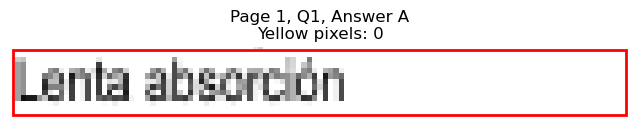

Page 1, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=147.7, y1=121.3
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 299
Page 1, Q1, B: Yellow percentage: 0.0%


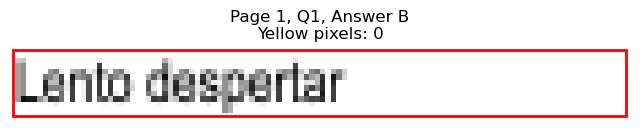

Page 1, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=274.6, y1=133.3
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 1007
Page 1, Q1, C: Yellow percentage: 0.0%


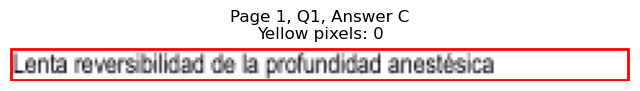

Page 1, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=397.0, y1=109.2
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 336
Page 1, Q1, D: Yellow percentage: 0.0%


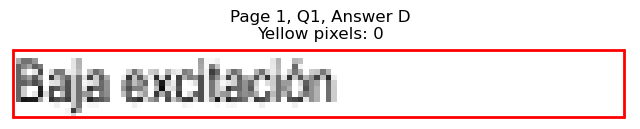

Page 1, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=444.0, y1=121.3
Page 1, Q1, E: Yellow pixels: 1453
Page 1, Q1, E: Total non-white pixels: 2054
Page 1, Q1, E: Yellow percentage: 70.7%


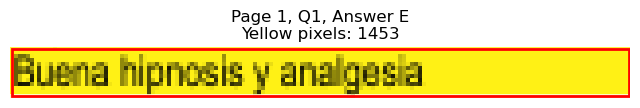


Page 1, Q1 - Selected Answer: E (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=240.1, y1=169.4
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 781
Page 1, Q2, A: Yellow percentage: 0.0%


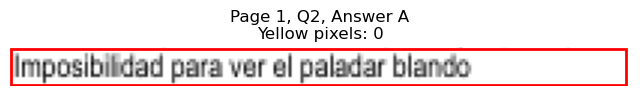

Page 1, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=229.1, y1=181.5
Page 1, Q2, B: Yellow pixels: 190
Page 1, Q2, B: Total non-white pixels: 968
Page 1, Q2, B: Yellow percentage: 19.6%


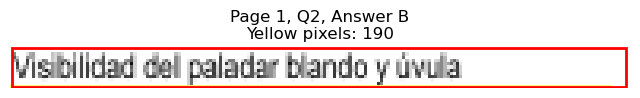

Page 1, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=233.8, y1=193.5
Page 1, Q2, C: Yellow pixels: 1857
Page 1, Q2, C: Total non-white pixels: 2483
Page 1, Q2, C: Yellow percentage: 74.8%


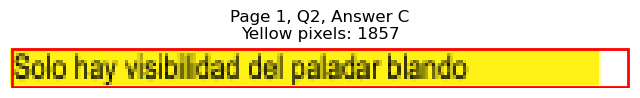

Page 1, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=378.0, y1=169.4
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 468
Page 1, Q2, D: Yellow percentage: 0.0%


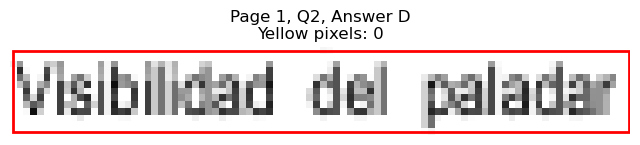

Page 1, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=454.4, y1=193.5
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 599
Page 1, Q2, E: Yellow percentage: 0.0%


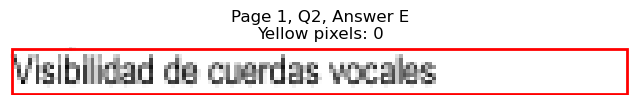


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=85.0, y0=217.5, x1=111.7, y1=229.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 143
Page 1, Q3, A: Yellow percentage: 0.0%


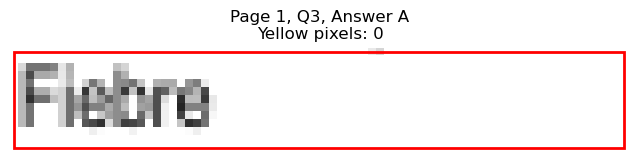

Page 1, Q3 - B: Detected box: x0=85.0, y0=229.7, x1=117.0, y1=241.8
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 176
Page 1, Q3, B: Yellow percentage: 0.0%


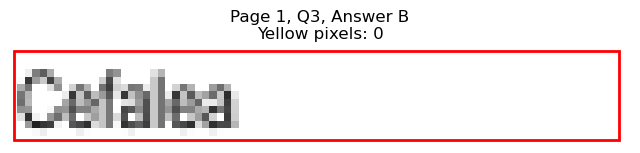

Page 1, Q3 - C: Detected box: x0=85.0, y0=241.7, x1=146.8, y1=253.8
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 332
Page 1, Q3, C: Yellow percentage: 0.0%


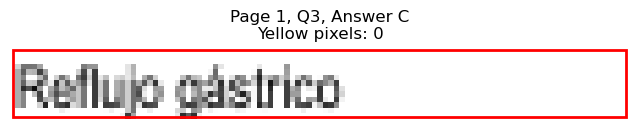

Page 1, Q3 - D: Detected box: x0=336.7, y0=217.5, x1=402.8, y1=229.7
Page 1, Q3, D: Yellow pixels: 1246
Page 1, Q3, D: Total non-white pixels: 1521
Page 1, Q3, D: Yellow percentage: 81.9%


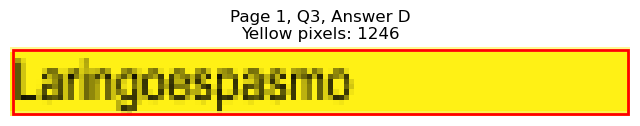

Page 1, Q3 - E: Detected box: x0=336.7, y0=229.7, x1=390.9, y1=241.8
Page 1, Q3, E: Yellow pixels: 105
Page 1, Q3, E: Total non-white pixels: 369
Page 1, Q3, E: Yellow percentage: 28.5%


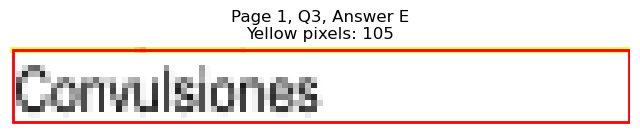


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=85.0, y0=277.8, x1=112.7, y1=289.9
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 134
Page 1, Q4, A: Yellow percentage: 0.0%


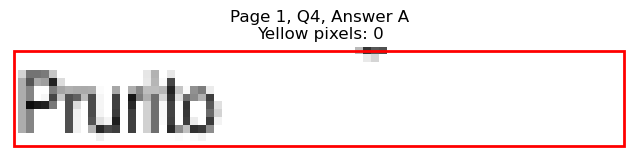

Page 1, Q4 - B: Detected box: x0=85.0, y0=289.9, x1=119.4, y1=302.0
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 170
Page 1, Q4, B: Yellow percentage: 0.0%


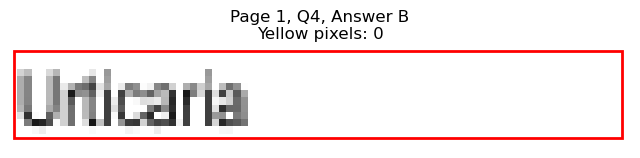

Page 1, Q4 - C: Detected box: x0=85.0, y0=301.9, x1=172.1, y1=314.0
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 466
Page 1, Q4, C: Yellow percentage: 0.0%


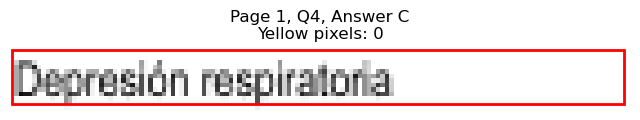

Page 1, Q4 - D: Detected box: x0=336.7, y0=277.8, x1=408.9, y1=289.9
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 384
Page 1, Q4, D: Yellow percentage: 0.0%


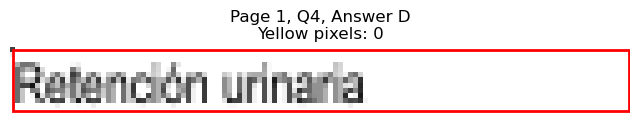

Page 1, Q4 - E: Detected box: x0=336.7, y0=289.9, x1=399.0, y1=302.0
Page 1, Q4, E: Yellow pixels: 1086
Page 1, Q4, E: Total non-white pixels: 1472
Page 1, Q4, E: Yellow percentage: 73.8%


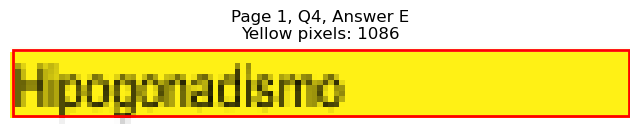


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=85.0, y0=338.1, x1=99.4, y1=350.2
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 52
Page 1, Q5, A: Yellow percentage: 0.0%


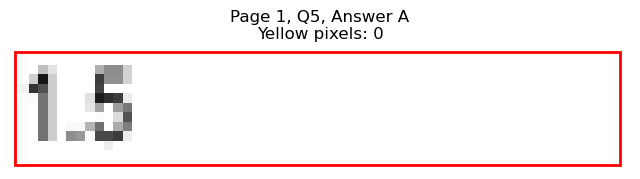

Page 1, Q5 - B: Detected box: x0=85.0, y0=350.2, x1=99.4, y1=362.3
Page 1, Q5, B: Yellow pixels: 745
Page 1, Q5, B: Total non-white pixels: 858
Page 1, Q5, B: Yellow percentage: 86.8%


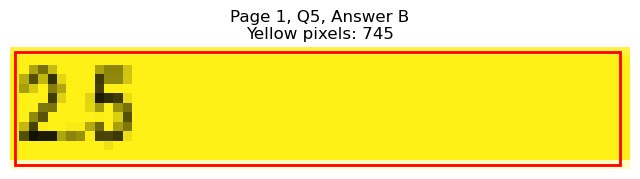

Page 1, Q5 - C: Detected box: x0=70.8, y0=362.2, x1=79.5, y1=374.3
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 114
Page 1, Q5, C: Yellow percentage: 0.0%


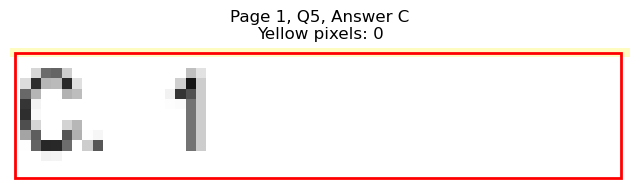

Page 1, Q5 - D: Detected box: x0=322.5, y0=338.1, x1=331.2, y1=350.2
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 62
Page 1, Q5, D: Yellow percentage: 0.0%


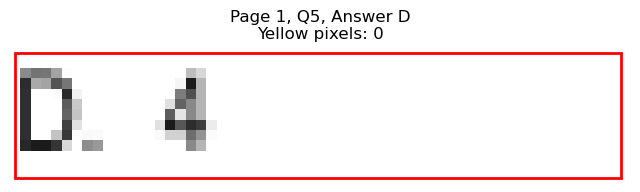

Page 1, Q5 - E: Detected box: x0=322.5, y0=350.2, x1=330.7, y1=362.3
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 59
Page 1, Q5, E: Yellow percentage: 0.0%


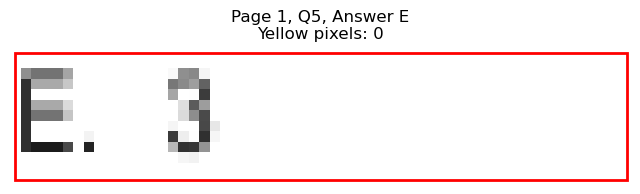


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=70.8, y0=398.3, x1=79.0, y1=410.4
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 64
Page 1, Q6, A: Yellow percentage: 0.0%


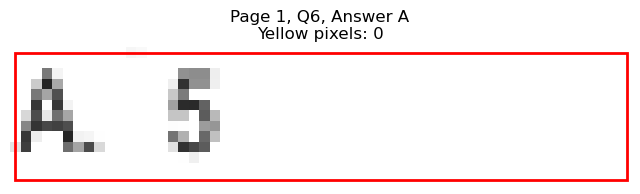

Page 1, Q6 - B: Detected box: x0=70.8, y0=410.4, x1=79.0, y1=422.5
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 65
Page 1, Q6, B: Yellow percentage: 0.0%


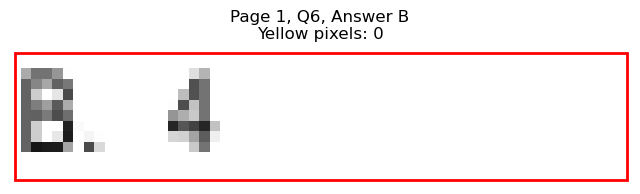

Page 1, Q6 - C: Detected box: x0=70.8, y0=422.4, x1=79.5, y1=434.5
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 65
Page 1, Q6, C: Yellow percentage: 0.0%


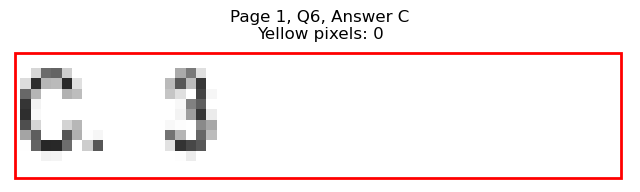

Page 1, Q6 - D: Detected box: x0=322.5, y0=398.3, x1=331.2, y1=410.4
Page 1, Q6, D: Yellow pixels: 730
Page 1, Q6, D: Total non-white pixels: 780
Page 1, Q6, D: Yellow percentage: 93.6%


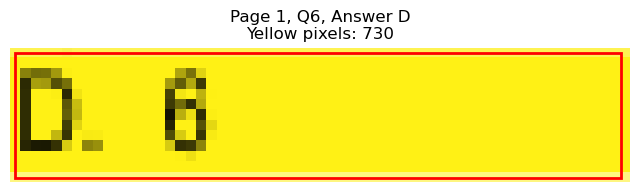

Page 1, Q6 - E: Detected box: x0=322.5, y0=410.4, x1=330.7, y1=422.5
Page 1, Q6, E: Yellow pixels: 59
Page 1, Q6, E: Total non-white pixels: 114
Page 1, Q6, E: Yellow percentage: 51.8%


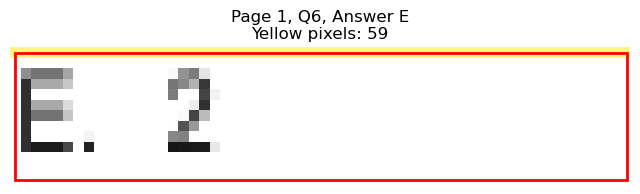


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=85.0, y0=458.6, x1=109.0, y1=470.7
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 139
Page 1, Q7, A: Yellow percentage: 0.0%


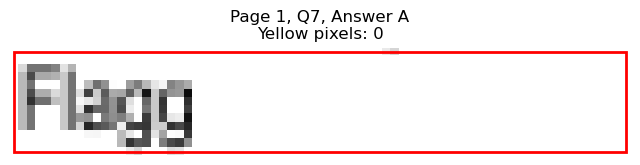

Page 1, Q7 - B: Detected box: x0=85.0, y0=470.7, x1=115.1, y1=482.8
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 246
Page 1, Q7, B: Yellow percentage: 0.0%


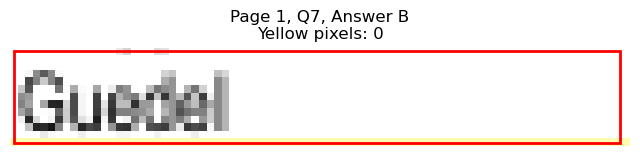

Page 1, Q7 - C: Detected box: x0=85.0, y0=482.7, x1=126.6, y1=494.8
Page 1, Q7, C: Yellow pixels: 928
Page 1, Q7, C: Total non-white pixels: 1209
Page 1, Q7, C: Yellow percentage: 76.8%


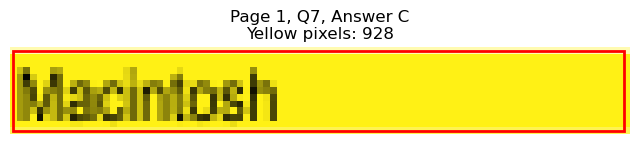

Page 1, Q7 - D: Detected box: x0=336.7, y0=458.6, x1=359.6, y1=470.7
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 131
Page 1, Q7, D: Yellow percentage: 0.0%


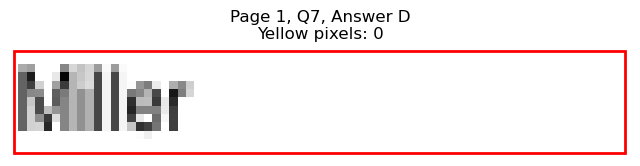

Page 1, Q7 - E: Detected box: x0=336.7, y0=470.7, x1=378.8, y1=482.8
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 210
Page 1, Q7, E: Yellow percentage: 0.0%


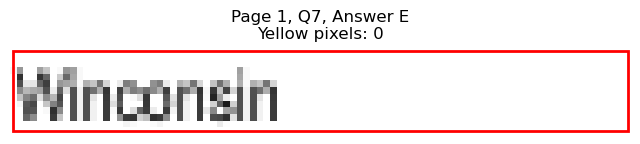


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=85.0, y0=518.8, x1=254.9, y1=530.9
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 889
Page 1, Q8, A: Yellow percentage: 0.0%


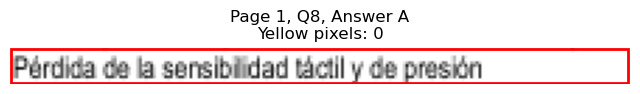

Page 1, Q8 - B: Detected box: x0=85.0, y0=530.9, x1=258.3, y1=543.0
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 895
Page 1, Q8, B: Yellow percentage: 0.0%


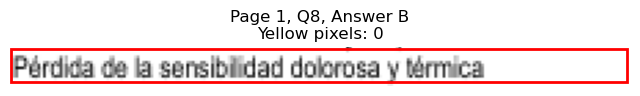

Page 1, Q8 - C: Detected box: x0=85.0, y0=542.9, x1=194.2, y1=555.0
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 574
Page 1, Q8, C: Yellow percentage: 0.0%


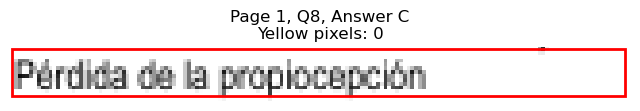

Page 1, Q8 - D: Detected box: x0=336.7, y0=518.8, x1=482.7, y1=530.9
Page 1, Q8, D: Yellow pixels: 1685
Page 1, Q8, D: Total non-white pixels: 2470
Page 1, Q8, D: Yellow percentage: 68.2%


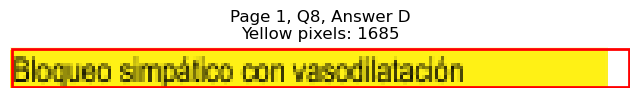

Page 1, Q8 - E: Detected box: x0=336.7, y0=530.9, x1=400.8, y1=543.0
Page 1, Q8, E: Yellow pixels: 111
Page 1, Q8, E: Total non-white pixels: 456
Page 1, Q8, E: Yellow percentage: 24.3%


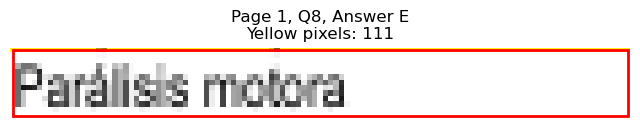


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=85.0, y0=579.1, x1=124.7, y1=591.2
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 191
Page 1, Q9, A: Yellow percentage: 0.0%


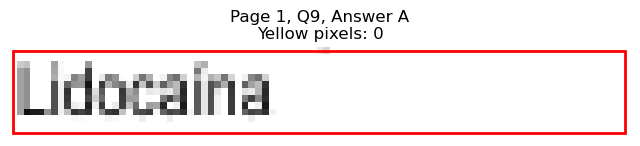

Page 1, Q9 - B: Detected box: x0=85.0, y0=591.2, x1=121.8, y1=603.3
Page 1, Q9, B: Yellow pixels: 914
Page 1, Q9, B: Total non-white pixels: 1144
Page 1, Q9, B: Yellow percentage: 79.9%


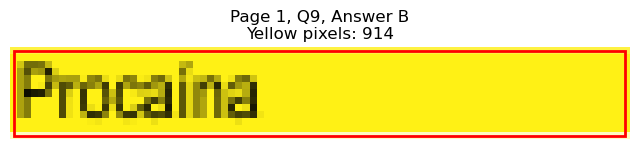

Page 1, Q9 - C: Detected box: x0=85.0, y0=603.2, x1=134.8, y1=615.3
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 358
Page 1, Q9, C: Yellow percentage: 0.0%


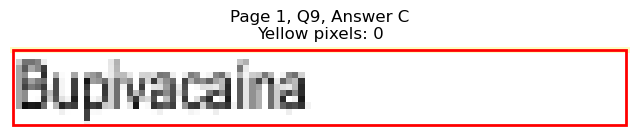

Page 1, Q9 - D: Detected box: x0=336.7, y0=579.1, x1=387.9, y1=591.2
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 271
Page 1, Q9, D: Yellow percentage: 0.0%


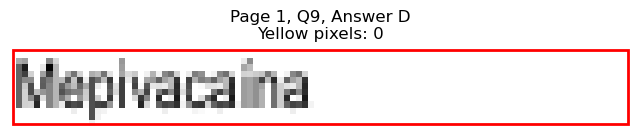

Page 1, Q9 - E: Detected box: x0=336.7, y0=591.2, x1=377.4, y1=603.3
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 210
Page 1, Q9, E: Yellow percentage: 0.0%


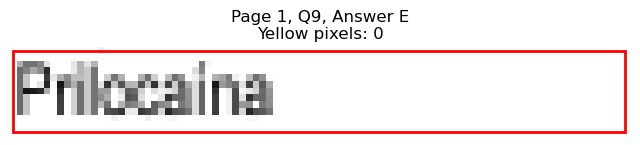


Page 1, Q9 - Selected Answer: B (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=85.0, y0=639.3, x1=131.1, y1=651.4
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 402
Page 1, Q10, A: Yellow percentage: 0.0%


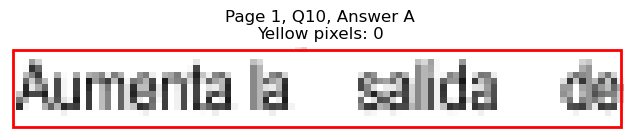

Page 1, Q10 - B: Detected box: x0=85.0, y0=663.4, x1=242.9, y1=675.5
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 802
Page 1, Q10, B: Yellow percentage: 0.0%


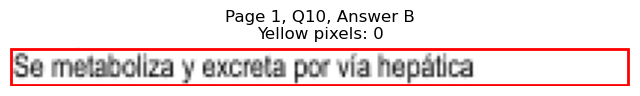

Page 1, Q10 - C: Detected box: x0=85.0, y0=675.4, x1=205.6, y1=687.5
Page 1, Q10, C: Yellow pixels: 0
Page 1, Q10, C: Total non-white pixels: 586
Page 1, Q10, C: Yellow percentage: 0.0%


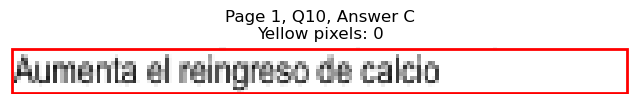

Page 1, Q10 - D: Detected box: x0=336.7, y0=639.3, x1=388.4, y1=651.4
Page 1, Q10, D: Yellow pixels: 951
Page 1, Q10, D: Total non-white pixels: 1339
Page 1, Q10, D: Yellow percentage: 71.0%


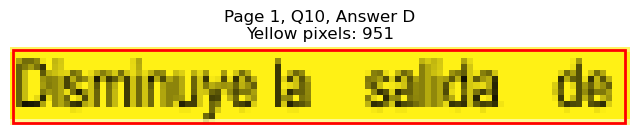

Page 1, Q10 - E: Detected box: x0=336.7, y0=663.4, x1=450.1, y1=675.5
Page 1, Q10, E: Yellow pixels: 165
Page 1, Q10, E: Total non-white pixels: 713
Page 1, Q10, E: Yellow percentage: 23.1%


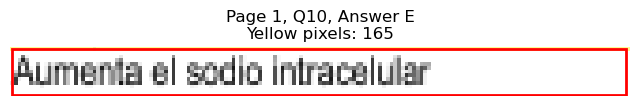


Page 1, Q10 - Selected Answer: D (based on yellow pixel count)




Page 1, Q11 - A: Detected box: x0=85.0, y0=711.7, x1=291.3, y1=723.8
Page 1, Q11, A: Yellow pixels: 2258
Page 1, Q11, A: Total non-white pixels: 3354
Page 1, Q11, A: Yellow percentage: 67.3%


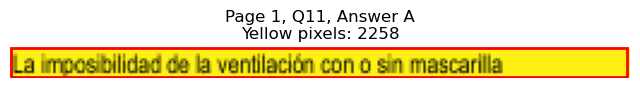

Page 1, Q11 - B: Detected box: x0=85.0, y0=723.7, x1=288.9, y1=735.8
Page 1, Q11, B: Yellow pixels: 253
Page 1, Q11, B: Total non-white pixels: 1257
Page 1, Q11, B: Yellow percentage: 20.1%


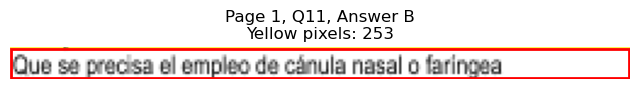

Page 1, Q11 - C: Detected box: x0=85.0, y0=735.8, x1=349.2, y1=747.9
Page 1, Q11, C: Yellow pixels: 0
Page 1, Q11, C: Total non-white pixels: 1323
Page 1, Q11, C: Yellow percentage: 0.0%


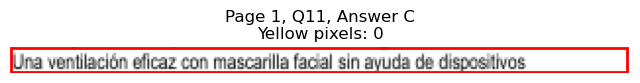

Page 1, Q11 - D: Detected box: x0=85.0, y0=747.8, x1=248.7, y1=759.9
Page 1, Q11, D: Yellow pixels: 0
Page 1, Q11, D: Total non-white pixels: 808
Page 1, Q11, D: Yellow percentage: 0.0%


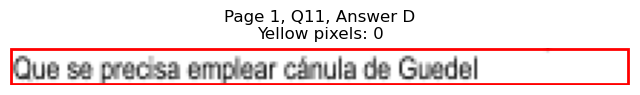

Page 1, Q11 - E: Detected box: x0=85.0, y0=759.8, x1=322.5, y1=771.9
Page 1, Q11, E: Yellow pixels: 0
Page 1, Q11, E: Total non-white pixels: 1170
Page 1, Q11, E: Yellow percentage: 0.0%


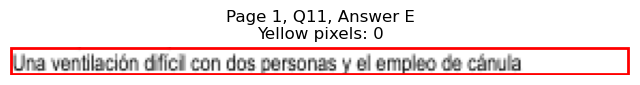


Page 1, Q11 - Selected Answer: A (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=138.6, y1=109.2
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 283
Page 2, Q1, A: Yellow percentage: 0.0%


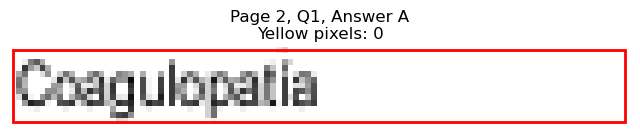

Page 2, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=170.2, y1=121.3
Page 2, Q1, B: Yellow pixels: 137
Page 2, Q1, B: Total non-white pixels: 588
Page 2, Q1, B: Yellow percentage: 23.3%


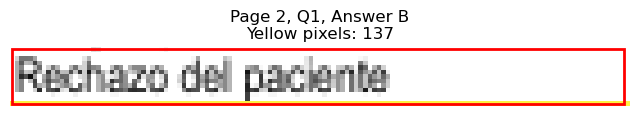

Page 2, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=182.7, y1=133.3
Page 2, Q1, C: Yellow pixels: 1383
Page 2, Q1, C: Total non-white pixels: 1937
Page 2, Q1, C: Yellow percentage: 71.4%


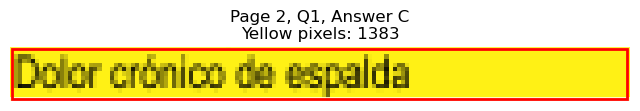

Page 2, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=433.9, y1=109.2
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 504
Page 2, Q1, D: Yellow percentage: 0.0%


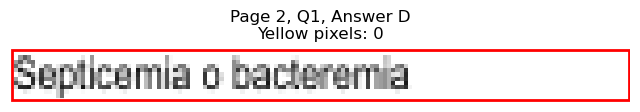

Page 2, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=456.9, y1=121.3
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 577
Page 2, Q1, E: Yellow percentage: 0.0%


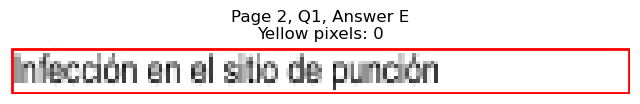


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=203.7, y1=169.4
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 601
Page 2, Q2, A: Yellow percentage: 0.0%


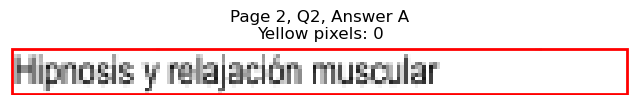

Page 2, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=301.9, y1=181.5
Page 2, Q2, B: Yellow pixels: 2601
Page 2, Q2, B: Total non-white pixels: 3484
Page 2, Q2, B: Yellow percentage: 74.7%


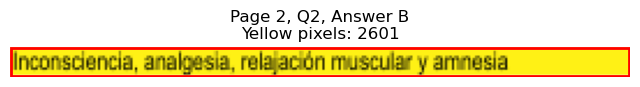

Page 2, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=186.5, y1=193.5
Page 2, Q2, C: Yellow pixels: 153
Page 2, Q2, C: Total non-white pixels: 662
Page 2, Q2, C: Yellow percentage: 23.1%


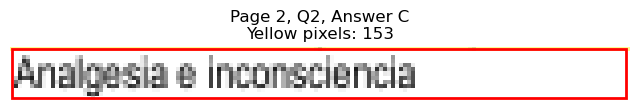

Page 2, Q2 - D: Detected box: x0=85.0, y0=193.4, x1=229.1, y1=205.5
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 725
Page 2, Q2, D: Yellow percentage: 0.0%


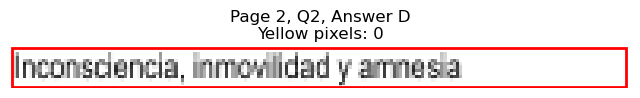

Page 2, Q2 - E: Detected box: x0=85.0, y0=205.5, x1=166.3, y1=217.7
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 434
Page 2, Q2, E: Yellow percentage: 0.0%


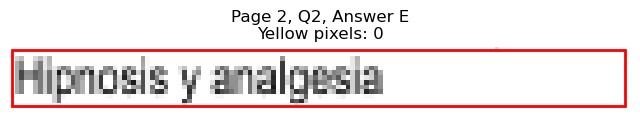


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=85.0, y0=265.8, x1=161.5, y1=277.9
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 421
Page 2, Q3, A: Yellow percentage: 0.0%


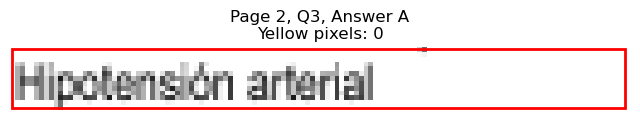

Page 2, Q3 - B: Detected box: x0=85.0, y0=277.8, x1=132.4, y1=289.9
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 251
Page 2, Q3, B: Yellow percentage: 0.0%


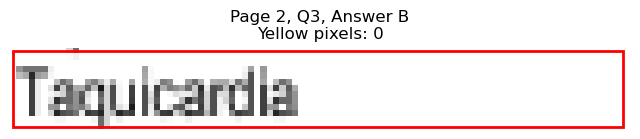

Page 2, Q3 - C: Detected box: x0=85.0, y0=289.9, x1=101.8, y1=302.0
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 75
Page 2, Q3, C: Yellow percentage: 0.0%


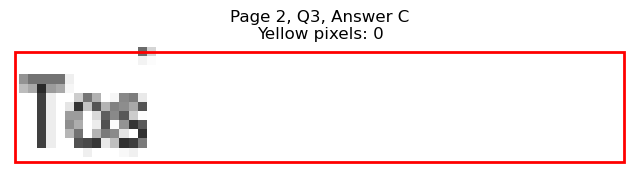

Page 2, Q3 - D: Detected box: x0=336.7, y0=265.8, x1=370.2, y1=277.9
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 243
Page 2, Q3, D: Yellow percentage: 0.0%


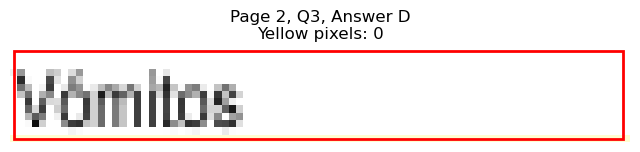

Page 2, Q3 - E: Detected box: x0=336.7, y0=277.8, x1=416.1, y1=289.9
Page 2, Q3, E: Yellow pixels: 1227
Page 2, Q3, E: Total non-white pixels: 1703
Page 2, Q3, E: Yellow percentage: 72.0%


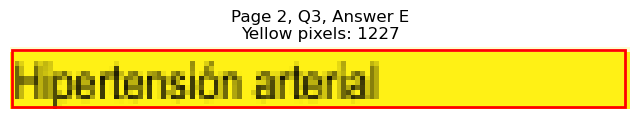


Page 2, Q3 - Selected Answer: E (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=123.7, y1=350.2
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 197
Page 2, Q4, A: Yellow percentage: 0.0%


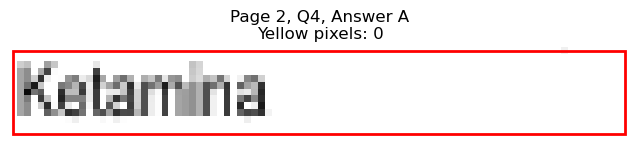

Page 2, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=130.5, y1=362.3
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 255
Page 2, Q4, B: Yellow percentage: 0.0%


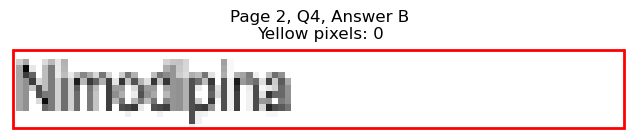

Page 2, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=126.1, y1=374.3
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 222
Page 2, Q4, C: Yellow percentage: 0.0%


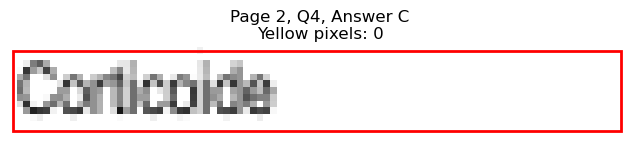

Page 2, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=380.2, y1=350.2
Page 2, Q4, D: Yellow pixels: 932
Page 2, Q4, D: Total non-white pixels: 1235
Page 2, Q4, D: Yellow percentage: 75.5%


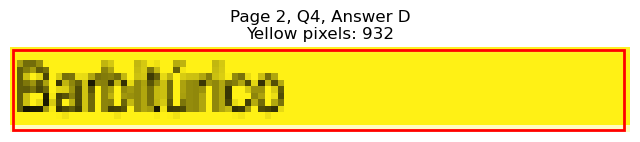

Page 2, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=391.3, y1=362.3
Page 2, Q4, E: Yellow pixels: 0
Page 2, Q4, E: Total non-white pixels: 366
Page 2, Q4, E: Yellow percentage: 0.0%


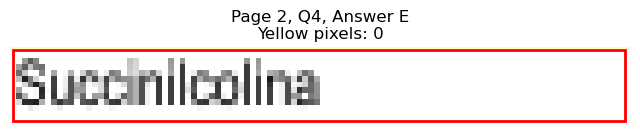


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=129.1, y1=410.4
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 239
Page 2, Q5, A: Yellow percentage: 0.0%


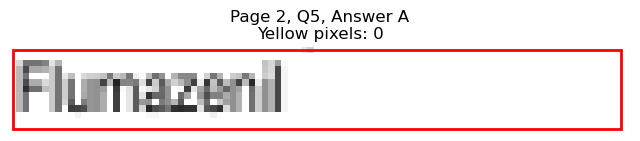

Page 2, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=119.4, y1=422.5
Page 2, Q5, B: Yellow pixels: 86
Page 2, Q5, B: Total non-white pixels: 271
Page 2, Q5, B: Yellow percentage: 31.7%


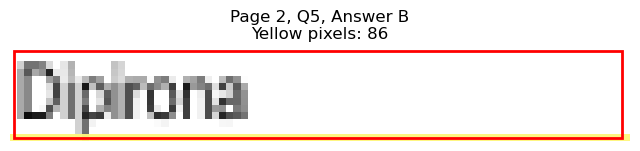

Page 2, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=129.5, y1=434.5
Page 2, Q5, C: Yellow pixels: 1055
Page 2, Q5, C: Total non-white pixels: 1248
Page 2, Q5, C: Yellow percentage: 84.5%


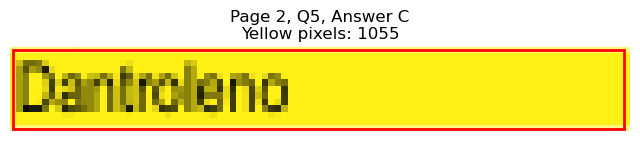

Page 2, Q5 - D: Detected box: x0=336.7, y0=398.3, x1=397.0, y1=410.4
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 326
Page 2, Q5, D: Yellow percentage: 0.0%


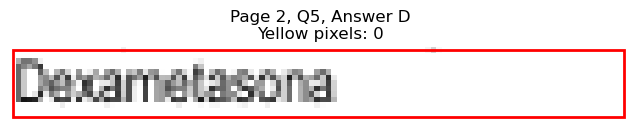

Page 2, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=397.0, y1=422.5
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 315
Page 2, Q5, E: Yellow percentage: 0.0%


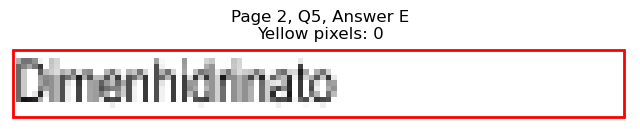


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=85.0, y0=458.6, x1=205.1, y1=470.7
Page 2, Q6, A: Yellow pixels: 1752
Page 2, Q6, A: Total non-white pixels: 2236
Page 2, Q6, A: Yellow percentage: 78.4%


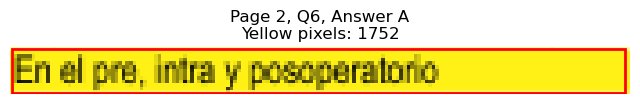

Page 2, Q6 - B: Detected box: x0=85.0, y0=470.7, x1=179.3, y1=482.8
Page 2, Q6, B: Yellow pixels: 146
Page 2, Q6, B: Total non-white pixels: 586
Page 2, Q6, B: Yellow percentage: 24.9%


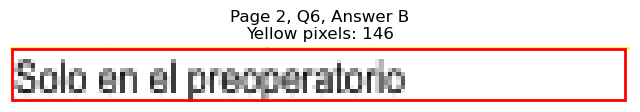

Page 2, Q6 - C: Detected box: x0=85.0, y0=482.7, x1=162.5, y1=494.8
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 394
Page 2, Q6, C: Yellow percentage: 0.0%


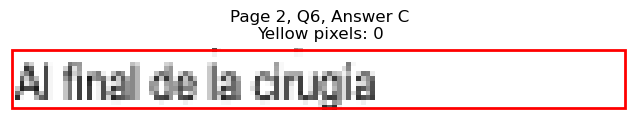

Page 2, Q6 - D: Detected box: x0=336.7, y0=458.6, x1=449.3, y1=470.7
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 564
Page 2, Q6, D: Yellow percentage: 0.0%


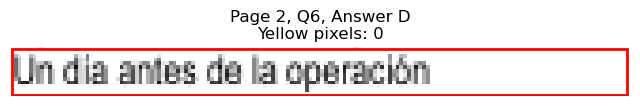

Page 2, Q6 - E: Detected box: x0=336.7, y0=470.7, x1=418.0, y1=482.8
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 380
Page 2, Q6, E: Yellow percentage: 0.0%


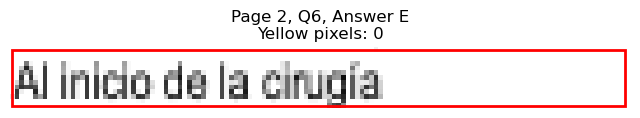


Page 2, Q6 - Selected Answer: A (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=85.0, y0=518.8, x1=299.0, y1=530.9
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 1084
Page 2, Q7, A: Yellow percentage: 0.0%


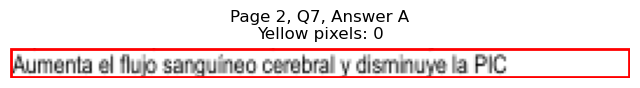

Page 2, Q7 - B: Detected box: x0=85.0, y0=530.9, x1=274.5, y1=543.0
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 937
Page 2, Q7, B: Yellow percentage: 0.0%


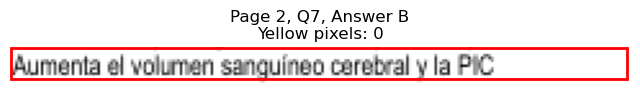

Page 2, Q7 - C: Detected box: x0=85.0, y0=542.9, x1=219.1, y1=555.0
Page 2, Q7, C: Yellow pixels: 186
Page 2, Q7, C: Total non-white pixels: 1037
Page 2, Q7, C: Yellow percentage: 17.9%


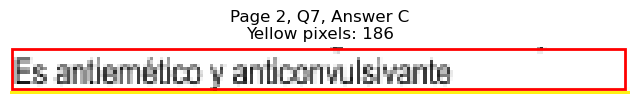

Page 2, Q7 - D: Detected box: x0=85.0, y0=554.9, x1=423.0, y1=567.0
Page 2, Q7, D: Yellow pixels: 3295
Page 2, Q7, D: Total non-white pixels: 5446
Page 2, Q7, D: Yellow percentage: 60.5%


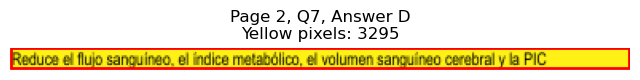

Page 2, Q7 - E: Detected box: x0=85.0, y0=567.1, x1=209.5, y1=579.2
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 820
Page 2, Q7, E: Yellow percentage: 0.0%


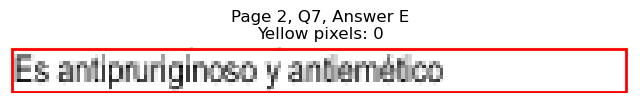


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=85.0, y0=603.2, x1=131.4, y1=615.3
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 235
Page 2, Q8, A: Yellow percentage: 0.0%


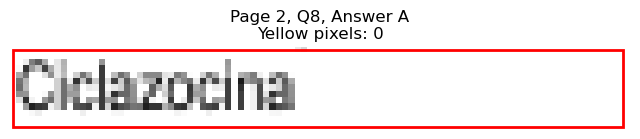

Page 2, Q8 - B: Detected box: x0=85.0, y0=615.2, x1=136.7, y1=627.3
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 262
Page 2, Q8, B: Yellow percentage: 0.0%


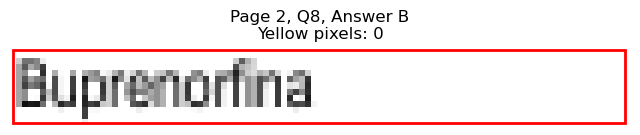

Page 2, Q8 - C: Detected box: x0=85.0, y0=627.3, x1=130.9, y1=639.4
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 244
Page 2, Q8, C: Yellow percentage: 0.0%


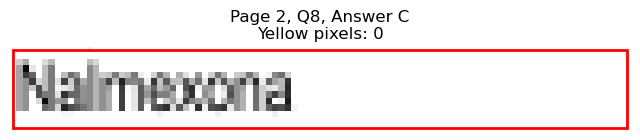

Page 2, Q8 - D: Detected box: x0=336.7, y0=603.2, x1=387.0, y1=615.3
Page 2, Q8, D: Yellow pixels: 101
Page 2, Q8, D: Total non-white pixels: 383
Page 2, Q8, D: Yellow percentage: 26.4%


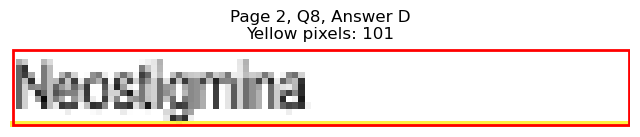

Page 2, Q8 - E: Detected box: x0=336.7, y0=615.2, x1=375.4, y1=627.3
Page 2, Q8, E: Yellow pixels: 920
Page 2, Q8, E: Total non-white pixels: 1170
Page 2, Q8, E: Yellow percentage: 78.6%


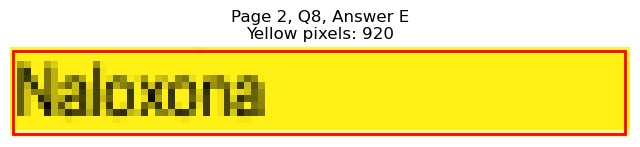


Page 2, Q8 - Selected Answer: E (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=109.0, y1=675.5
Page 2, Q9, A: Yellow pixels: 75
Page 2, Q9, A: Total non-white pixels: 179
Page 2, Q9, A: Yellow percentage: 41.9%


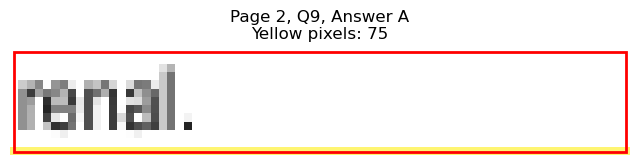

Page 2, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=122.3, y1=687.5
Page 2, Q9, B: Yellow pixels: 1017
Page 2, Q9, B: Total non-white pixels: 1157
Page 2, Q9, B: Yellow percentage: 87.9%


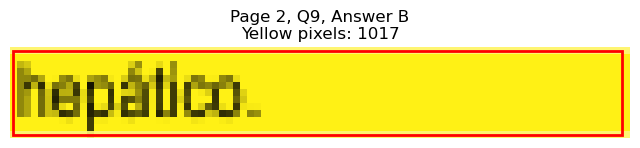

Page 2, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=131.4, y1=699.7
Page 2, Q9, C: Yellow pixels: 98
Page 2, Q9, C: Total non-white pixels: 327
Page 2, Q9, C: Yellow percentage: 30.0%


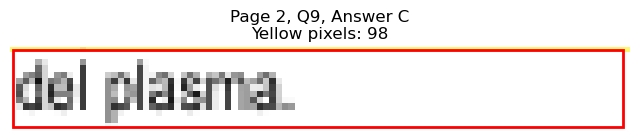

Page 2, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=366.8, y1=675.5
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 135
Page 2, Q9, D: Yellow percentage: 0.0%


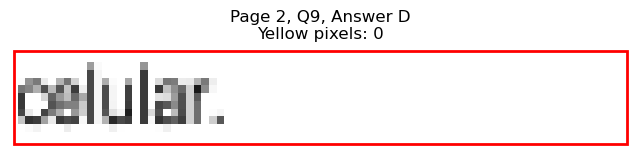

Page 2, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=359.6, y1=687.5
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 106
Page 2, Q9, E: Yellow percentage: 0.0%


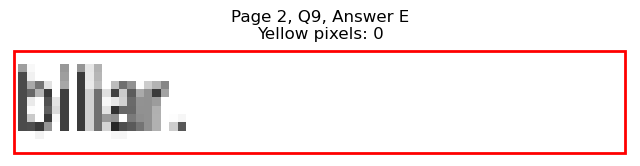


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=85.0, y0=735.8, x1=261.2, y1=747.9
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 899
Page 2, Q10, A: Yellow percentage: 0.0%


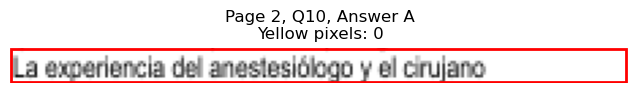

Page 2, Q10 - B: Detected box: x0=85.0, y0=747.8, x1=197.0, y1=759.9
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 781
Page 2, Q10, B: Yellow percentage: 0.0%


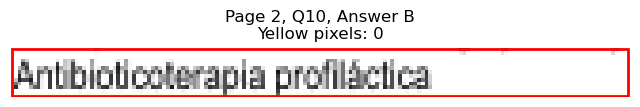

Page 2, Q10 - C: Detected box: x0=85.0, y0=759.8, x1=275.1, y1=771.9
Page 2, Q10, C: Yellow pixels: 1511
Page 2, Q10, C: Total non-white pixels: 2483
Page 2, Q10, C: Yellow percentage: 60.9%


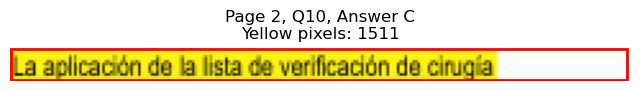

Page 2, Q10 - D: Detected box: x0=336.7, y0=735.8, x1=494.1, y1=747.9
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 809
Page 2, Q10, D: Yellow percentage: 0.0%


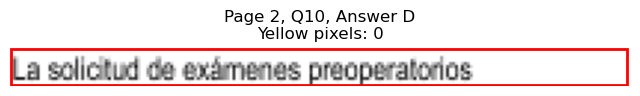

Page 2, Q10 - E: Detected box: x0=336.7, y0=747.8, x1=503.3, y1=759.9
Page 2, Q10, E: Yellow pixels: 0
Page 2, Q10, E: Total non-white pixels: 801
Page 2, Q10, E: Yellow percentage: 0.0%


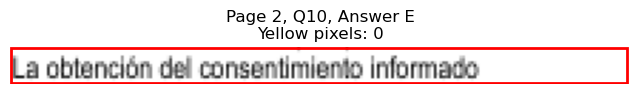


Page 2, Q10 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=123.7, y1=109.2
Page 3, Q1, A: Yellow pixels: 917
Page 3, Q1, A: Total non-white pixels: 1170
Page 3, Q1, A: Yellow percentage: 78.4%


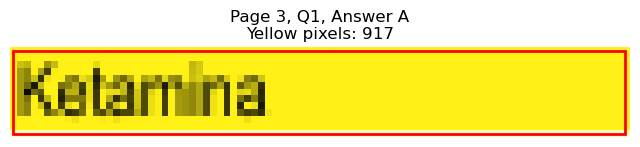

Page 3, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=122.8, y1=121.3
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 277
Page 3, Q1, B: Yellow percentage: 0.0%


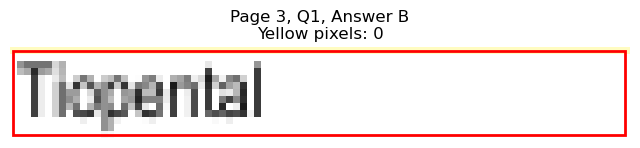

Page 3, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=118.9, y1=133.3
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 182
Page 3, Q1, C: Yellow percentage: 0.0%


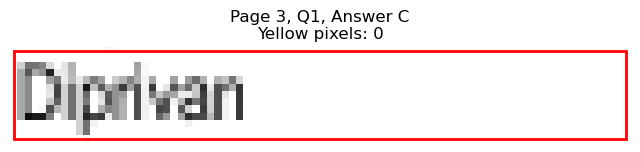

Page 3, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=385.2, y1=109.2
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 255
Page 3, Q1, D: Yellow percentage: 0.0%


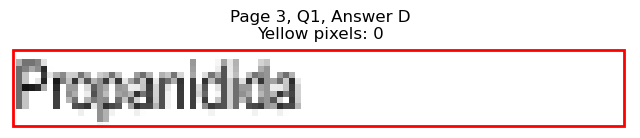

Page 3, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=377.8, y1=121.3
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 208
Page 3, Q1, E: Yellow percentage: 0.0%


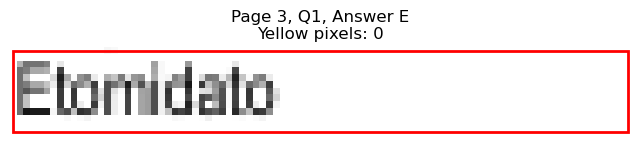


Page 3, Q1 - Selected Answer: A (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=262.1, y1=169.4
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 837
Page 3, Q2, A: Yellow percentage: 0.0%


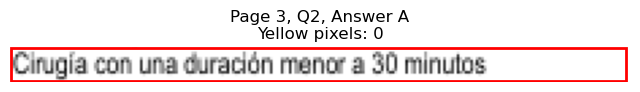

Page 3, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=211.4, y1=181.5
Page 3, Q2, B: Yellow pixels: 178
Page 3, Q2, B: Total non-white pixels: 793
Page 3, Q2, B: Yellow percentage: 22.4%


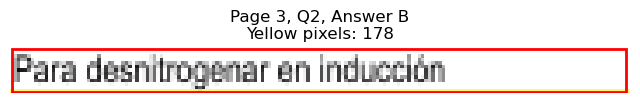

Page 3, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=151.1, y1=193.5
Page 3, Q2, C: Yellow pixels: 1261
Page 3, Q2, C: Total non-white pixels: 1534
Page 3, Q2, C: Yellow percentage: 82.2%


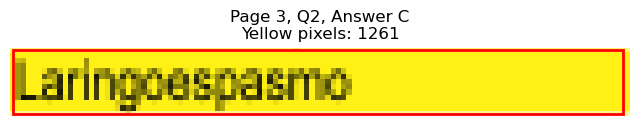

Page 3, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=477.9, y1=169.4
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 696
Page 3, Q2, D: Yellow percentage: 0.0%


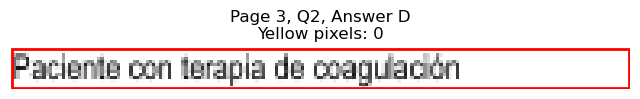

Page 3, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=420.0, y1=181.5
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 437
Page 3, Q2, E: Yellow percentage: 0.0%


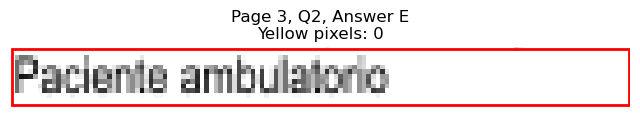


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=85.0, y0=217.5, x1=265.0, y1=229.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 840
Page 3, Q3, A: Yellow percentage: 0.0%


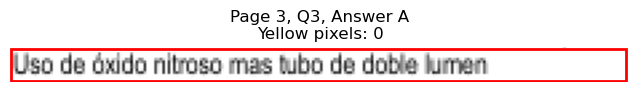

Page 3, Q3 - B: Detected box: x0=85.0, y0=229.7, x1=219.1, y1=241.8
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 685
Page 3, Q3, B: Yellow percentage: 0.0%


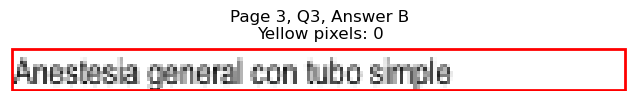

Page 3, Q3 - C: Detected box: x0=85.0, y0=241.7, x1=275.1, y1=253.8
Page 3, Q3, C: Yellow pixels: 42
Page 3, Q3, C: Total non-white pixels: 981
Page 3, Q3, C: Yellow percentage: 4.3%


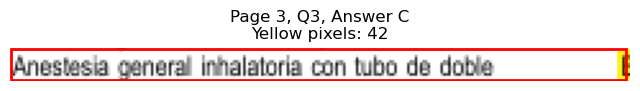

Page 3, Q3 - D: Detected box: x0=397.9, y0=217.5, x1=458.6, y1=229.7
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 484
Page 3, Q3, D: Yellow percentage: 0.0%


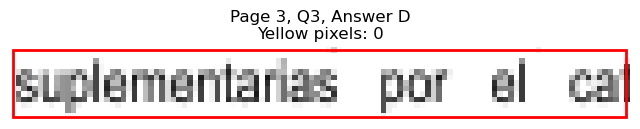

Page 3, Q3 - E: Detected box: x0=336.7, y0=241.7, x1=501.8, y1=253.8
Page 3, Q3, E: Yellow pixels: 1629
Page 3, Q3, E: Total non-white pixels: 2470
Page 3, Q3, E: Yellow percentage: 66.0%


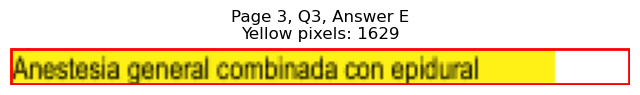


Page 3, Q3 - Selected Answer: E (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=85.0, y0=289.9, x1=146.8, y1=302.0
Page 3, Q4, A: Yellow pixels: 113
Page 3, Q4, A: Total non-white pixels: 545
Page 3, Q4, A: Yellow percentage: 20.7%


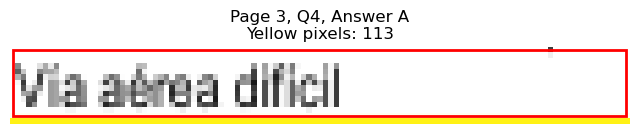

Page 3, Q4 - B: Detected box: x0=85.0, y0=301.9, x1=138.6, y1=314.0
Page 3, Q4, B: Yellow pixels: 1035
Page 3, Q4, B: Total non-white pixels: 1368
Page 3, Q4, B: Yellow percentage: 75.7%


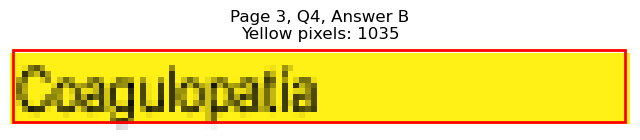

Page 3, Q4 - C: Detected box: x0=85.0, y0=313.9, x1=203.2, y1=326.0
Page 3, Q4, C: Yellow pixels: 164
Page 3, Q4, C: Total non-white pixels: 789
Page 3, Q4, C: Yellow percentage: 20.8%


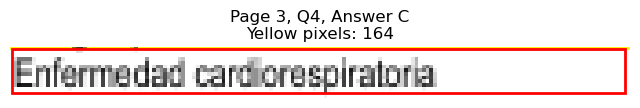

Page 3, Q4 - D: Detected box: x0=336.7, y0=289.9, x1=391.4, y1=302.0
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 300
Page 3, Q4, D: Yellow percentage: 0.0%


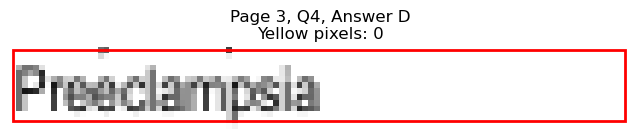

Page 3, Q4 - E: Detected box: x0=336.7, y0=301.9, x1=410.4, y1=314.0
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 372
Page 3, Q4, E: Yellow percentage: 0.0%


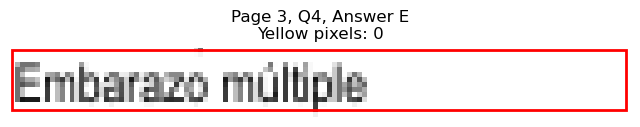


Page 3, Q4 - Selected Answer: B (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=85.0, y0=350.2, x1=161.5, y1=362.3
Page 3, Q5, A: Yellow pixels: 128
Page 3, Q5, A: Total non-white pixels: 549
Page 3, Q5, A: Yellow percentage: 23.3%


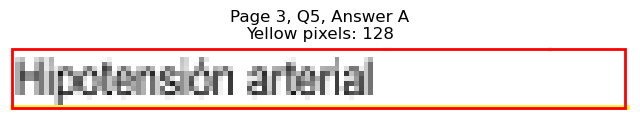

Page 3, Q5 - B: Detected box: x0=85.0, y0=362.2, x1=134.8, y1=374.3
Page 3, Q5, B: Yellow pixels: 1001
Page 3, Q5, B: Total non-white pixels: 1313
Page 3, Q5, B: Yellow percentage: 76.2%


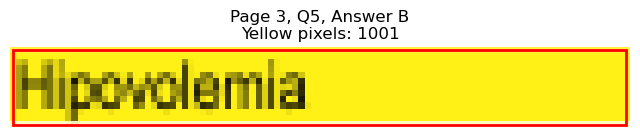

Page 3, Q5 - C: Detected box: x0=85.0, y0=374.2, x1=132.4, y1=386.3
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 348
Page 3, Q5, C: Yellow percentage: 0.0%


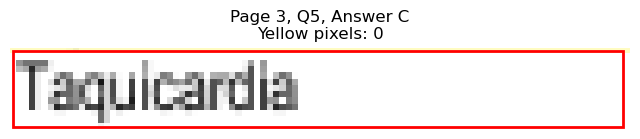

Page 3, Q5 - D: Detected box: x0=336.7, y0=350.2, x1=393.2, y1=362.3
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 305
Page 3, Q5, D: Yellow percentage: 0.0%


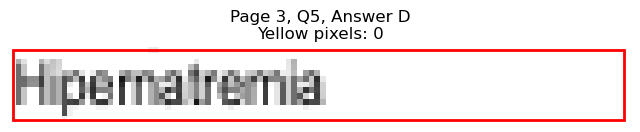

Page 3, Q5 - E: Detected box: x0=336.7, y0=362.2, x1=382.6, y1=374.3
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 246
Page 3, Q5, E: Yellow percentage: 0.0%


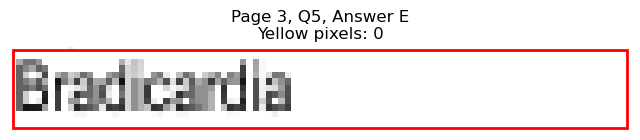


Page 3, Q5 - Selected Answer: B (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=85.0, y0=410.4, x1=121.8, y1=422.5
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 209
Page 3, Q6, A: Yellow percentage: 0.0%


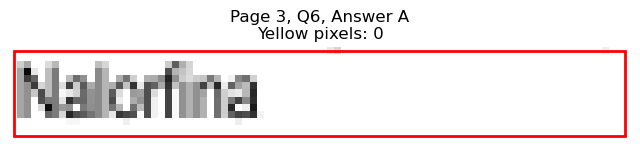

Page 3, Q6 - B: Detected box: x0=85.0, y0=422.4, x1=136.8, y1=434.5
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 262
Page 3, Q6, B: Yellow percentage: 0.0%


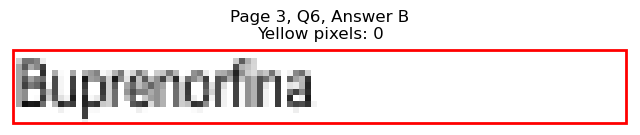

Page 3, Q6 - C: Detected box: x0=85.0, y0=434.4, x1=116.1, y1=446.5
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 172
Page 3, Q6, C: Yellow percentage: 0.0%


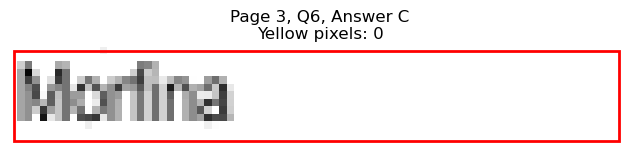

Page 3, Q6 - D: Detected box: x0=336.7, y0=410.4, x1=374.5, y1=422.5
Page 3, Q6, D: Yellow pixels: 89
Page 3, Q6, D: Total non-white pixels: 268
Page 3, Q6, D: Yellow percentage: 33.2%


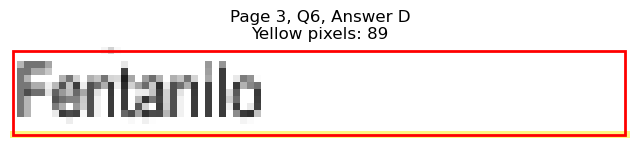

Page 3, Q6 - E: Detected box: x0=336.7, y0=422.4, x1=381.7, y1=434.5
Page 3, Q6, E: Yellow pixels: 1043
Page 3, Q6, E: Total non-white pixels: 1248
Page 3, Q6, E: Yellow percentage: 83.6%


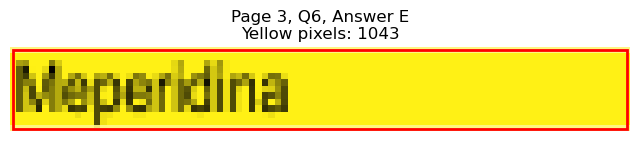


Page 3, Q6 - Selected Answer: E (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=85.0, y0=482.7, x1=138.1, y1=494.8
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 279
Page 3, Q7, A: Yellow percentage: 0.0%


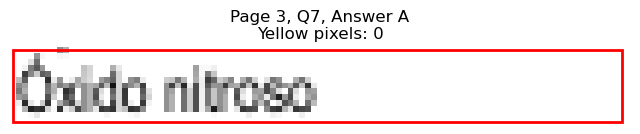

Page 3, Q7 - B: Detected box: x0=85.0, y0=494.7, x1=125.2, y1=506.8
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 207
Page 3, Q7, B: Yellow percentage: 0.0%


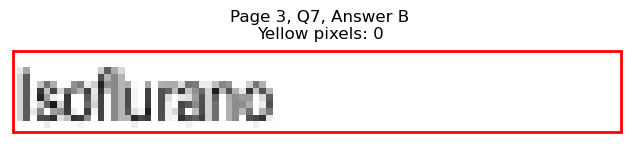

Page 3, Q7 - C: Detected box: x0=85.0, y0=506.8, x1=133.3, y1=518.9
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 249
Page 3, Q7, C: Yellow percentage: 0.0%


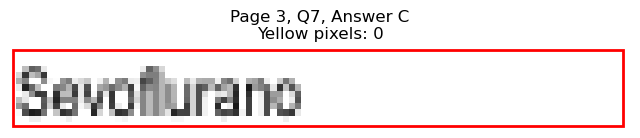

Page 3, Q7 - D: Detected box: x0=336.7, y0=482.7, x1=375.4, y1=494.8
Page 3, Q7, D: Yellow pixels: 929
Page 3, Q7, D: Total non-white pixels: 1170
Page 3, Q7, D: Yellow percentage: 79.4%


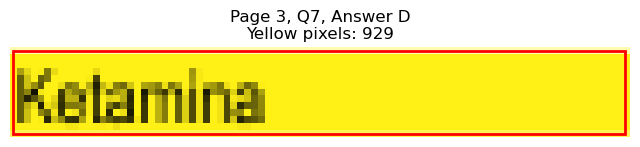

Page 3, Q7 - E: Detected box: x0=336.7, y0=494.7, x1=374.5, y1=506.8
Page 3, Q7, E: Yellow pixels: 89
Page 3, Q7, E: Total non-white pixels: 280
Page 3, Q7, E: Yellow percentage: 31.8%


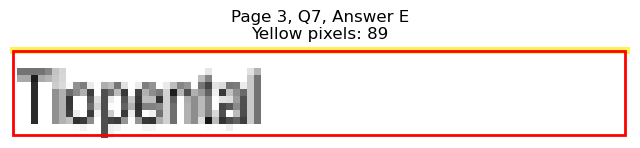


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=85.0, y0=554.9, x1=119.4, y1=567.0
Page 3, Q8, A: Yellow pixels: 888
Page 3, Q8, A: Total non-white pixels: 1204
Page 3, Q8, A: Yellow percentage: 73.8%


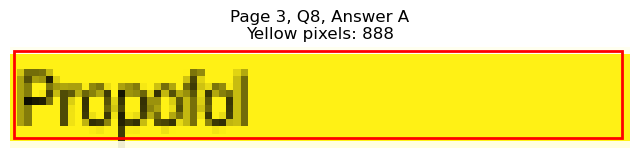

Page 3, Q8 - B: Detected box: x0=85.0, y0=567.1, x1=129.0, y1=579.2
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 337
Page 3, Q8, B: Yellow percentage: 0.0%


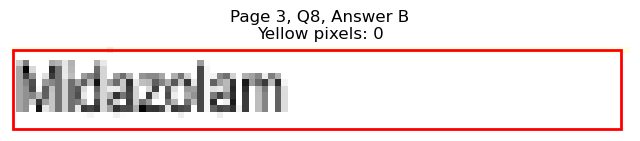

Page 3, Q8 - C: Detected box: x0=85.0, y0=579.1, x1=126.1, y1=591.2
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 220
Page 3, Q8, C: Yellow percentage: 0.0%


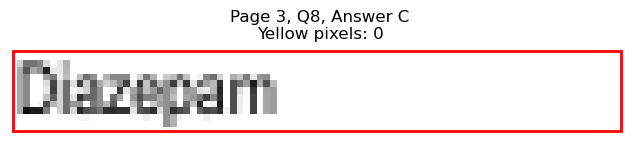

Page 3, Q8 - D: Detected box: x0=336.7, y0=554.9, x1=401.8, y1=567.0
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 322
Page 3, Q8, D: Yellow percentage: 0.0%


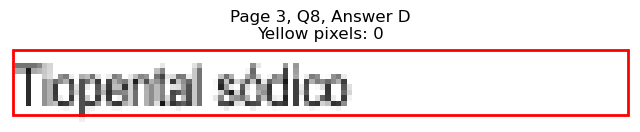

Page 3, Q8 - E: Detected box: x0=336.7, y0=567.1, x1=391.3, y1=579.2
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 261
Page 3, Q8, E: Yellow percentage: 0.0%


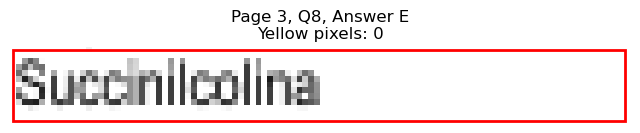


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=85.0, y0=627.3, x1=126.6, y1=639.4
Page 3, Q9, A: Yellow pixels: 924
Page 3, Q9, A: Total non-white pixels: 1209
Page 3, Q9, A: Yellow percentage: 76.4%


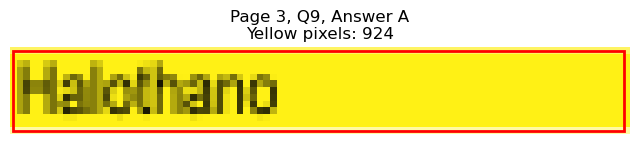

Page 3, Q9 - B: Detected box: x0=85.0, y0=494.7, x1=125.2, y1=506.8
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 207
Page 3, Q9, B: Yellow percentage: 0.0%


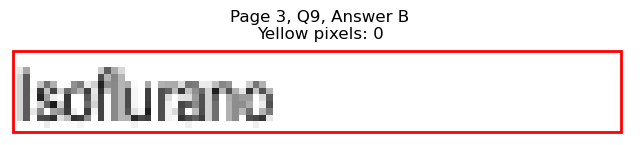

Page 3, Q9 - C: Detected box: x0=85.0, y0=651.4, x1=129.0, y1=663.5
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 225
Page 3, Q9, C: Yellow percentage: 0.0%


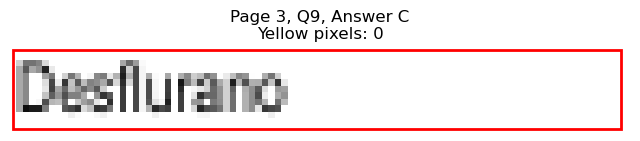

Page 3, Q9 - D: Detected box: x0=336.7, y0=627.3, x1=389.8, y1=639.4
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 249
Page 3, Q9, D: Yellow percentage: 0.0%


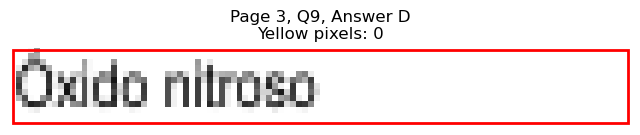

Page 3, Q9 - E: Detected box: x0=336.7, y0=639.3, x1=385.0, y1=651.4
Page 3, Q9, E: Yellow pixels: 0
Page 3, Q9, E: Total non-white pixels: 239
Page 3, Q9, E: Yellow percentage: 0.0%


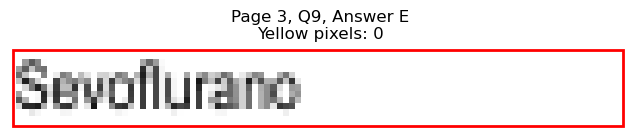


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=85.0, y0=687.5, x1=97.0, y1=699.7
Page 3, Q10, A: Yellow pixels: 769
Page 3, Q10, A: Total non-white pixels: 819
Page 3, Q10, A: Yellow percentage: 93.9%


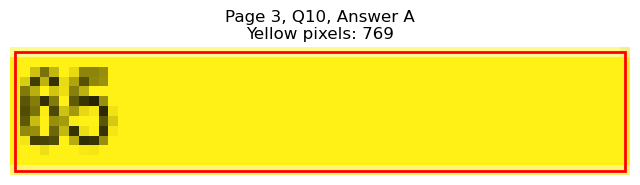

Page 3, Q10 - B: Detected box: x0=85.0, y0=699.5, x1=97.0, y1=711.7
Page 3, Q10, B: Yellow pixels: 63
Page 3, Q10, B: Total non-white pixels: 124
Page 3, Q10, B: Yellow percentage: 50.8%


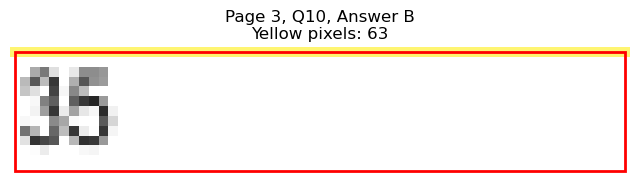

Page 3, Q10 - C: Detected box: x0=85.0, y0=711.7, x1=101.8, y1=723.8
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 80
Page 3, Q10, C: Yellow percentage: 0.0%


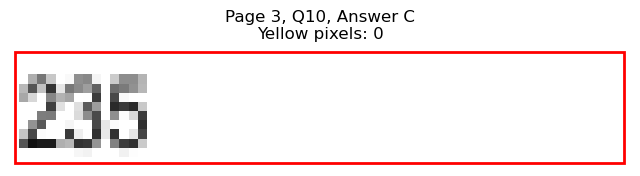

Page 3, Q10 - D: Detected box: x0=336.7, y0=687.5, x1=348.7, y1=699.7
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 52
Page 3, Q10, D: Yellow percentage: 0.0%


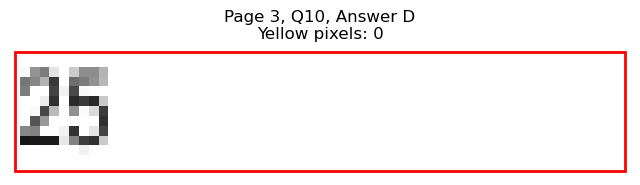

Page 3, Q10 - E: Detected box: x0=336.7, y0=699.5, x1=353.5, y1=711.7
Page 3, Q10, E: Yellow pixels: 0
Page 3, Q10, E: Total non-white pixels: 58
Page 3, Q10, E: Yellow percentage: 0.0%


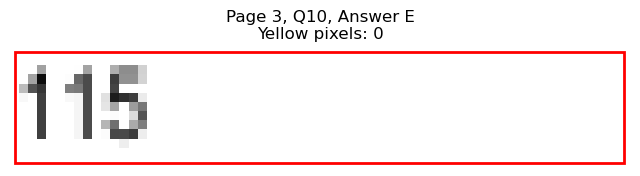


Page 3, Q10 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=388.0, y1=121.3
Page 4, Q1, A: Yellow pixels: 3048
Page 4, Q1, A: Total non-white pixels: 4615
Page 4, Q1, A: Yellow percentage: 66.0%


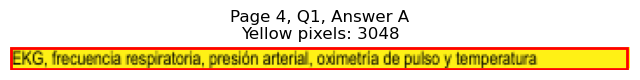

Page 4, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=336.3, y1=133.3
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 1561
Page 4, Q1, B: Yellow percentage: 0.0%


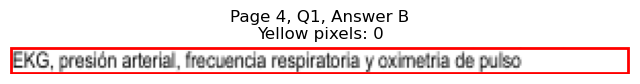

Page 4, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=222.9, y1=145.3
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 677
Page 4, Q1, C: Yellow percentage: 0.0%


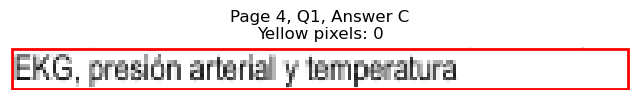

Page 4, Q1 - D: Detected box: x0=85.0, y0=145.3, x1=300.4, y1=157.4
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 1055
Page 4, Q1, D: Yellow percentage: 0.0%


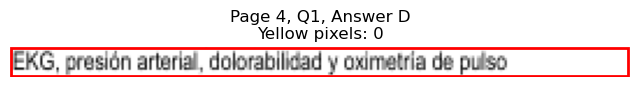

Page 4, Q1 - E: Detected box: x0=85.0, y0=157.3, x1=315.2, y1=169.4
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 1171
Page 4, Q1, E: Yellow percentage: 0.0%


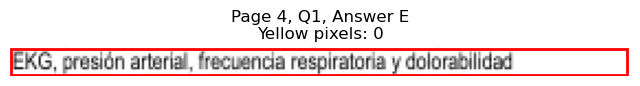


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=119.4, y1=205.5
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 176
Page 4, Q2, A: Yellow percentage: 0.0%


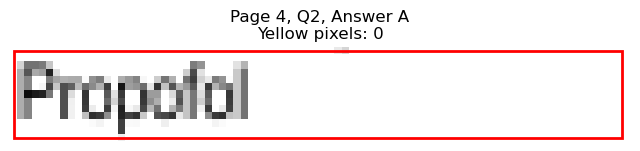

Page 4, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=123.7, y1=217.7
Page 4, Q2, B: Yellow pixels: 1007
Page 4, Q2, B: Total non-white pixels: 1170
Page 4, Q2, B: Yellow percentage: 86.1%


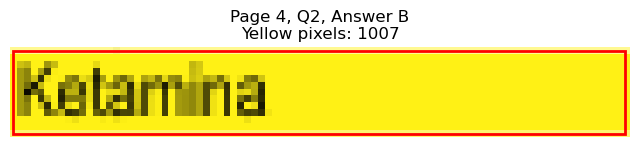

Page 4, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=122.8, y1=229.7
Page 4, Q2, C: Yellow pixels: 89
Page 4, Q2, C: Total non-white pixels: 277
Page 4, Q2, C: Yellow percentage: 32.1%


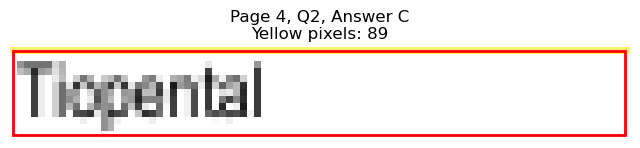

Page 4, Q2 - D: Detected box: x0=336.7, y0=193.4, x1=374.5, y1=205.5
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 178
Page 4, Q2, D: Yellow percentage: 0.0%


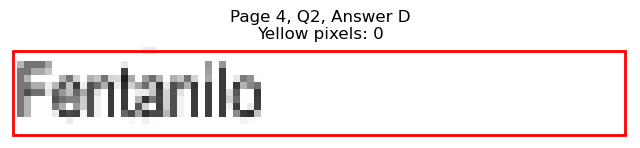

Page 4, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=380.7, y1=217.7
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 224
Page 4, Q2, E: Yellow percentage: 0.0%


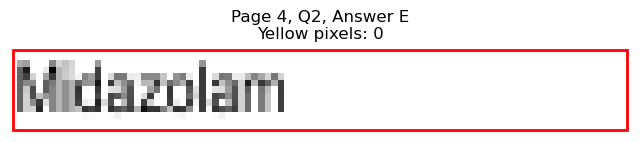


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=85.0, y0=253.7, x1=176.4, y1=265.8
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 471
Page 4, Q3, A: Yellow percentage: 0.0%


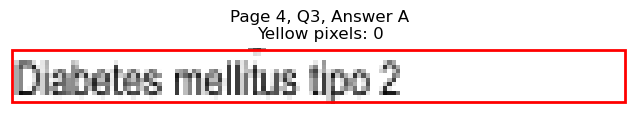

Page 4, Q3 - B: Detected box: x0=85.0, y0=265.8, x1=156.3, y1=277.9
Page 4, Q3, B: Yellow pixels: 1171
Page 4, Q3, B: Total non-white pixels: 1599
Page 4, Q3, B: Yellow percentage: 73.2%


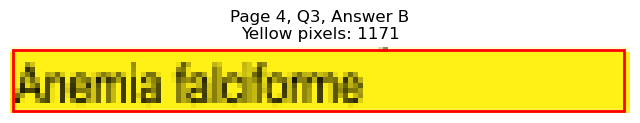

Page 4, Q3 - C: Detected box: x0=85.0, y0=277.8, x1=121.3, y1=289.9
Page 4, Q3, C: Yellow pixels: 88
Page 4, Q3, C: Total non-white pixels: 267
Page 4, Q3, C: Yellow percentage: 33.0%


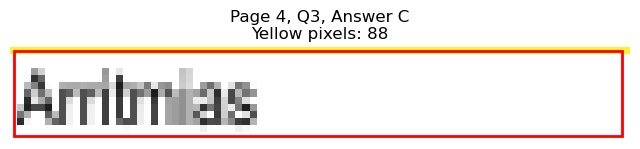

Page 4, Q3 - D: Detected box: x0=336.7, y0=253.7, x1=390.3, y1=265.8
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 287
Page 4, Q3, D: Yellow percentage: 0.0%


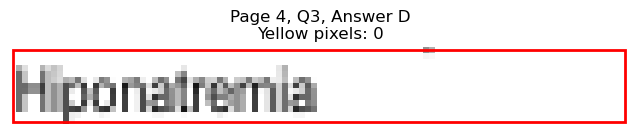

Page 4, Q3 - E: Detected box: x0=336.7, y0=265.8, x1=408.9, y1=277.9
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 388
Page 4, Q3, E: Yellow percentage: 0.0%


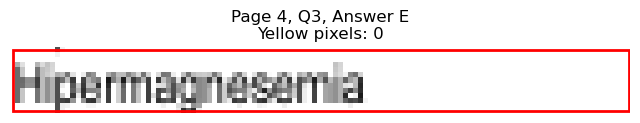


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=85.0, y0=313.9, x1=193.9, y1=326.0
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 544
Page 4, Q4, A: Yellow percentage: 0.0%


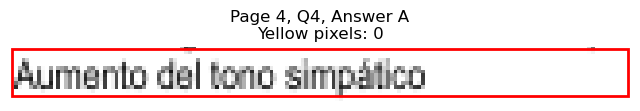

Page 4, Q4 - B: Detected box: x0=85.0, y0=326.1, x1=249.2, y1=338.2
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 836
Page 4, Q4, B: Yellow percentage: 0.0%


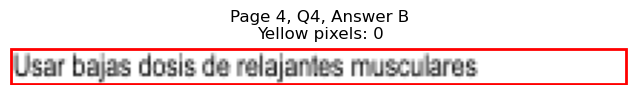

Page 4, Q4 - C: Detected box: x0=85.0, y0=338.1, x1=229.5, y1=350.2
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 709
Page 4, Q4, C: Yellow percentage: 0.0%


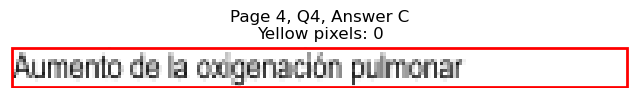

Page 4, Q4 - D: Detected box: x0=336.7, y0=313.9, x1=477.5, y1=326.0
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 753
Page 4, Q4, D: Yellow percentage: 0.0%


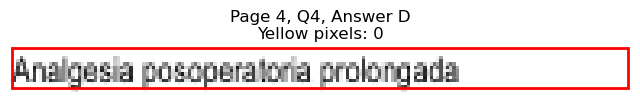

Page 4, Q4 - E: Detected box: x0=336.7, y0=326.1, x1=455.4, y1=338.2
Page 4, Q4, E: Yellow pixels: 1512
Page 4, Q4, E: Total non-white pixels: 2210
Page 4, Q4, E: Yellow percentage: 68.4%


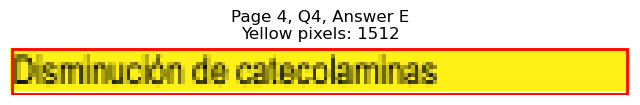


Page 4, Q4 - Selected Answer: E (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=85.0, y0=374.2, x1=107.5, y1=386.3
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 115
Page 4, Q5, A: Yellow percentage: 0.0%


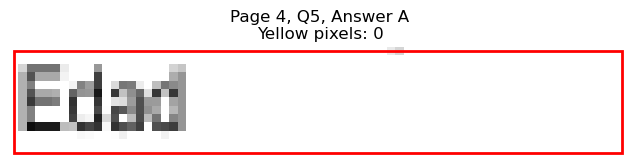

Page 4, Q5 - B: Detected box: x0=85.0, y0=386.3, x1=137.7, y1=398.4
Page 4, Q5, B: Yellow pixels: 1005
Page 4, Q5, B: Total non-white pixels: 1352
Page 4, Q5, B: Yellow percentage: 74.3%


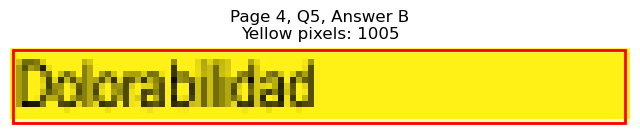

Page 4, Q5 - C: Detected box: x0=85.0, y0=398.3, x1=180.7, y1=410.4
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 649
Page 4, Q5, C: Yellow percentage: 0.0%


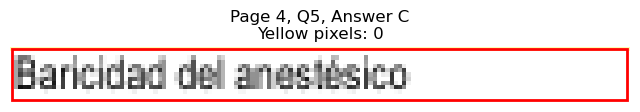

Page 4, Q5 - D: Detected box: x0=336.7, y0=374.2, x1=418.0, y1=386.3
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 424
Page 4, Q5, D: Yellow percentage: 0.0%


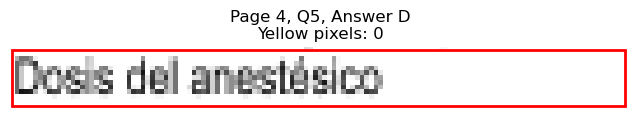

Page 4, Q5 - E: Detected box: x0=336.7, y0=386.3, x1=378.3, y1=398.4
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 207
Page 4, Q5, E: Yellow percentage: 0.0%


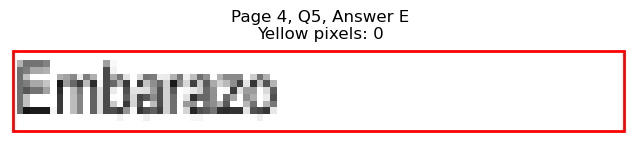


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=85.0, y0=434.4, x1=288.4, y1=446.5
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 1040
Page 4, Q6, A: Yellow percentage: 0.0%


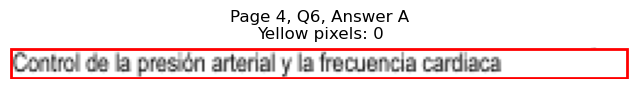

Page 4, Q6 - B: Detected box: x0=85.0, y0=446.6, x1=152.1, y1=458.7
Page 4, Q6, B: Yellow pixels: 119
Page 4, Q6, B: Total non-white pixels: 503
Page 4, Q6, B: Yellow percentage: 23.7%


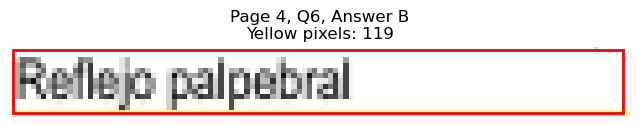

Page 4, Q6 - C: Detected box: x0=85.0, y0=458.6, x1=292.3, y1=470.7
Page 4, Q6, C: Yellow pixels: 2504
Page 4, Q6, C: Total non-white pixels: 3367
Page 4, Q6, C: Yellow percentage: 74.4%


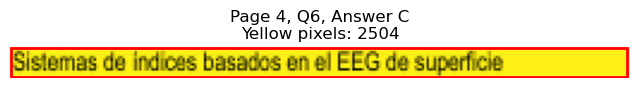

Page 4, Q6 - D: Detected box: x0=85.0, y0=470.7, x1=135.7, y1=482.8
Page 4, Q6, D: Yellow pixels: 102
Page 4, Q6, D: Total non-white pixels: 359
Page 4, Q6, D: Yellow percentage: 28.4%


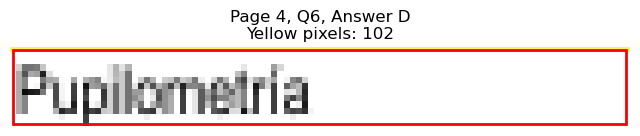

Page 4, Q6 - E: Detected box: x0=85.0, y0=482.7, x1=221.5, y1=494.8
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 712
Page 4, Q6, E: Yellow percentage: 0.0%


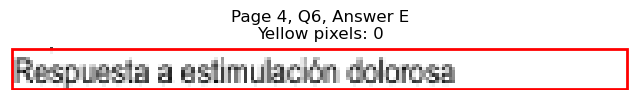


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=85.0, y0=518.8, x1=106.9, y1=530.9
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 123
Page 4, Q7, A: Yellow percentage: 0.0%


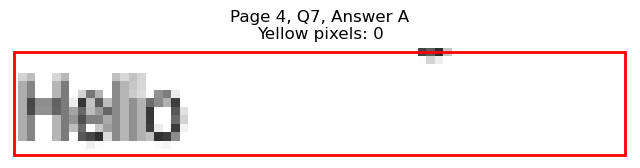

Page 4, Q7 - B: Detected box: x0=85.0, y0=530.9, x1=120.4, y1=543.0
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 173
Page 4, Q7, B: Yellow percentage: 0.0%


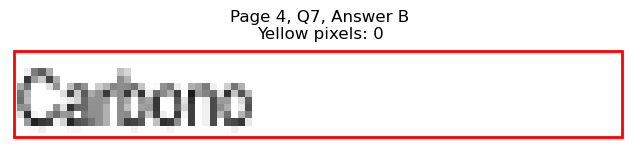

Page 4, Q7 - C: Detected box: x0=85.0, y0=542.9, x1=132.4, y1=555.0
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 251
Page 4, Q7, C: Yellow percentage: 0.0%


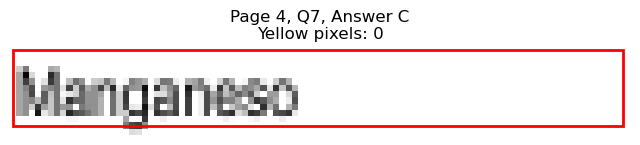

Page 4, Q7 - D: Detected box: x0=336.7, y0=518.8, x1=358.6, y1=530.9
Page 4, Q7, D: Yellow pixels: 792
Page 4, Q7, D: Total non-white pixels: 949
Page 4, Q7, D: Yellow percentage: 83.5%


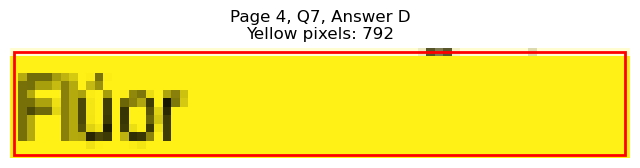

Page 4, Q7 - E: Detected box: x0=336.7, y0=530.9, x1=363.0, y1=543.0
Page 4, Q7, E: Yellow pixels: 77
Page 4, Q7, E: Total non-white pixels: 211
Page 4, Q7, E: Yellow percentage: 36.5%


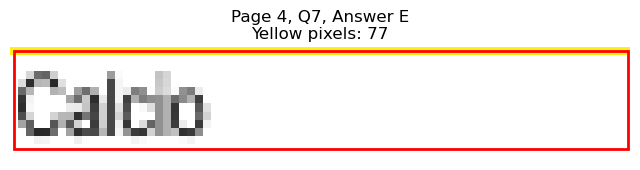


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=85.0, y0=579.1, x1=201.8, y1=591.2
Page 4, Q8, A: Yellow pixels: 1533
Page 4, Q8, A: Total non-white pixels: 2184
Page 4, Q8, A: Yellow percentage: 70.2%


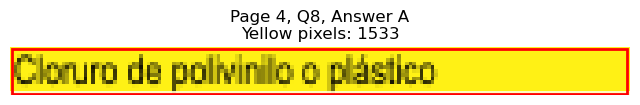

Page 4, Q8 - B: Detected box: x0=85.0, y0=591.2, x1=108.4, y1=603.3
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 210
Page 4, Q8, B: Yellow percentage: 0.0%


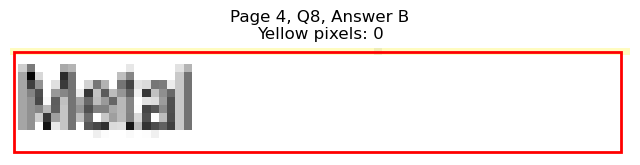

Page 4, Q8 - C: Detected box: x0=85.0, y0=603.2, x1=117.0, y1=615.3
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 161
Page 4, Q8, C: Yellow percentage: 0.0%


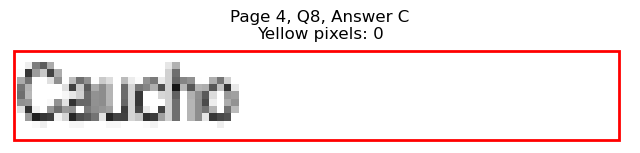

Page 4, Q8 - D: Detected box: x0=336.7, y0=579.1, x1=356.8, y1=591.2
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 103
Page 4, Q8, D: Yellow percentage: 0.0%


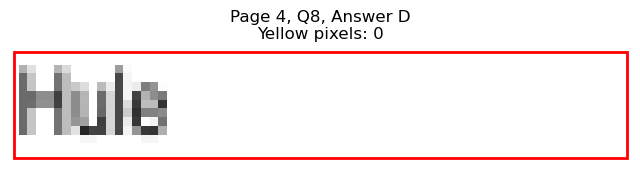

Page 4, Q8 - E: Detected box: x0=336.7, y0=591.2, x1=378.9, y1=603.3
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 234
Page 4, Q8, E: Yellow percentage: 0.0%


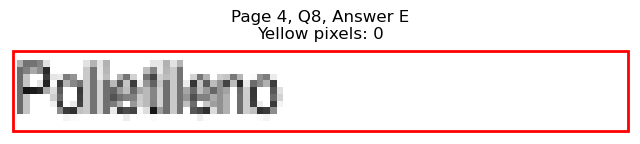


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=85.0, y0=639.3, x1=170.2, y1=651.4
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 433
Page 4, Q9, A: Yellow percentage: 0.0%


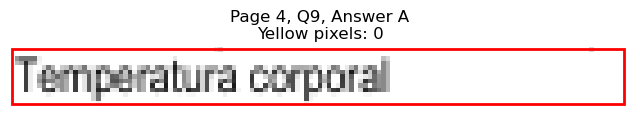

Page 4, Q9 - B: Detected box: x0=85.0, y0=651.4, x1=144.4, y1=663.5
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 300
Page 4, Q9, B: Yellow percentage: 0.0%


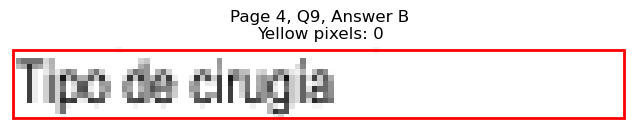

Page 4, Q9 - C: Detected box: x0=85.0, y0=663.4, x1=107.1, y1=675.5
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 109
Page 4, Q9, C: Yellow percentage: 0.0%


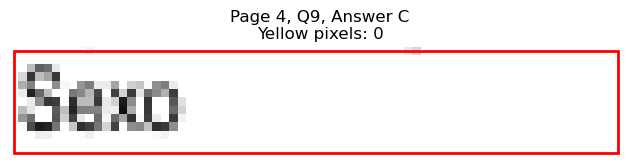

Page 4, Q9 - D: Detected box: x0=336.7, y0=639.3, x1=431.0, y1=651.4
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 473
Page 4, Q9, D: Yellow percentage: 0.0%


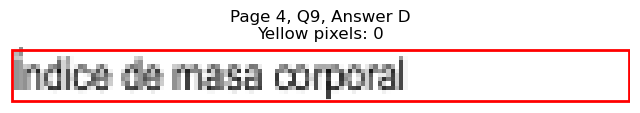

Page 4, Q9 - E: Detected box: x0=336.7, y0=651.4, x1=372.6, y1=663.5
Page 4, Q9, E: Yellow pixels: 998
Page 4, Q9, E: Total non-white pixels: 1131
Page 4, Q9, E: Yellow percentage: 88.2%


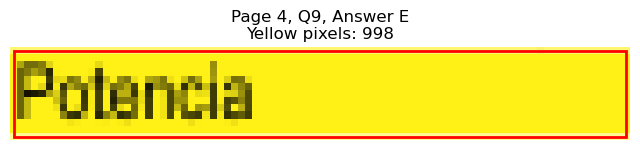


Page 4, Q9 - Selected Answer: E (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=85.0, y0=711.7, x1=138.6, y1=723.8
Page 4, Q10, A: Yellow pixels: 1065
Page 4, Q10, A: Total non-white pixels: 1365
Page 4, Q10, A: Yellow percentage: 78.0%


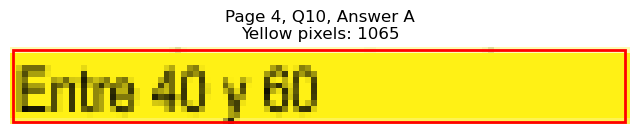

Page 4, Q10 - B: Detected box: x0=85.0, y0=723.7, x1=138.6, y1=735.8
Page 4, Q10, B: Yellow pixels: 103
Page 4, Q10, B: Total non-white pixels: 346
Page 4, Q10, B: Yellow percentage: 29.8%


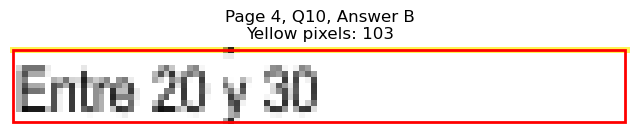

Page 4, Q10 - C: Detected box: x0=85.0, y0=735.8, x1=138.6, y1=747.9
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 242
Page 4, Q10, C: Yellow percentage: 0.0%


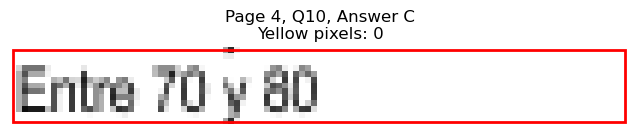

Page 4, Q10 - D: Detected box: x0=336.7, y0=711.7, x1=390.3, y1=723.8
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 247
Page 4, Q10, D: Yellow percentage: 0.0%


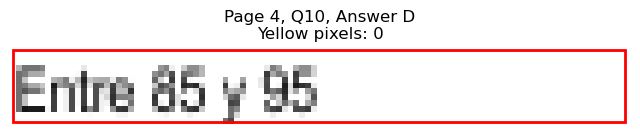

Page 4, Q10 - E: Detected box: x0=336.7, y0=723.7, x1=351.1, y1=735.8
Page 4, Q10, E: Yellow pixels: 0
Page 4, Q10, E: Total non-white pixels: 75
Page 4, Q10, E: Yellow percentage: 0.0%


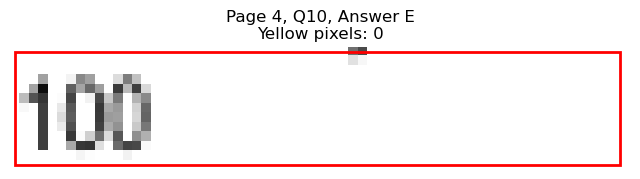


Page 4, Q10 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=116.1, y1=121.3
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 177
Page 5, Q1, A: Yellow percentage: 0.0%


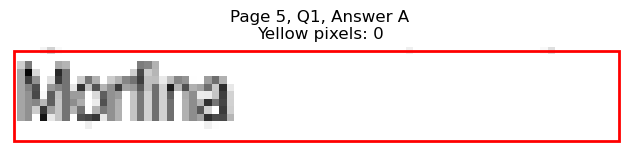

Page 5, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=136.7, y1=133.3
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 261
Page 5, Q1, B: Yellow percentage: 0.0%


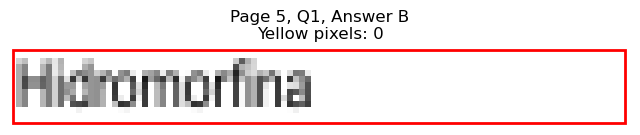

Page 5, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=130.0, y1=145.3
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 249
Page 5, Q1, C: Yellow percentage: 0.0%


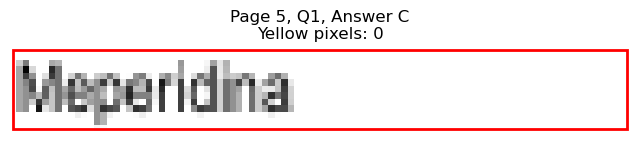

Page 5, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=374.5, y1=121.3
Page 5, Q1, D: Yellow pixels: 919
Page 5, Q1, D: Total non-white pixels: 1157
Page 5, Q1, D: Yellow percentage: 79.4%


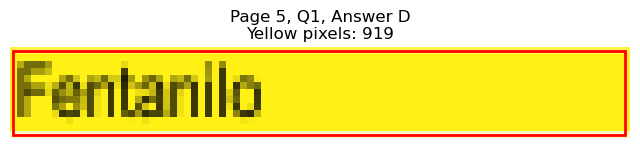

Page 5, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=384.1, y1=133.3
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 359
Page 5, Q1, E: Yellow percentage: 0.0%


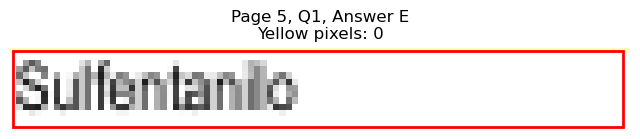


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=131.4, y1=205.5
Page 5, Q2, A: Yellow pixels: 1076
Page 5, Q2, A: Total non-white pixels: 1274
Page 5, Q2, A: Yellow percentage: 84.5%


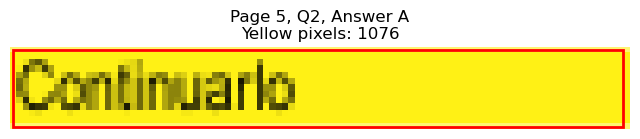

Page 5, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=126.6, y1=217.7
Page 5, Q2, B: Yellow pixels: 93
Page 5, Q2, B: Total non-white pixels: 309
Page 5, Q2, B: Yellow percentage: 30.1%


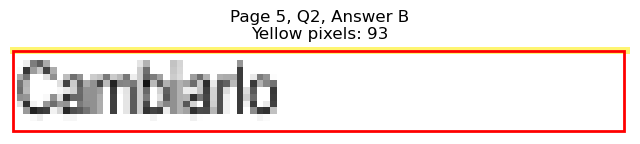

Page 5, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=135.7, y1=229.7
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 266
Page 5, Q2, C: Yellow percentage: 0.0%


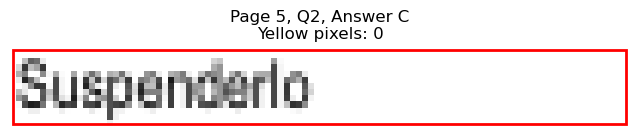

Page 5, Q2 - D: Detected box: x0=336.7, y0=193.4, x1=391.8, y1=205.5
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 290
Page 5, Q2, D: Yellow percentage: 0.0%


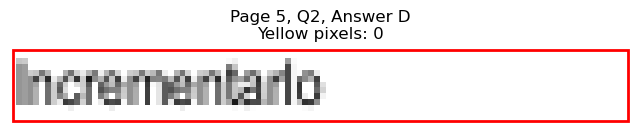

Page 5, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=404.6, y1=217.7
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 343
Page 5, Q2, E: Yellow percentage: 0.0%


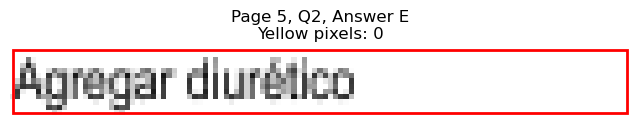


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=85.0, y0=253.7, x1=111.7, y1=265.8
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 145
Page 5, Q3, A: Yellow percentage: 0.0%


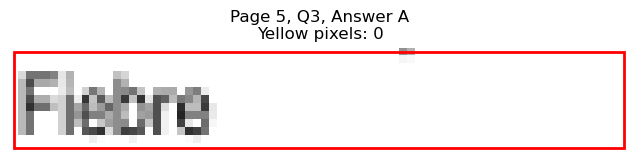

Page 5, Q3 - B: Detected box: x0=85.0, y0=265.8, x1=149.7, y1=277.9
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 353
Page 5, Q3, B: Yellow percentage: 0.0%


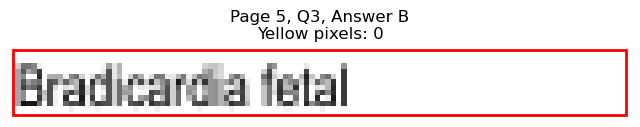

Page 5, Q3 - C: Detected box: x0=85.0, y0=277.8, x1=140.5, y1=289.9
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 280
Page 5, Q3, C: Yellow percentage: 0.0%


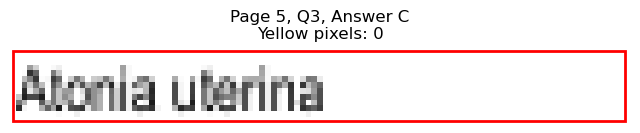

Page 5, Q3 - D: Detected box: x0=336.7, y0=253.7, x1=405.1, y1=265.8
Page 5, Q3, D: Yellow pixels: 1162
Page 5, Q3, D: Total non-white pixels: 1560
Page 5, Q3, D: Yellow percentage: 74.5%


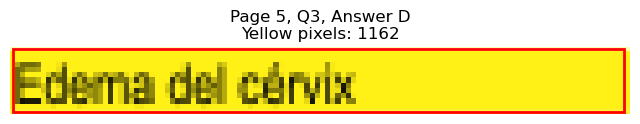

Page 5, Q3 - E: Detected box: x0=336.7, y0=265.8, x1=404.6, y1=277.9
Page 5, Q3, E: Yellow pixels: 119
Page 5, Q3, E: Total non-white pixels: 461
Page 5, Q3, E: Yellow percentage: 25.8%


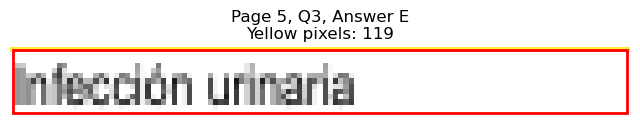


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=85.0, y0=313.9, x1=121.8, y1=326.0
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 206
Page 5, Q4, A: Yellow percentage: 0.0%


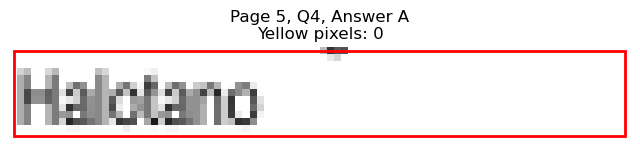

Page 5, Q4 - B: Detected box: x0=85.0, y0=326.1, x1=125.2, y1=338.2
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 207
Page 5, Q4, B: Yellow percentage: 0.0%


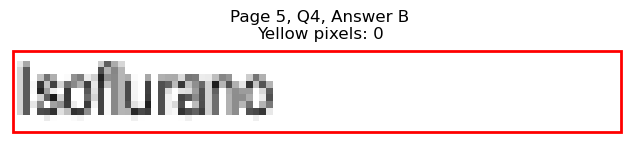

Page 5, Q4 - C: Detected box: x0=85.0, y0=338.1, x1=124.2, y1=350.2
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 198
Page 5, Q4, C: Yellow percentage: 0.0%


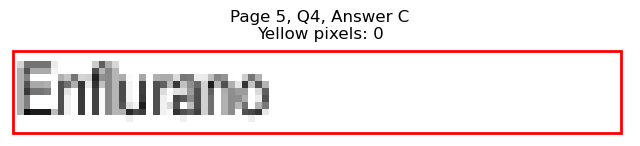

Page 5, Q4 - D: Detected box: x0=336.7, y0=313.9, x1=389.8, y1=326.0
Page 5, Q4, D: Yellow pixels: 1060
Page 5, Q4, D: Total non-white pixels: 1456
Page 5, Q4, D: Yellow percentage: 72.8%


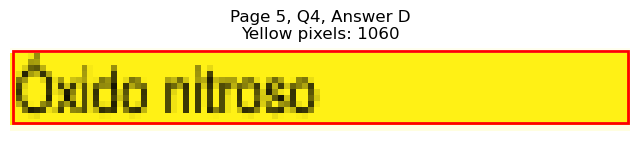

Page 5, Q4 - E: Detected box: x0=336.7, y0=326.1, x1=375.9, y1=338.2
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 282
Page 5, Q4, E: Yellow percentage: 0.0%


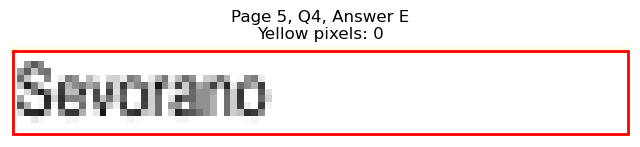


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=85.0, y0=374.2, x1=163.9, y1=386.3
Page 5, Q5, A: Yellow pixels: 1262
Page 5, Q5, A: Total non-white pixels: 1690
Page 5, Q5, A: Yellow percentage: 74.7%


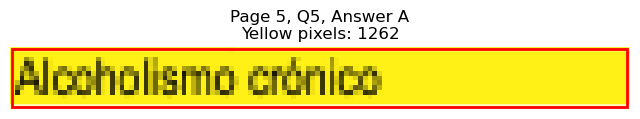

Page 5, Q5 - B: Detected box: x0=85.0, y0=386.3, x1=129.0, y1=398.4
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 343
Page 5, Q5, B: Yellow percentage: 0.0%


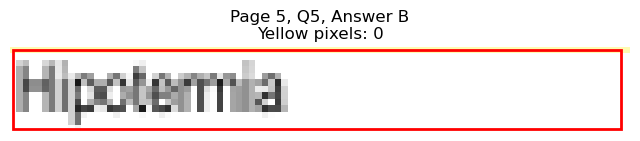

Page 5, Q5 - C: Detected box: x0=85.0, y0=398.3, x1=124.3, y1=410.4
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 214
Page 5, Q5, C: Yellow percentage: 0.0%


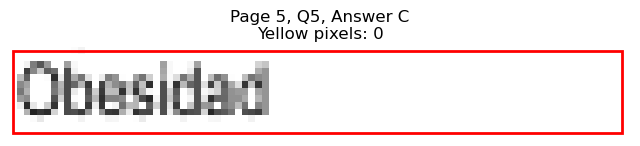

Page 5, Q5 - D: Detected box: x0=336.7, y0=374.2, x1=378.3, y1=386.3
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 207
Page 5, Q5, D: Yellow percentage: 0.0%


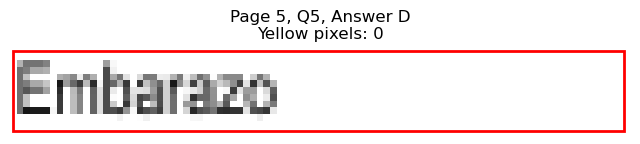

Page 5, Q5 - E: Detected box: x0=336.7, y0=386.3, x1=416.1, y1=398.4
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 417
Page 5, Q5, E: Yellow percentage: 0.0%


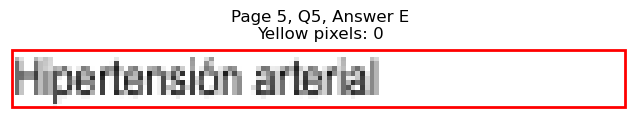


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=85.0, y0=434.4, x1=230.9, y1=446.5
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 760
Page 5, Q6, A: Yellow percentage: 0.0%


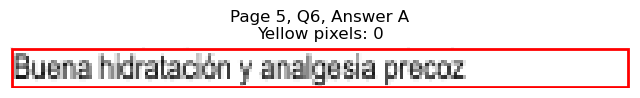

Page 5, Q6 - B: Detected box: x0=85.0, y0=446.6, x1=152.1, y1=458.7
Page 5, Q6, B: Yellow pixels: 1292
Page 5, Q6, B: Total non-white pixels: 1547
Page 5, Q6, B: Yellow percentage: 83.5%


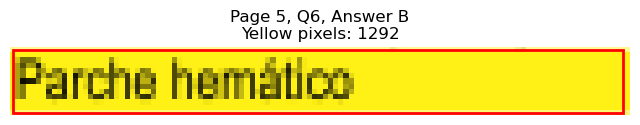

Page 5, Q6 - C: Detected box: x0=141.6, y0=458.6, x1=200.1, y1=470.7
Page 5, Q6, C: Yellow pixels: 110
Page 5, Q6, C: Total non-white pixels: 635
Page 5, Q6, C: Yellow percentage: 17.3%


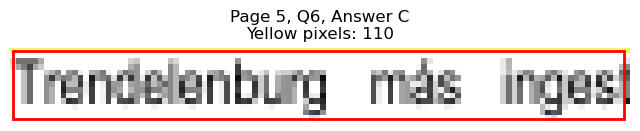

Page 5, Q6 - D: Detected box: x0=336.7, y0=434.4, x1=435.8, y1=446.5
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 528
Page 5, Q6, D: Yellow percentage: 0.0%


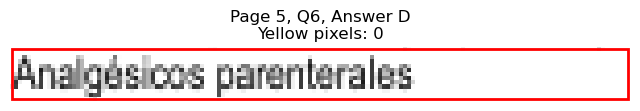

Page 5, Q6 - E: Detected box: x0=336.7, y0=446.6, x1=373.0, y1=458.7
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 193
Page 5, Q6, E: Yellow percentage: 0.0%


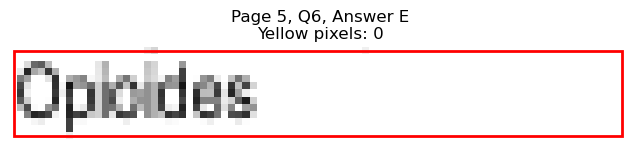


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=85.0, y0=506.8, x1=198.1, y1=518.9
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 574
Page 5, Q7, A: Yellow percentage: 0.0%


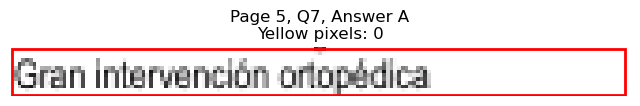

Page 5, Q7 - B: Detected box: x0=85.0, y0=518.8, x1=137.7, y1=530.9
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 274
Page 5, Q7, B: Yellow percentage: 0.0%


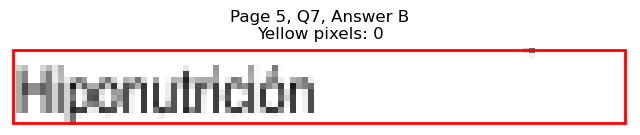

Page 5, Q7 - C: Detected box: x0=85.0, y0=530.9, x1=129.0, y1=543.0
Page 5, Q7, C: Yellow pixels: 967
Page 5, Q7, C: Total non-white pixels: 1250
Page 5, Q7, C: Yellow percentage: 77.4%


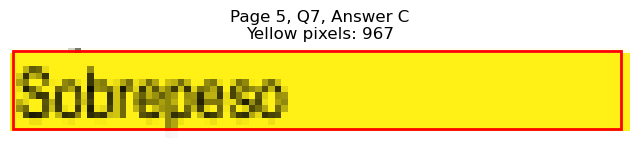

Page 5, Q7 - D: Detected box: x0=336.7, y0=506.8, x1=429.6, y1=518.9
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 492
Page 5, Q7, D: Yellow percentage: 0.0%


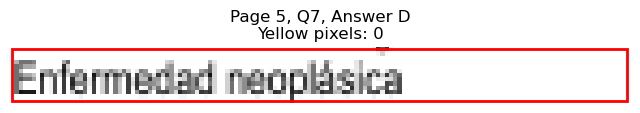

Page 5, Q7 - E: Detected box: x0=336.7, y0=518.8, x1=381.7, y1=530.9
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 228
Page 5, Q7, E: Yellow percentage: 0.0%


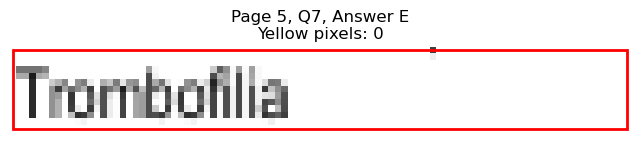


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=85.0, y0=579.1, x1=139.6, y1=591.2
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 296
Page 5, Q8, A: Yellow percentage: 0.0%


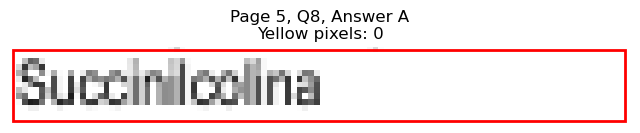

Page 5, Q8 - B: Detected box: x0=85.0, y0=591.2, x1=130.9, y1=603.3
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 216
Page 5, Q8, B: Yellow percentage: 0.0%


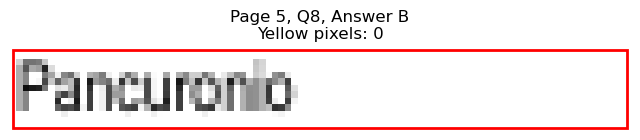

Page 5, Q8 - C: Detected box: x0=85.0, y0=603.2, x1=126.1, y1=615.3
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 196
Page 5, Q8, C: Yellow percentage: 0.0%


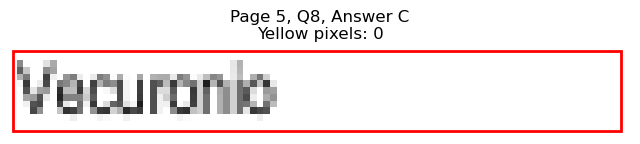

Page 5, Q8 - D: Detected box: x0=336.7, y0=579.1, x1=378.3, y1=591.2
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 208
Page 5, Q8, D: Yellow percentage: 0.0%


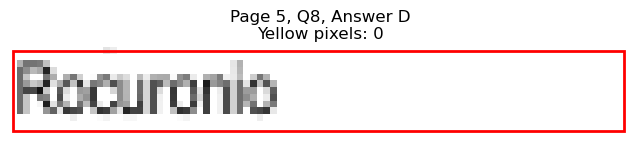

Page 5, Q8 - E: Detected box: x0=336.7, y0=591.2, x1=373.5, y1=603.3
Page 5, Q8, E: Yellow pixels: 932
Page 5, Q8, E: Total non-white pixels: 1144
Page 5, Q8, E: Yellow percentage: 81.5%


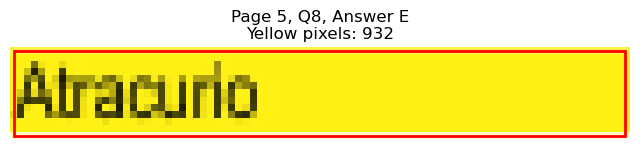


Page 5, Q8 - Selected Answer: E (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=119.4, y1=675.5
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 184
Page 5, Q9, A: Yellow percentage: 0.0%


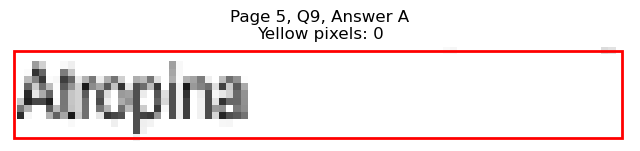

Page 5, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=147.7, y1=687.5
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 309
Page 5, Q9, B: Yellow percentage: 0.0%


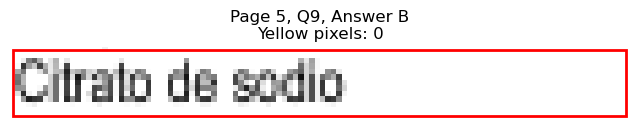

Page 5, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=123.3, y1=699.7
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 196
Page 5, Q9, C: Yellow percentage: 0.0%


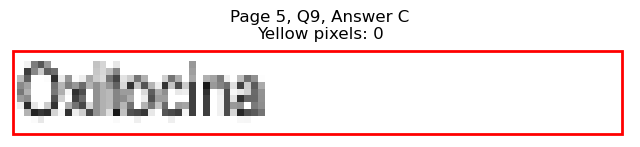

Page 5, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=379.8, y1=675.5
Page 5, Q9, D: Yellow pixels: 94
Page 5, Q9, D: Total non-white pixels: 329
Page 5, Q9, D: Yellow percentage: 28.6%


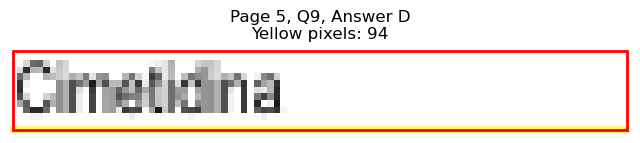

Page 5, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=400.4, y1=687.5
Page 5, Q9, E: Yellow pixels: 1206
Page 5, Q9, E: Total non-white pixels: 1495
Page 5, Q9, E: Yellow percentage: 80.7%


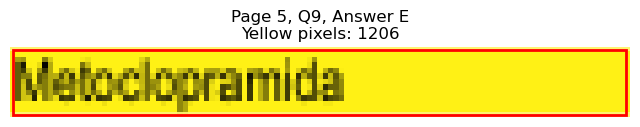


Page 5, Q9 - Selected Answer: E (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=85.0, y0=723.7, x1=126.1, y1=735.8
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 224
Page 5, Q10, A: Yellow percentage: 0.0%


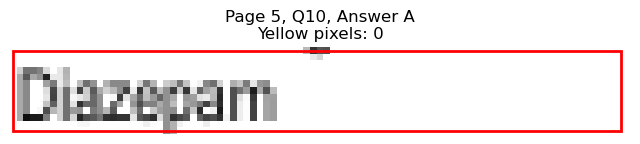

Page 5, Q10 - B: Detected box: x0=85.0, y0=735.8, x1=129.0, y1=747.9
Page 5, Q10, B: Yellow pixels: 955
Page 5, Q10, B: Total non-white pixels: 1248
Page 5, Q10, B: Yellow percentage: 76.5%


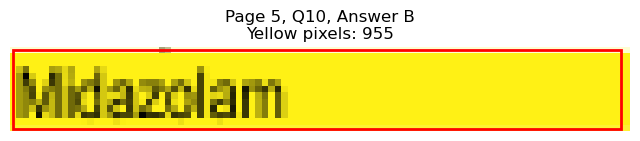

Page 5, Q10 - C: Detected box: x0=85.0, y0=747.8, x1=133.8, y1=759.9
Page 5, Q10, C: Yellow pixels: 100
Page 5, Q10, C: Total non-white pixels: 356
Page 5, Q10, C: Yellow percentage: 28.1%


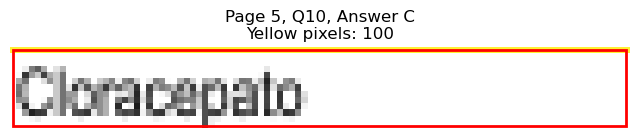

Page 5, Q10 - D: Detected box: x0=336.7, y0=723.7, x1=384.7, y1=735.8
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 240
Page 5, Q10, D: Yellow percentage: 0.0%


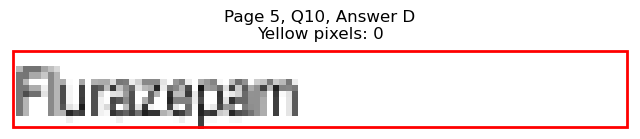

Page 5, Q10 - E: Detected box: x0=336.7, y0=735.8, x1=398.6, y1=747.9
Page 5, Q10, E: Yellow pixels: 0
Page 5, Q10, E: Total non-white pixels: 353
Page 5, Q10, E: Yellow percentage: 0.0%


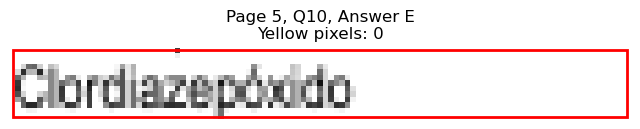


Page 5, Q10 - Selected Answer: B (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=125.2, y1=121.3
Page 6, Q1, A: Yellow pixels: 92
Page 6, Q1, A: Total non-white pixels: 302
Page 6, Q1, A: Yellow percentage: 30.5%


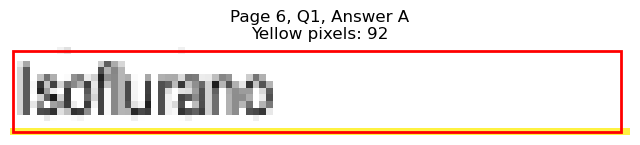

Page 6, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=133.3, y1=133.3
Page 6, Q1, B: Yellow pixels: 1007
Page 6, Q1, B: Total non-white pixels: 1300
Page 6, Q1, B: Yellow percentage: 77.5%


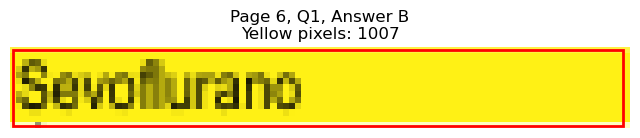

Page 6, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=138.1, y1=145.3
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 378
Page 6, Q1, C: Yellow percentage: 0.0%


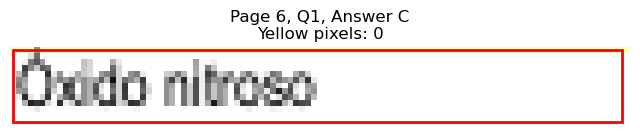

Page 6, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=378.3, y1=121.3
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 207
Page 6, Q1, D: Yellow percentage: 0.0%


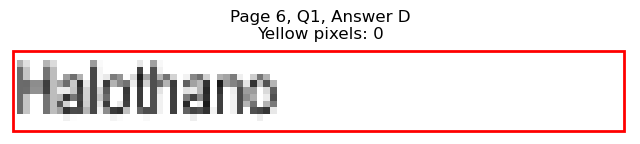

Page 6, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=380.7, y1=133.3
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 224
Page 6, Q1, E: Yellow percentage: 0.0%


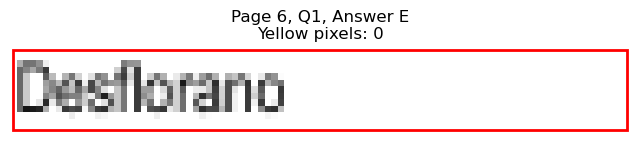


Page 6, Q1 - Selected Answer: B (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=188.4, y1=193.5
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 479
Page 6, Q2, A: Yellow percentage: 0.0%


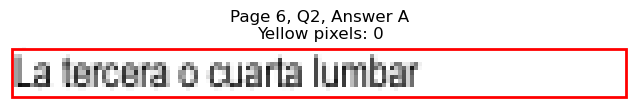

Page 6, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=168.7, y1=205.5
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 397
Page 6, Q2, B: Yellow percentage: 0.0%


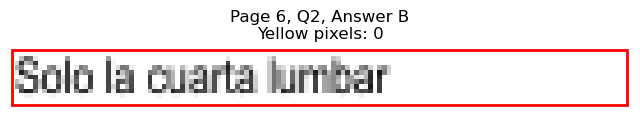

Page 6, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=151.6, y1=217.7
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 299
Page 6, Q2, C: Yellow percentage: 0.0%


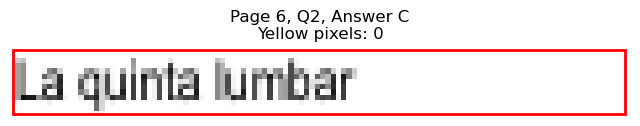

Page 6, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=403.6, y1=193.5
Page 6, Q2, D: Yellow pixels: 118
Page 6, Q2, D: Total non-white pixels: 431
Page 6, Q2, D: Yellow percentage: 27.4%


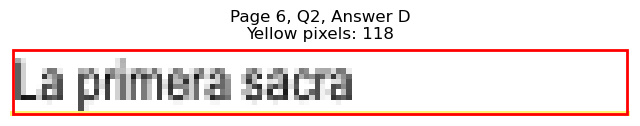

Page 6, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=451.5, y1=205.5
Page 6, Q2, E: Yellow pixels: 1689
Page 6, Q2, E: Total non-white pixels: 2158
Page 6, Q2, E: Yellow percentage: 78.3%


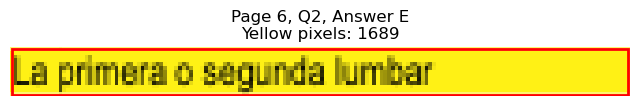


Page 6, Q2 - Selected Answer: E (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=108.0, y1=253.8
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 99
Page 6, Q3, A: Yellow percentage: 0.0%


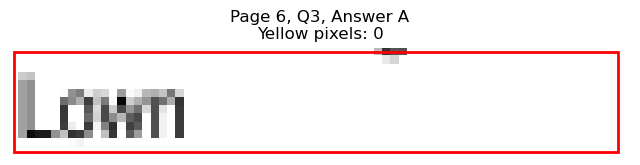

Page 6, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=122.3, y1=265.8
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 183
Page 6, Q3, B: Yellow percentage: 0.0%


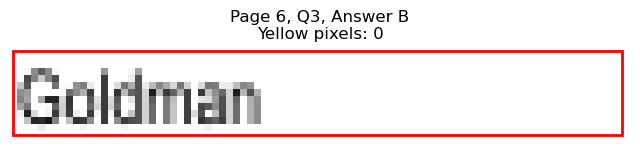

Page 6, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=123.7, y1=277.9
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 184
Page 6, Q3, C: Yellow percentage: 0.0%


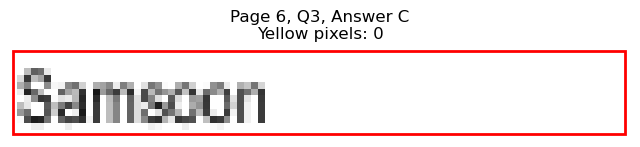

Page 6, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=399.3, y1=253.8
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 420
Page 6, Q3, D: Yellow percentage: 0.0%


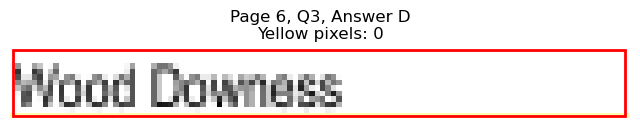

Page 6, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=386.0, y1=265.8
Page 6, Q3, E: Yellow pixels: 1003
Page 6, Q3, E: Total non-white pixels: 1300
Page 6, Q3, E: Yellow percentage: 77.2%


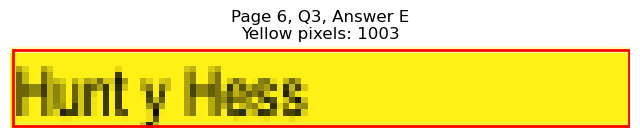


Page 6, Q3 - Selected Answer: E (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=85.0, y0=313.9, x1=134.8, y1=326.0
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 261
Page 6, Q4, A: Yellow percentage: 0.0%


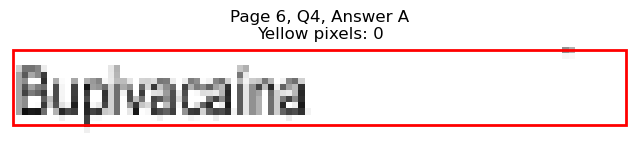

Page 6, Q4 - B: Detected box: x0=85.0, y0=326.1, x1=124.7, y1=338.2
Page 6, Q4, B: Yellow pixels: 948
Page 6, Q4, B: Total non-white pixels: 1183
Page 6, Q4, B: Yellow percentage: 80.1%


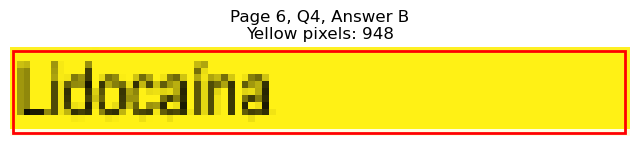

Page 6, Q4 - C: Detected box: x0=85.0, y0=338.1, x1=128.1, y1=350.2
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 331
Page 6, Q4, C: Yellow percentage: 0.0%


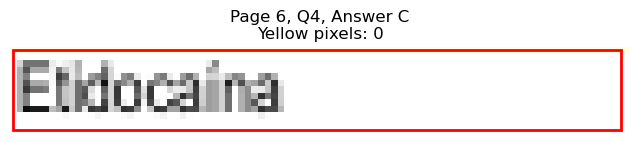

Page 6, Q4 - D: Detected box: x0=336.7, y0=313.9, x1=393.7, y1=326.0
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 274
Page 6, Q4, D: Yellow percentage: 0.0%


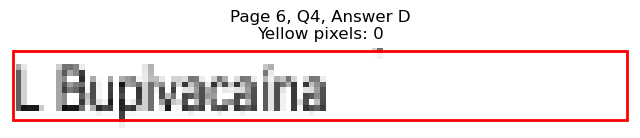

Page 6, Q4 - E: Detected box: x0=336.7, y0=326.1, x1=387.0, y1=338.2
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 261
Page 6, Q4, E: Yellow percentage: 0.0%


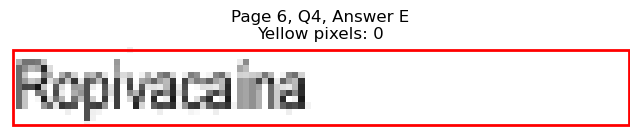


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=85.0, y0=374.2, x1=171.1, y1=386.3
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 474
Page 6, Q5, A: Yellow percentage: 0.0%


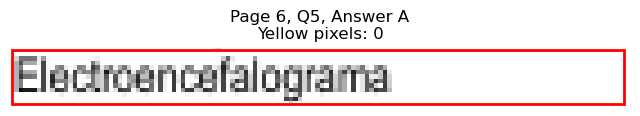

Page 6, Q5 - B: Detected box: x0=85.0, y0=386.3, x1=179.3, y1=398.4
Page 6, Q5, B: Yellow pixels: 1317
Page 6, Q5, B: Total non-white pixels: 1898
Page 6, Q5, B: Yellow percentage: 69.4%


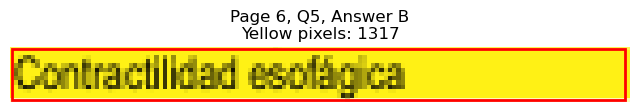

Page 6, Q5 - C: Detected box: x0=85.0, y0=398.3, x1=171.1, y1=410.4
Page 6, Q5, C: Yellow pixels: 1
Page 6, Q5, C: Total non-white pixels: 572
Page 6, Q5, C: Yellow percentage: 0.2%


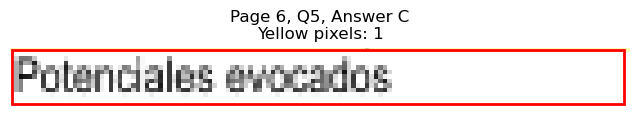

Page 6, Q5 - D: Detected box: x0=336.7, y0=374.2, x1=406.0, y1=386.3
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 391
Page 6, Q5, D: Yellow percentage: 0.0%


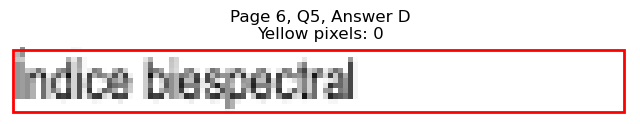

Page 6, Q5 - E: Detected box: x0=336.7, y0=386.3, x1=413.7, y1=398.4
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 406
Page 6, Q5, E: Yellow percentage: 0.0%


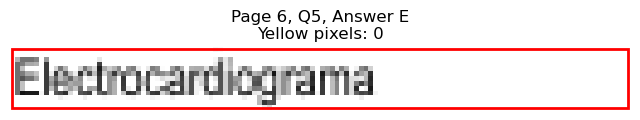


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=85.0, y0=458.6, x1=230.9, y1=470.7
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 732
Page 6, Q6, A: Yellow percentage: 0.0%


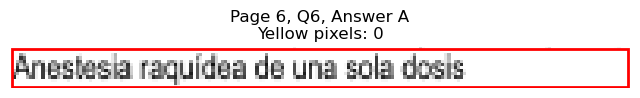

Page 6, Q6 - B: Detected box: x0=85.0, y0=470.7, x1=181.3, y1=482.8
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 644
Page 6, Q6, B: Yellow percentage: 0.0%


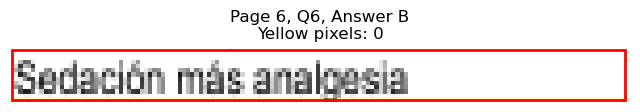

Page 6, Q6 - C: Detected box: x0=85.0, y0=482.7, x1=169.3, y1=494.8
Page 6, Q6, C: Yellow pixels: 1274
Page 6, Q6, C: Total non-white pixels: 1768
Page 6, Q6, C: Yellow percentage: 72.1%


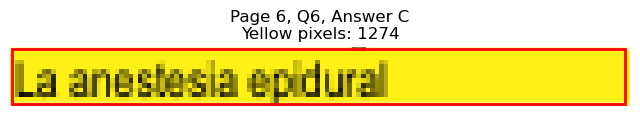

Page 6, Q6 - D: Detected box: x0=336.7, y0=458.6, x1=437.8, y1=470.7
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 492
Page 6, Q6, D: Yellow percentage: 0.0%


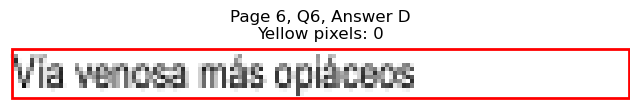

Page 6, Q6 - E: Detected box: x0=336.7, y0=470.7, x1=389.8, y1=482.8
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 478
Page 6, Q6, E: Yellow percentage: 0.0%


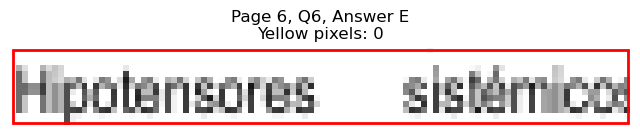


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=85.0, y0=530.9, x1=126.1, y1=543.0
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 196
Page 6, Q7, A: Yellow percentage: 0.0%


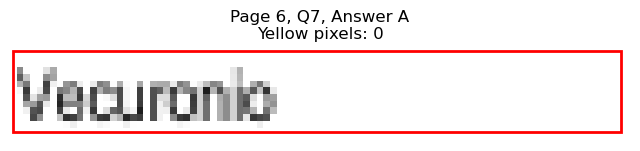

Page 6, Q7 - B: Detected box: x0=85.0, y0=542.9, x1=126.6, y1=555.0
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 203
Page 6, Q7, B: Yellow percentage: 0.0%


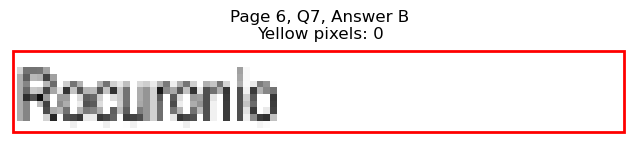

Page 6, Q7 - C: Detected box: x0=85.0, y0=554.9, x1=121.8, y1=567.0
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 184
Page 6, Q7, C: Yellow percentage: 0.0%


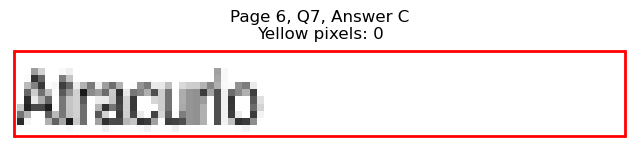

Page 6, Q7 - D: Detected box: x0=336.7, y0=530.9, x1=391.3, y1=543.0
Page 6, Q7, D: Yellow pixels: 1067
Page 6, Q7, D: Total non-white pixels: 1378
Page 6, Q7, D: Yellow percentage: 77.4%


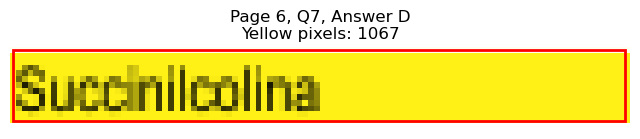

Page 6, Q7 - E: Detected box: x0=336.7, y0=542.9, x1=382.6, y1=555.0
Page 6, Q7, E: Yellow pixels: 97
Page 6, Q7, E: Total non-white pixels: 318
Page 6, Q7, E: Yellow percentage: 30.5%


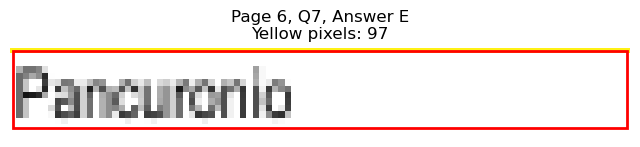


Page 6, Q7 - Selected Answer: D (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=85.0, y0=603.2, x1=129.0, y1=615.3
Page 6, Q8, A: Yellow pixels: 955
Page 6, Q8, A: Total non-white pixels: 1248
Page 6, Q8, A: Yellow percentage: 76.5%


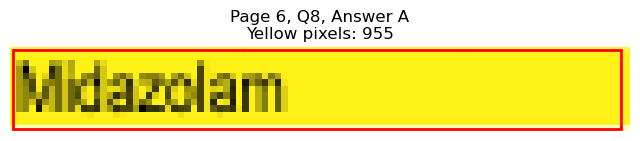

Page 6, Q8 - B: Detected box: x0=85.0, y0=615.2, x1=126.1, y1=627.3
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 313
Page 6, Q8, B: Yellow percentage: 0.0%


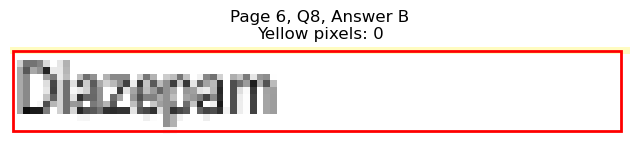

Page 6, Q8 - C: Detected box: x0=85.0, y0=627.3, x1=119.4, y1=639.4
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 176
Page 6, Q8, C: Yellow percentage: 0.0%


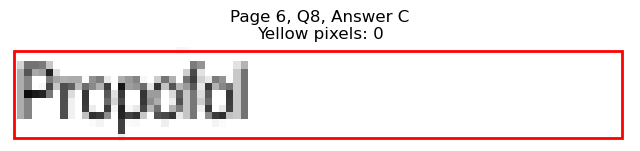

Page 6, Q8 - D: Detected box: x0=336.7, y0=603.2, x1=382.2, y1=615.3
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 226
Page 6, Q8, D: Yellow percentage: 0.0%


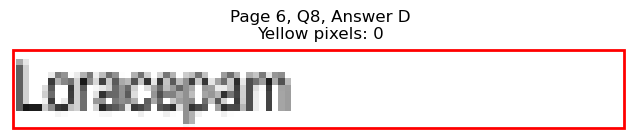

Page 6, Q8 - E: Detected box: x0=336.7, y0=615.2, x1=375.4, y1=627.3
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 202
Page 6, Q8, E: Yellow percentage: 0.0%


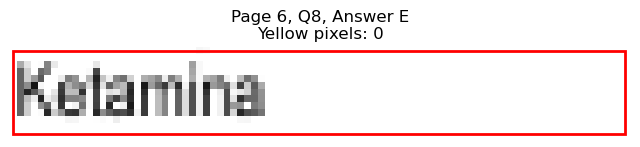


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=195.7, y1=675.5
Page 6, Q9, A: Yellow pixels: 1695
Page 6, Q9, A: Total non-white pixels: 2106
Page 6, Q9, A: Yellow percentage: 80.5%


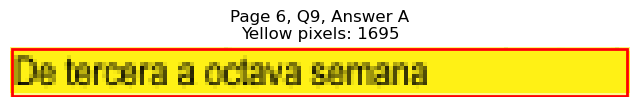

Page 6, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=131.4, y1=687.5
Page 6, Q9, B: Yellow pixels: 98
Page 6, Q9, B: Total non-white pixels: 307
Page 6, Q9, B: Yellow percentage: 31.9%


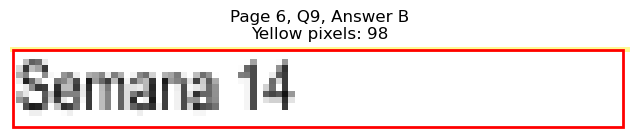

Page 6, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=131.4, y1=699.7
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 220
Page 6, Q9, C: Yellow percentage: 0.0%


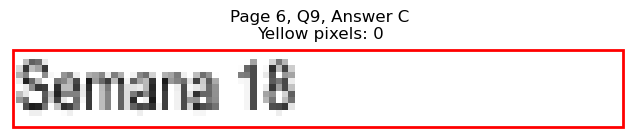

Page 6, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=383.1, y1=675.5
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 228
Page 6, Q9, D: Yellow percentage: 0.0%


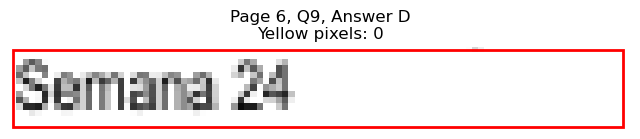

Page 6, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=383.1, y1=687.5
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 236
Page 6, Q9, E: Yellow percentage: 0.0%


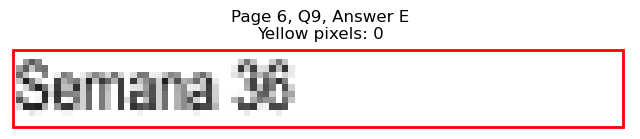


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=85.0, y0=723.7, x1=104.2, y1=735.8
Page 6, Q10, A: Yellow pixels: 770
Page 6, Q10, A: Total non-white pixels: 923
Page 6, Q10, A: Yellow percentage: 83.4%


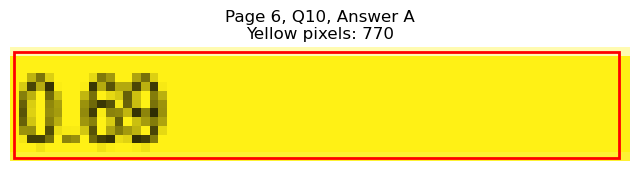

Page 6, Q10 - B: Detected box: x0=85.0, y0=735.8, x1=104.2, y1=747.9
Page 6, Q10, B: Yellow pixels: 71
Page 6, Q10, B: Total non-white pixels: 152
Page 6, Q10, B: Yellow percentage: 46.7%


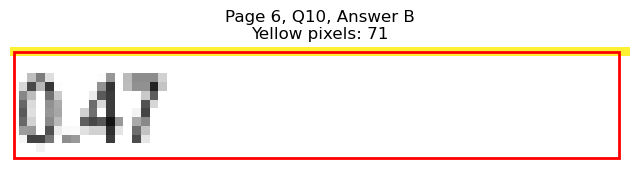

Page 6, Q10 - C: Detected box: x0=85.0, y0=747.8, x1=104.2, y1=759.9
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 84
Page 6, Q10, C: Yellow percentage: 0.0%


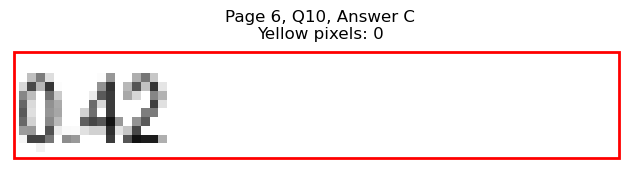

Page 6, Q10 - D: Detected box: x0=336.7, y0=723.7, x1=351.1, y1=735.8
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 57
Page 6, Q10, D: Yellow percentage: 0.0%


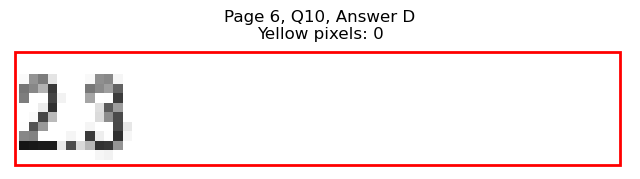

Page 6, Q10 - E: Detected box: x0=336.7, y0=735.8, x1=355.9, y1=747.9
Page 6, Q10, E: Yellow pixels: 0
Page 6, Q10, E: Total non-white pixels: 56
Page 6, Q10, E: Yellow percentage: 0.0%


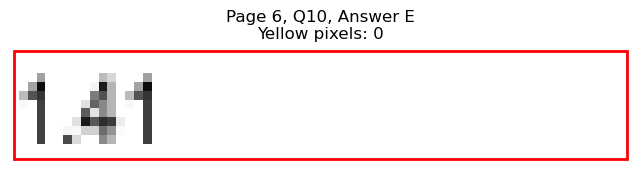


Page 6, Q10 - Selected Answer: A (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=104.2, y1=109.2
Page 7, Q1, A: Yellow pixels: 783
Page 7, Q1, A: Total non-white pixels: 923
Page 7, Q1, A: Yellow percentage: 84.8%


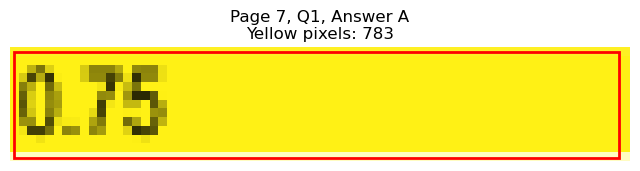

Page 7, Q1 - B: Detected box: x0=70.8, y0=109.2, x1=79.0, y1=121.3
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 123
Page 7, Q1, B: Yellow percentage: 0.0%


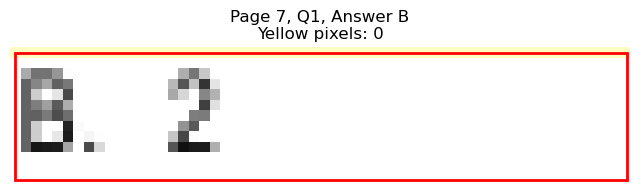

Page 7, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=99.4, y1=133.3
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 46
Page 7, Q1, C: Yellow percentage: 0.0%


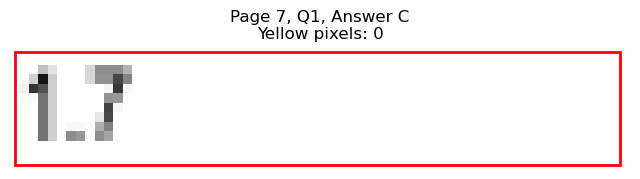

Page 7, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=351.1, y1=109.2
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 44
Page 7, Q1, D: Yellow percentage: 0.0%


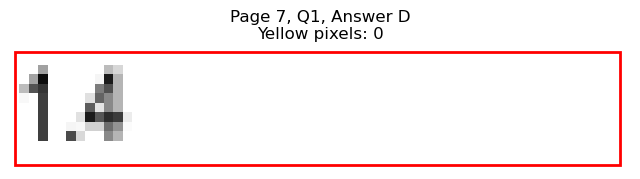

Page 7, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=353.5, y1=121.3
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 71
Page 7, Q1, E: Yellow percentage: 0.0%


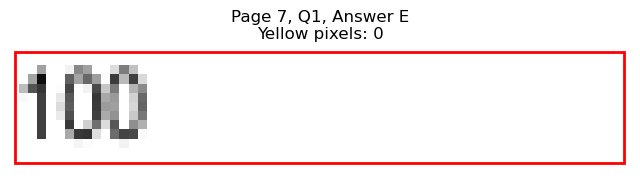


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=174.5, y1=169.4
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 448
Page 7, Q2, A: Yellow percentage: 0.0%


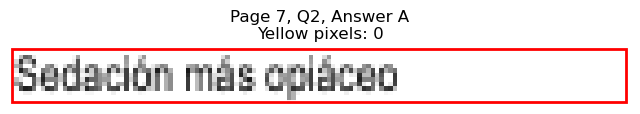

Page 7, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=206.2, y1=181.5
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 677
Page 7, Q2, B: Yellow percentage: 0.0%


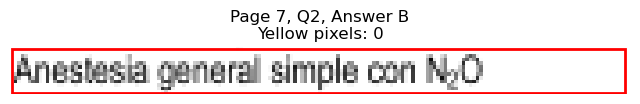

Page 7, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=261.7, y1=193.5
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 890
Page 7, Q2, C: Yellow percentage: 0.0%


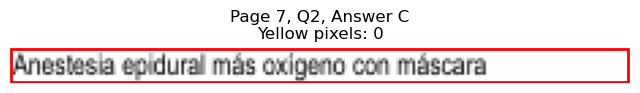

Page 7, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=444.0, y1=169.4
Page 7, Q2, D: Yellow pixels: 1636
Page 7, Q2, D: Total non-white pixels: 2054
Page 7, Q2, D: Yellow percentage: 79.6%


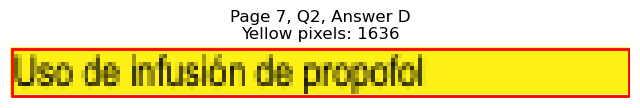

Page 7, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=509.5, y1=181.5
Page 7, Q2, E: Yellow pixels: 189
Page 7, Q2, E: Total non-white pixels: 1028
Page 7, Q2, E: Yellow percentage: 18.4%


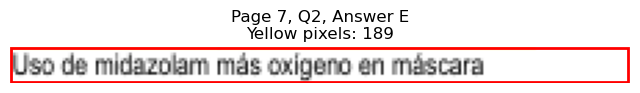


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=85.0, y0=217.5, x1=104.2, y1=229.7
Page 7, Q3, A: Yellow pixels: 858
Page 7, Q3, A: Total non-white pixels: 923
Page 7, Q3, A: Yellow percentage: 93.0%


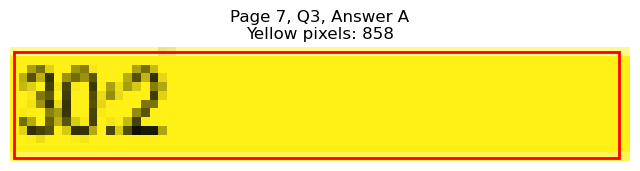

Page 7, Q3 - B: Detected box: x0=85.0, y0=229.7, x1=104.2, y1=241.8
Page 7, Q3, B: Yellow pixels: 71
Page 7, Q3, B: Total non-white pixels: 153
Page 7, Q3, B: Yellow percentage: 46.4%


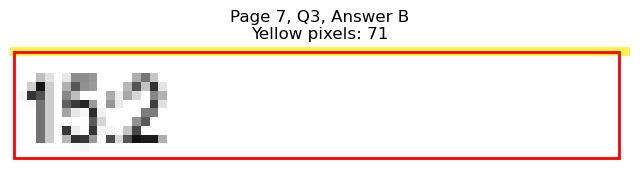

Page 7, Q3 - C: Detected box: x0=85.0, y0=241.7, x1=104.2, y1=253.8
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 85
Page 7, Q3, C: Yellow percentage: 0.0%


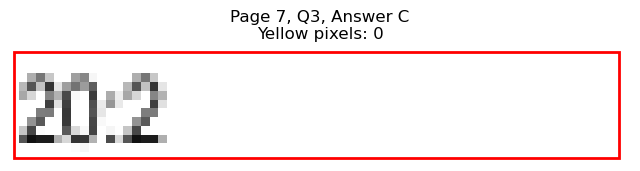

Page 7, Q3 - D: Detected box: x0=336.7, y0=217.5, x1=351.1, y1=229.7
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 33
Page 7, Q3, D: Yellow percentage: 0.0%


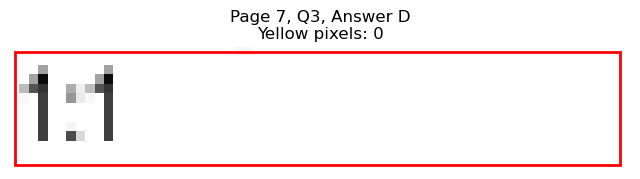

Page 7, Q3 - E: Detected box: x0=336.7, y0=229.7, x1=355.9, y1=241.8
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 81
Page 7, Q3, E: Yellow percentage: 0.0%


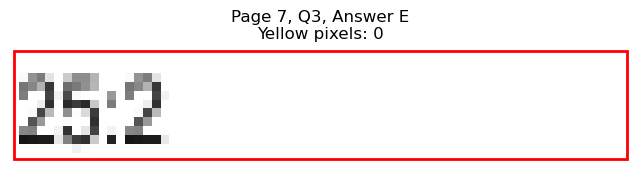


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=70.8, y0=289.9, x1=79.0, y1=302.0
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 58
Page 7, Q4, A: Yellow percentage: 0.0%


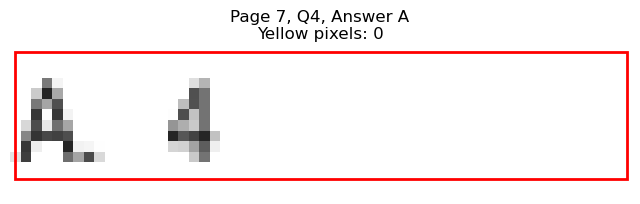

Page 7, Q4 - B: Detected box: x0=85.0, y0=301.9, x1=97.0, y1=314.0
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 44
Page 7, Q4, B: Yellow percentage: 0.0%


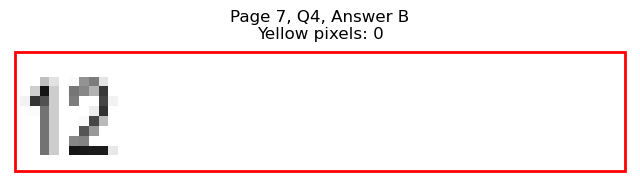

Page 7, Q4 - C: Detected box: x0=85.0, y0=313.9, x1=97.0, y1=326.0
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 49
Page 7, Q4, C: Yellow percentage: 0.0%


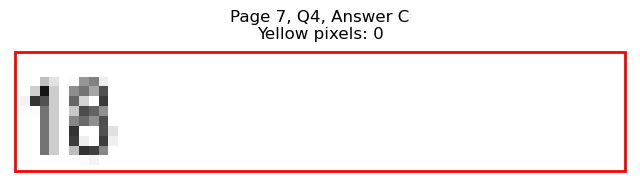

Page 7, Q4 - D: Detected box: x0=336.7, y0=289.9, x1=348.7, y1=302.0
Page 7, Q4, D: Yellow pixels: 63
Page 7, Q4, D: Total non-white pixels: 182
Page 7, Q4, D: Yellow percentage: 34.6%


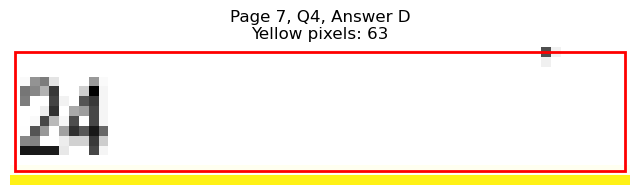

Page 7, Q4 - E: Detected box: x0=322.5, y0=301.9, x1=330.7, y1=314.0
Page 7, Q4, E: Yellow pixels: 661
Page 7, Q4, E: Total non-white pixels: 767
Page 7, Q4, E: Yellow percentage: 86.2%


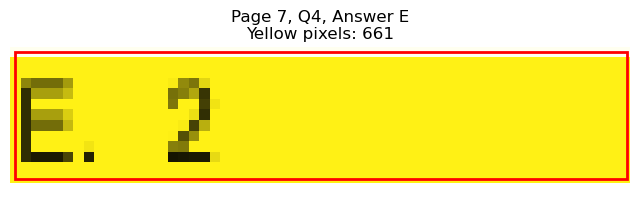


Page 7, Q4 - Selected Answer: E (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=85.0, y0=362.2, x1=150.1, y1=374.3
Page 7, Q5, A: Yellow pixels: 117
Page 7, Q5, A: Total non-white pixels: 463
Page 7, Q5, A: Yellow percentage: 25.3%


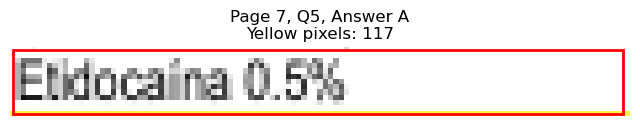

Page 7, Q5 - B: Detected box: x0=85.0, y0=374.2, x1=157.2, y1=386.3
Page 7, Q5, B: Yellow pixels: 1196
Page 7, Q5, B: Total non-white pixels: 1612
Page 7, Q5, B: Yellow percentage: 74.2%


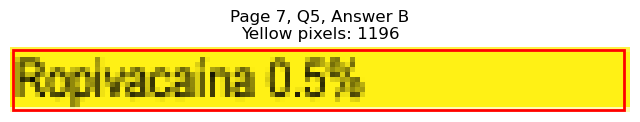

Page 7, Q5 - C: Detected box: x0=85.0, y0=386.3, x1=139.6, y1=398.4
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 364
Page 7, Q5, C: Yellow percentage: 0.0%


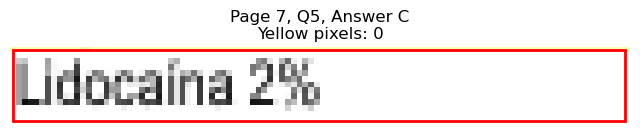

Page 7, Q5 - D: Detected box: x0=336.7, y0=362.2, x1=402.8, y1=374.3
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 330
Page 7, Q5, D: Yellow percentage: 0.0%


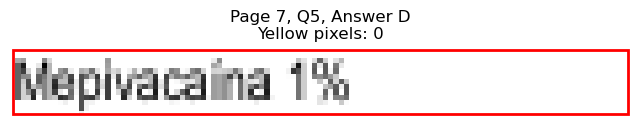

Page 7, Q5 - E: Detected box: x0=336.7, y0=374.2, x1=410.4, y1=386.3
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 364
Page 7, Q5, E: Yellow percentage: 0.0%


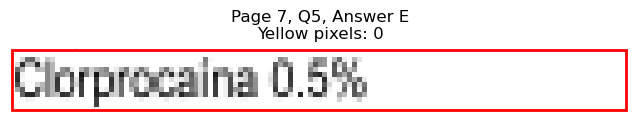


Page 7, Q5 - Selected Answer: B (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=85.0, y0=422.4, x1=237.7, y1=434.5
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 780
Page 7, Q6, A: Yellow percentage: 0.0%


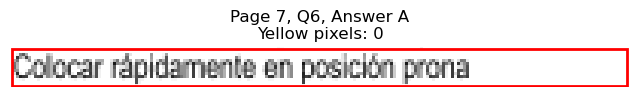

Page 7, Q6 - B: Detected box: x0=85.0, y0=434.4, x1=192.8, y1=446.5
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 543
Page 7, Q6, B: Yellow percentage: 0.0%


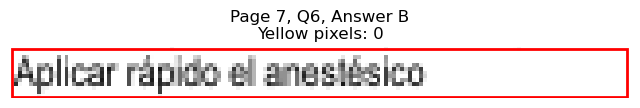

Page 7, Q6 - C: Detected box: x0=85.0, y0=446.6, x1=223.9, y1=458.7
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 706
Page 7, Q6, C: Yellow percentage: 0.0%


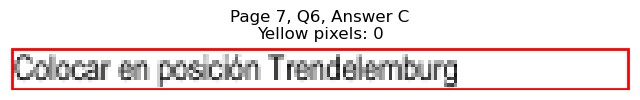

Page 7, Q6 - D: Detected box: x0=336.7, y0=422.4, x1=526.9, y1=434.5
Page 7, Q6, D: Yellow pixels: 1694
Page 7, Q6, D: Total non-white pixels: 2470
Page 7, Q6, D: Yellow percentage: 68.6%


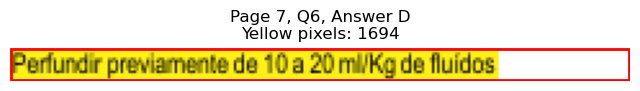

Page 7, Q6 - E: Detected box: x0=336.7, y0=434.4, x1=427.6, y1=446.5
Page 7, Q6, E: Yellow pixels: 142
Page 7, Q6, E: Total non-white pixels: 593
Page 7, Q6, E: Yellow percentage: 23.9%


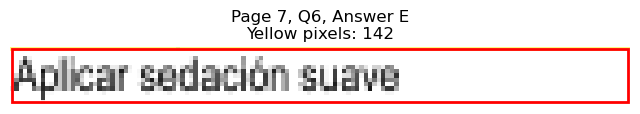


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=70.8, y0=494.7, x1=79.0, y1=506.8
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 54
Page 7, Q7, A: Yellow percentage: 0.0%


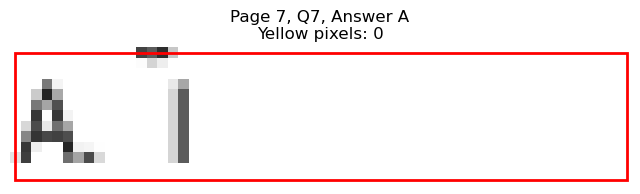

Page 7, Q7 - B: Detected box: x0=85.0, y0=506.8, x1=94.6, y1=518.9
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 109
Page 7, Q7, B: Yellow percentage: 0.0%


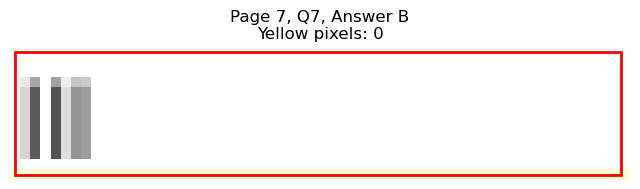

Page 7, Q7 - C: Detected box: x0=85.0, y0=518.8, x1=95.6, y1=530.9
Page 7, Q7, C: Yellow pixels: 706
Page 7, Q7, C: Total non-white pixels: 806
Page 7, Q7, C: Yellow percentage: 87.6%


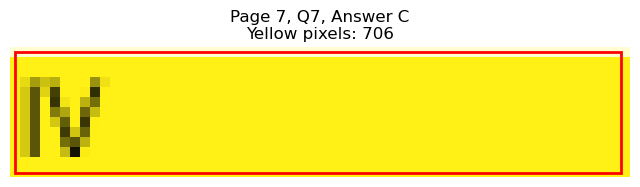

Page 7, Q7 - D: Detected box: x0=322.5, y0=494.7, x1=331.2, y1=506.8
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 65
Page 7, Q7, D: Yellow percentage: 0.0%


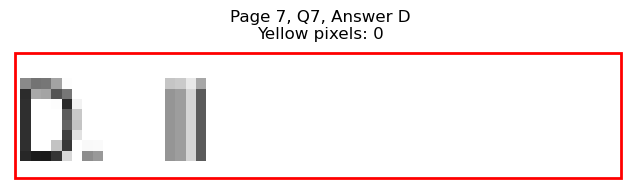

Page 7, Q7 - E: Detected box: x0=336.7, y0=506.8, x1=349.6, y1=518.9
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 62
Page 7, Q7, E: Yellow percentage: 0.0%


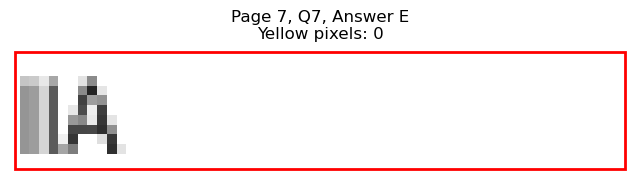


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=85.0, y0=567.1, x1=139.6, y1=579.2
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 260
Page 7, Q8, A: Yellow percentage: 0.0%


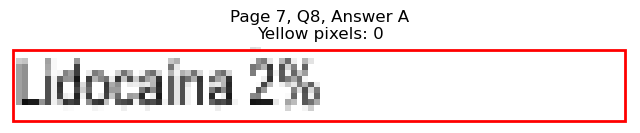

Page 7, Q8 - B: Detected box: x0=85.0, y0=579.1, x1=161.5, y1=591.2
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 399
Page 7, Q8, B: Yellow percentage: 0.0%


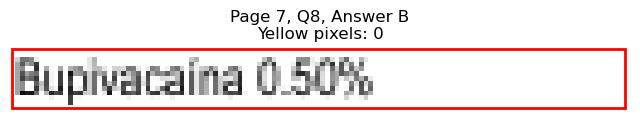

Page 7, Q8 - C: Detected box: x0=85.0, y0=591.2, x1=129.0, y1=603.3
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 226
Page 7, Q8, C: Yellow percentage: 0.0%


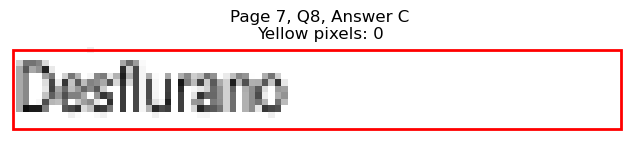

Page 7, Q8 - D: Detected box: x0=336.7, y0=567.1, x1=376.9, y1=579.2
Page 7, Q8, D: Yellow pixels: 91
Page 7, Q8, D: Total non-white pixels: 287
Page 7, Q8, D: Yellow percentage: 31.7%


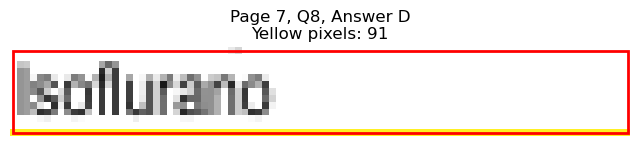

Page 7, Q8 - E: Detected box: x0=336.7, y0=579.1, x1=375.4, y1=591.2
Page 7, Q8, E: Yellow pixels: 929
Page 7, Q8, E: Total non-white pixels: 1170
Page 7, Q8, E: Yellow percentage: 79.4%


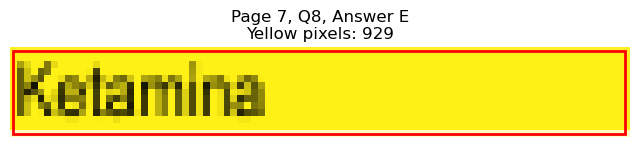


Page 7, Q8 - Selected Answer: E (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=85.0, y0=627.3, x1=123.7, y1=639.4
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 203
Page 7, Q9, A: Yellow percentage: 0.0%


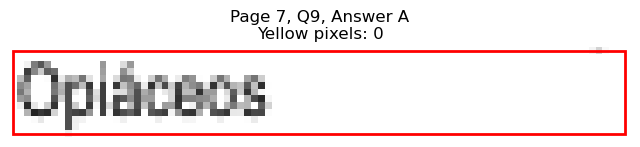

Page 7, Q9 - B: Detected box: x0=85.0, y0=639.3, x1=130.5, y1=651.4
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 245
Page 7, Q9, B: Yellow percentage: 0.0%


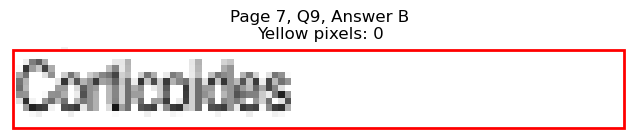

Page 7, Q9 - C: Detected box: x0=85.0, y0=651.4, x1=163.0, y1=663.5
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 403
Page 7, Q9, C: Yellow percentage: 0.0%


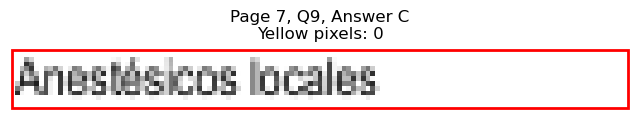

Page 7, Q9 - D: Detected box: x0=336.7, y0=627.3, x1=364.9, y1=639.4
Page 7, Q9, D: Yellow pixels: 79
Page 7, Q9, D: Total non-white pixels: 232
Page 7, Q9, D: Yellow percentage: 34.1%


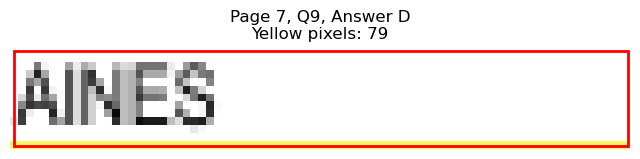

Page 7, Q9 - E: Detected box: x0=336.7, y0=639.3, x1=404.7, y1=651.4
Page 7, Q9, E: Yellow pixels: 1242
Page 7, Q9, E: Total non-white pixels: 1547
Page 7, Q9, E: Yellow percentage: 80.3%


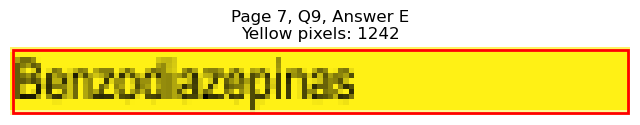


Page 7, Q9 - Selected Answer: E (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=85.0, y0=687.5, x1=153.4, y1=699.7
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 366
Page 7, Q10, A: Yellow percentage: 0.0%


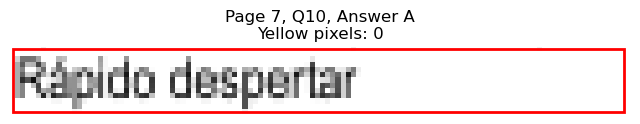

Page 7, Q10 - B: Detected box: x0=85.0, y0=699.5, x1=284.6, y1=711.7
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 994
Page 7, Q10, B: Yellow percentage: 0.0%


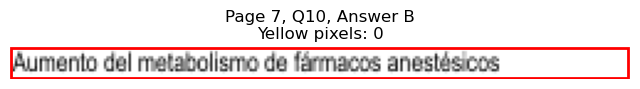

Page 7, Q10 - C: Detected box: x0=85.0, y0=711.7, x1=183.6, y1=723.8
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 629
Page 7, Q10, C: Yellow percentage: 0.0%


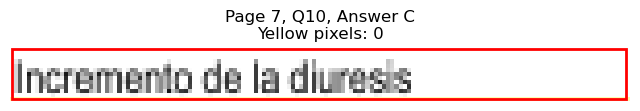

Page 7, Q10 - D: Detected box: x0=85.0, y0=723.7, x1=204.7, y1=735.8
Page 7, Q10, D: Yellow pixels: 1571
Page 7, Q10, D: Total non-white pixels: 2223
Page 7, Q10, D: Yellow percentage: 70.7%


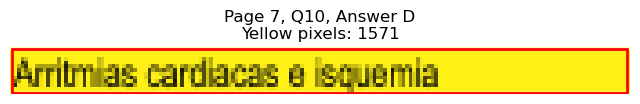

Page 7, Q10 - E: Detected box: x0=85.0, y0=735.8, x1=271.1, y1=747.9
Page 7, Q10, E: Yellow pixels: 236
Page 7, Q10, E: Total non-white pixels: 1189
Page 7, Q10, E: Yellow percentage: 19.8%


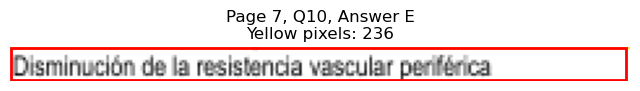


Page 7, Q10 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=94.6, y1=133.3
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 48
Page 8, Q1, A: Yellow percentage: 0.0%


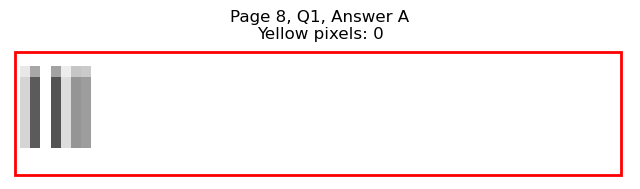

Page 8, Q1 - B: Detected box: x0=70.8, y0=133.2, x1=79.0, y1=145.3
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 55
Page 8, Q1, B: Yellow percentage: 0.0%


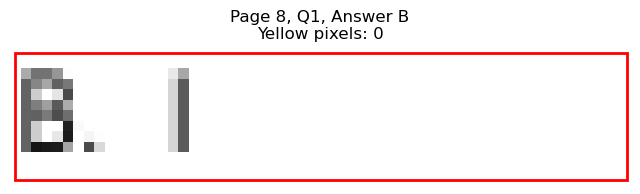

Page 8, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=95.6, y1=157.4
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 42
Page 8, Q1, C: Yellow percentage: 0.0%


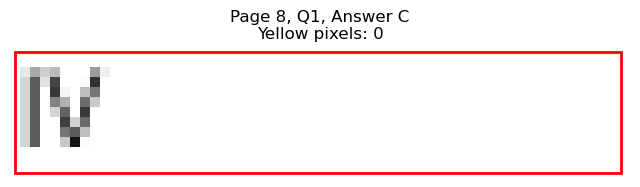

Page 8, Q1 - D: Detected box: x0=322.5, y0=121.2, x1=331.2, y1=133.3
Page 8, Q1, D: Yellow pixels: 661
Page 8, Q1, D: Total non-white pixels: 780
Page 8, Q1, D: Yellow percentage: 84.7%


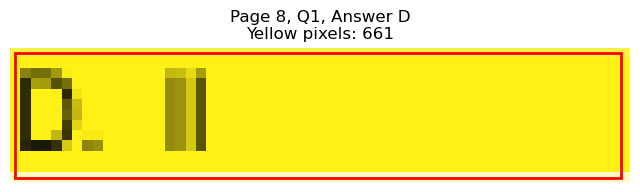

Page 8, Q1 - E: Detected box: x0=322.5, y0=133.2, x1=330.7, y1=145.3
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 117
Page 8, Q1, E: Yellow percentage: 0.0%


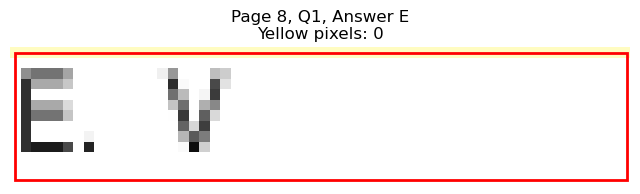


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=316.6, y1=205.5
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 1170
Page 8, Q2, A: Yellow percentage: 0.0%


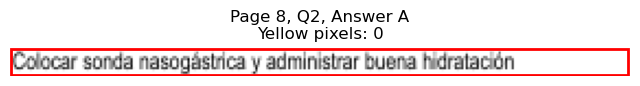

Page 8, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=287.0, y1=217.7
Page 8, Q2, B: Yellow pixels: 253
Page 8, Q2, B: Total non-white pixels: 1263
Page 8, Q2, B: Yellow percentage: 20.0%


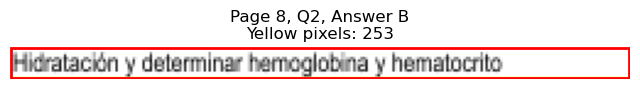

Page 8, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=337.3, y1=229.7
Page 8, Q2, C: Yellow pixels: 2902
Page 8, Q2, C: Total non-white pixels: 3952
Page 8, Q2, C: Yellow percentage: 73.4%


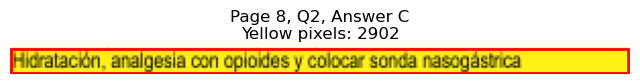

Page 8, Q2 - D: Detected box: x0=85.0, y0=229.7, x1=261.2, y1=241.8
Page 8, Q2, D: Yellow pixels: 228
Page 8, Q2, D: Total non-white pixels: 1082
Page 8, Q2, D: Yellow percentage: 21.1%


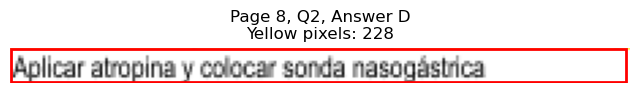

Page 8, Q2 - E: Detected box: x0=85.0, y0=241.7, x1=202.3, y1=253.8
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 638
Page 8, Q2, E: Yellow percentage: 0.0%


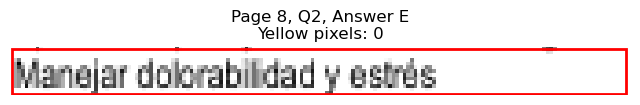


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=85.0, y0=277.8, x1=220.5, y1=289.9
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 681
Page 8, Q3, A: Yellow percentage: 0.0%


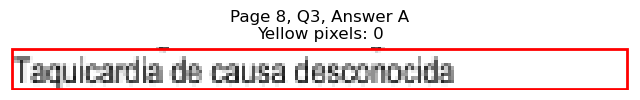

Page 8, Q3 - B: Detected box: x0=85.0, y0=289.9, x1=111.7, y1=302.0
Page 8, Q3, B: Yellow pixels: 815
Page 8, Q3, B: Total non-white pixels: 1014
Page 8, Q3, B: Yellow percentage: 80.4%


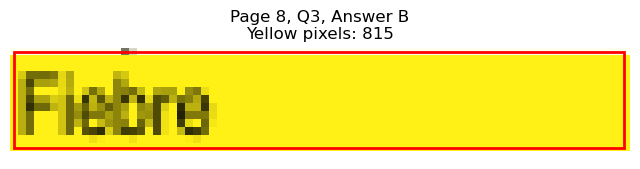

Page 8, Q3 - C: Detected box: x0=85.0, y0=301.9, x1=147.7, y1=314.0
Page 8, Q3, C: Yellow pixels: 114
Page 8, Q3, C: Total non-white pixels: 454
Page 8, Q3, C: Yellow percentage: 25.1%


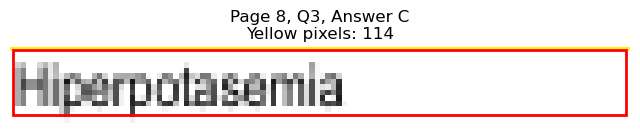

Page 8, Q3 - D: Detected box: x0=336.7, y0=277.8, x1=405.1, y1=289.9
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 356
Page 8, Q3, D: Yellow percentage: 0.0%


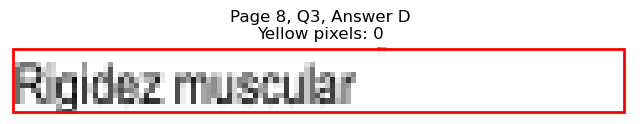

Page 8, Q3 - E: Detected box: x0=336.7, y0=289.9, x1=379.8, y1=302.0
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 228
Page 8, Q3, E: Yellow percentage: 0.0%


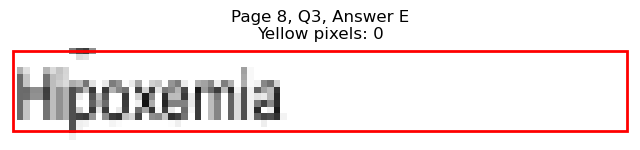


Page 8, Q3 - Selected Answer: B (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=169.7, y1=350.2
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 455
Page 8, Q4, A: Yellow percentage: 0.0%


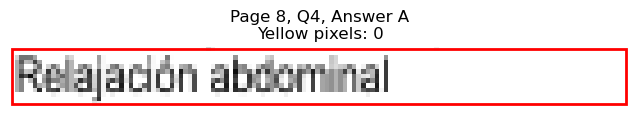

Page 8, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=161.5, y1=362.3
Page 8, Q4, B: Yellow pixels: 128
Page 8, Q4, B: Total non-white pixels: 557
Page 8, Q4, B: Yellow percentage: 23.0%


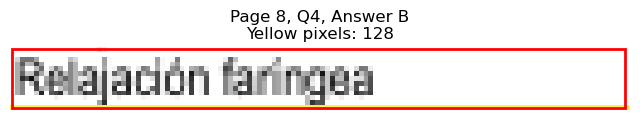

Page 8, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=229.1, y1=374.3
Page 8, Q4, C: Yellow pixels: 1661
Page 8, Q4, C: Total non-white pixels: 2483
Page 8, Q4, C: Yellow percentage: 66.9%


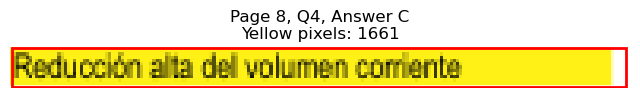

Page 8, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=526.9, y1=350.2
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 975
Page 8, Q4, D: Yellow percentage: 0.0%


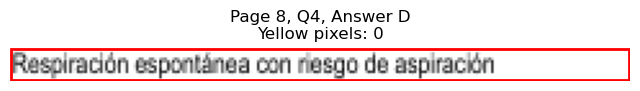

Page 8, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=435.3, y1=362.3
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 511
Page 8, Q4, E: Yellow percentage: 0.0%


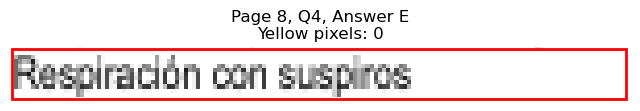


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=85.0, y0=422.4, x1=118.9, y1=434.5
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 174
Page 8, Q5, A: Yellow percentage: 0.0%


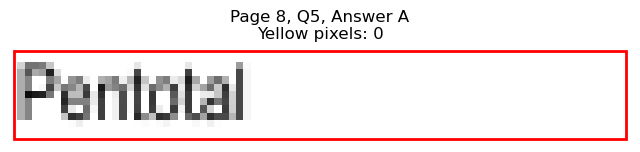

Page 8, Q5 - B: Detected box: x0=85.0, y0=434.4, x1=119.4, y1=446.5
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 174
Page 8, Q5, B: Yellow percentage: 0.0%


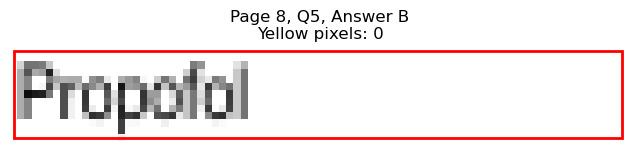

Page 8, Q5 - C: Detected box: x0=85.0, y0=446.6, x1=123.7, y1=458.7
Page 8, Q5, C: Yellow pixels: 1007
Page 8, Q5, C: Total non-white pixels: 1170
Page 8, Q5, C: Yellow percentage: 86.1%


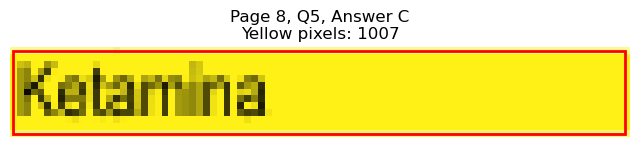

Page 8, Q5 - D: Detected box: x0=336.7, y0=422.4, x1=389.8, y1=434.5
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 245
Page 8, Q5, D: Yellow percentage: 0.0%


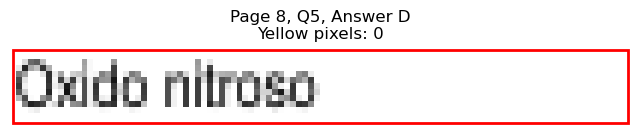

Page 8, Q5 - E: Detected box: x0=336.7, y0=434.4, x1=375.0, y1=446.5
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 200
Page 8, Q5, E: Yellow percentage: 0.0%


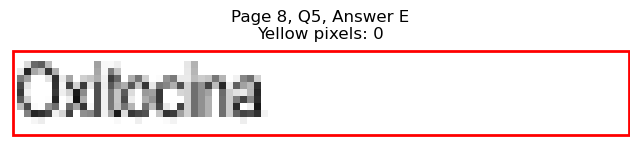


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=85.0, y0=482.7, x1=130.9, y1=494.8
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 254
Page 8, Q6, A: Yellow percentage: 0.0%


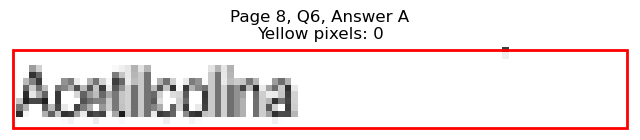

Page 8, Q6 - B: Detected box: x0=85.0, y0=494.7, x1=119.4, y1=506.8
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 179
Page 8, Q6, B: Yellow percentage: 0.0%


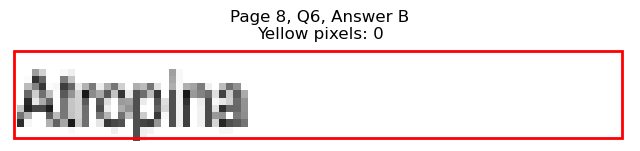

Page 8, Q6 - C: Detected box: x0=85.0, y0=506.8, x1=120.9, y1=518.9
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 214
Page 8, Q6, C: Yellow percentage: 0.0%


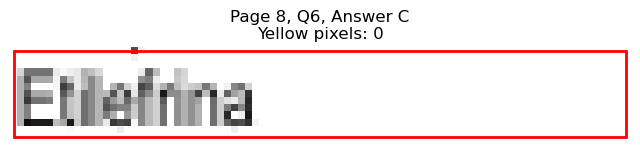

Page 8, Q6 - D: Detected box: x0=336.7, y0=482.7, x1=387.0, y1=494.8
Page 8, Q6, D: Yellow pixels: 973
Page 8, Q6, D: Total non-white pixels: 1313
Page 8, Q6, D: Yellow percentage: 74.1%


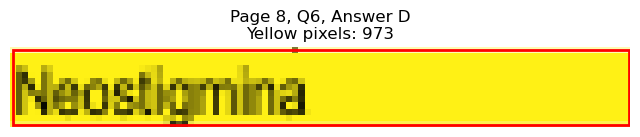

Page 8, Q6 - E: Detected box: x0=336.7, y0=494.7, x1=393.2, y1=506.8
Page 8, Q6, E: Yellow pixels: 105
Page 8, Q6, E: Total non-white pixels: 392
Page 8, Q6, E: Yellow percentage: 26.8%


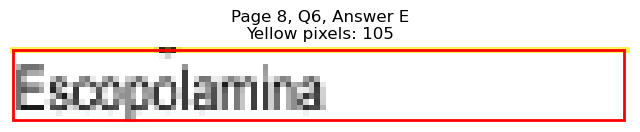


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=85.0, y0=554.9, x1=116.1, y1=567.0
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 177
Page 8, Q7, A: Yellow percentage: 0.0%


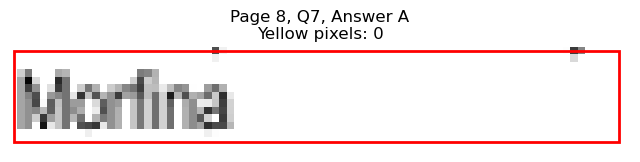

Page 8, Q7 - B: Detected box: x0=85.0, y0=567.1, x1=122.8, y1=579.2
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 206
Page 8, Q7, B: Yellow percentage: 0.0%


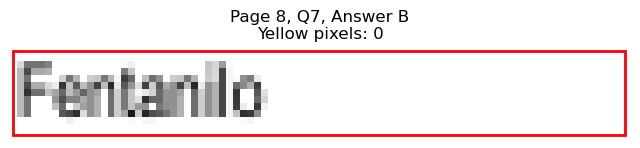

Page 8, Q7 - C: Detected box: x0=85.0, y0=579.1, x1=130.5, y1=591.2
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 227
Page 8, Q7, C: Yellow percentage: 0.0%


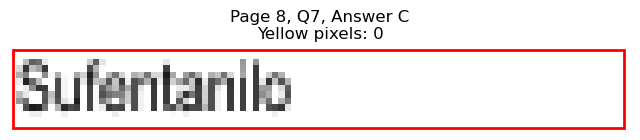

Page 8, Q7 - D: Detected box: x0=336.7, y0=554.9, x1=391.8, y1=567.0
Page 8, Q7, D: Yellow pixels: 1012
Page 8, Q7, D: Total non-white pixels: 1484
Page 8, Q7, D: Yellow percentage: 68.2%


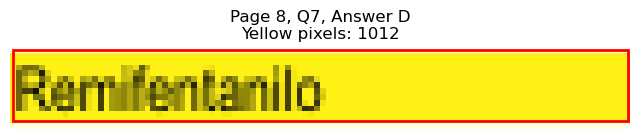

Page 8, Q7 - E: Detected box: x0=336.7, y0=567.1, x1=379.3, y1=579.2
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 310
Page 8, Q7, E: Yellow percentage: 0.0%


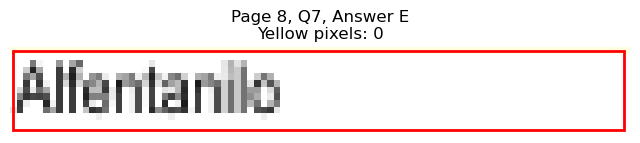


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=85.0, y0=615.2, x1=103.2, y1=627.3
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 91
Page 8, Q8, A: Yellow percentage: 0.0%


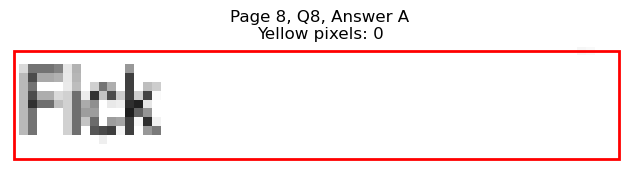

Page 8, Q8 - B: Detected box: x0=85.0, y0=627.3, x1=178.3, y1=639.4
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 447
Page 8, Q8, B: Yellow percentage: 0.0%


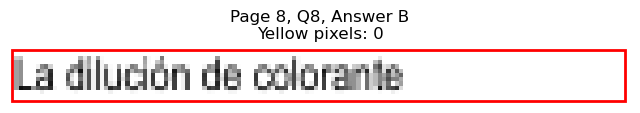

Page 8, Q8 - C: Detected box: x0=85.0, y0=639.3, x1=193.7, y1=651.4
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 559
Page 8, Q8, C: Yellow percentage: 0.0%


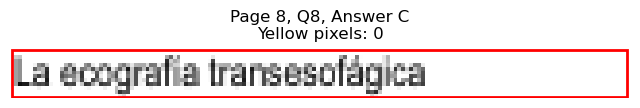

Page 8, Q8 - D: Detected box: x0=336.7, y0=615.2, x1=416.1, y1=627.3
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 424
Page 8, Q8, D: Yellow percentage: 0.0%


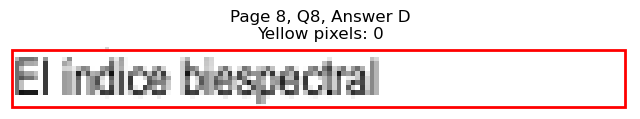

Page 8, Q8 - E: Detected box: x0=336.7, y0=627.3, x1=393.2, y1=639.4
Page 8, Q8, E: Yellow pixels: 1067
Page 8, Q8, E: Total non-white pixels: 1404
Page 8, Q8, E: Yellow percentage: 76.0%


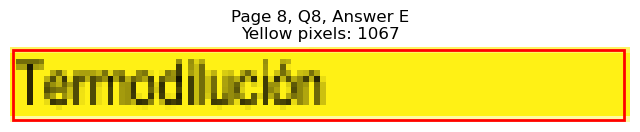


Page 8, Q8 - Selected Answer: E (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=85.0, y0=687.5, x1=130.0, y1=699.7
Page 8, Q9, A: Yellow pixels: 96
Page 8, Q9, A: Total non-white pixels: 343
Page 8, Q9, A: Yellow percentage: 28.0%


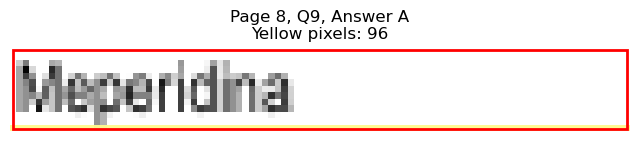

Page 8, Q9 - B: Detected box: x0=85.0, y0=699.5, x1=125.7, y1=711.7
Page 8, Q9, B: Yellow pixels: 1012
Page 8, Q9, B: Total non-white pixels: 1196
Page 8, Q9, B: Yellow percentage: 84.6%


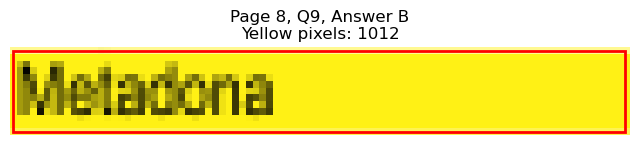

Page 8, Q9 - C: Detected box: x0=85.0, y0=711.7, x1=116.1, y1=723.8
Page 8, Q9, C: Yellow pixels: 83
Page 8, Q9, C: Total non-white pixels: 254
Page 8, Q9, C: Yellow percentage: 32.7%


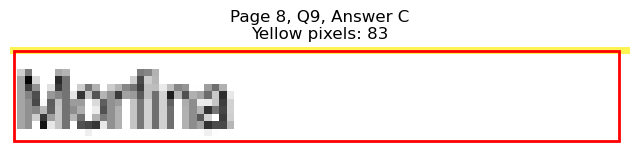

Page 8, Q9 - D: Detected box: x0=336.7, y0=687.5, x1=374.5, y1=699.7
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 176
Page 8, Q9, D: Yellow percentage: 0.0%


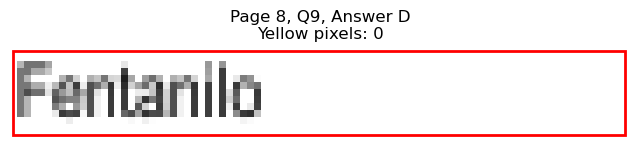

Page 8, Q9 - E: Detected box: x0=336.7, y0=699.5, x1=391.8, y1=711.7
Page 8, Q9, E: Yellow pixels: 0
Page 8, Q9, E: Total non-white pixels: 314
Page 8, Q9, E: Yellow percentage: 0.0%


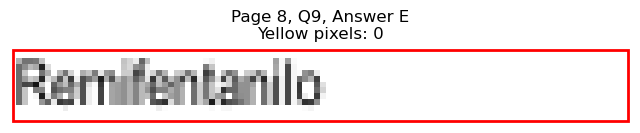


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=137.2, y1=121.3
Page 9, Q1, A: Yellow pixels: 1033
Page 9, Q1, A: Total non-white pixels: 1352
Page 9, Q1, A: Yellow percentage: 76.4%


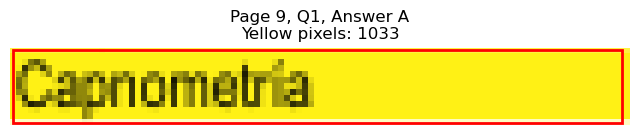

Page 9, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=162.0, y1=133.3
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 528
Page 9, Q1, B: Yellow percentage: 0.0%


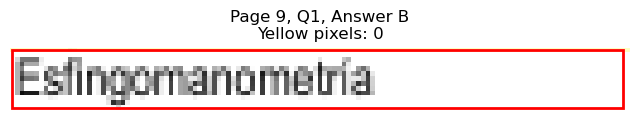

Page 9, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=136.7, y1=145.3
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 268
Page 9, Q1, C: Yellow percentage: 0.0%


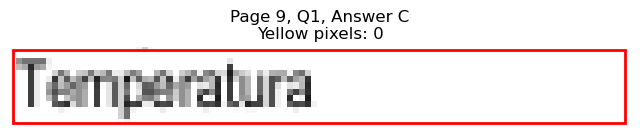

Page 9, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=411.3, y1=121.3
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 381
Page 9, Q1, D: Yellow percentage: 0.0%


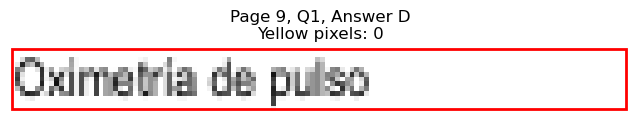

Page 9, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=416.6, y1=133.3
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 412
Page 9, Q1, E: Yellow percentage: 0.0%


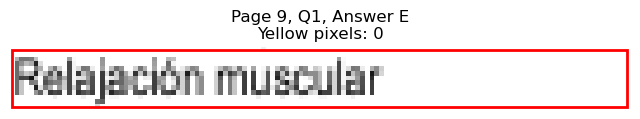


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=139.6, y1=181.5
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 294
Page 9, Q2, A: Yellow percentage: 0.0%


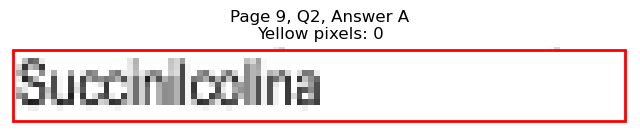

Page 9, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=121.8, y1=193.5
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 184
Page 9, Q2, B: Yellow percentage: 0.0%


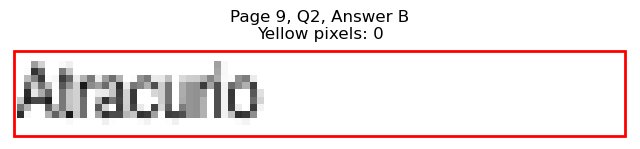

Page 9, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=138.1, y1=205.5
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 262
Page 9, Q2, C: Yellow percentage: 0.0%


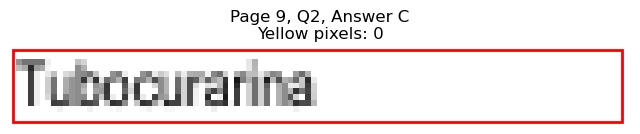

Page 9, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=380.2, y1=181.5
Page 9, Q2, D: Yellow pixels: 95
Page 9, Q2, D: Total non-white pixels: 317
Page 9, Q2, D: Yellow percentage: 30.0%


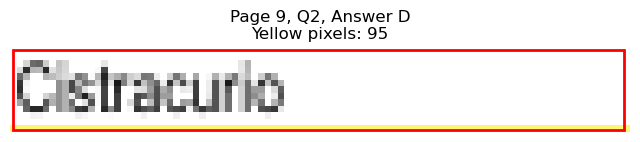

Page 9, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=378.3, y1=193.5
Page 9, Q2, E: Yellow pixels: 1043
Page 9, Q2, E: Total non-white pixels: 1209
Page 9, Q2, E: Yellow percentage: 86.3%


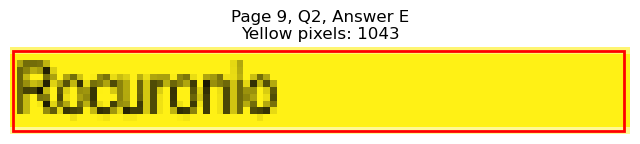


Page 9, Q2 - Selected Answer: E (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=85.0, y0=229.7, x1=108.5, y1=241.8
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 93
Page 9, Q3, A: Yellow percentage: 0.0%


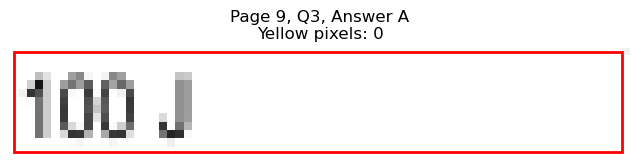

Page 9, Q3 - B: Detected box: x0=85.0, y0=241.7, x1=108.5, y1=253.8
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 177
Page 9, Q3, B: Yellow percentage: 0.0%


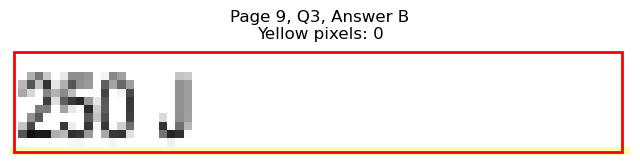

Page 9, Q3 - C: Detected box: x0=85.0, y0=253.7, x1=108.5, y1=265.8
Page 9, Q3, C: Yellow pixels: 821
Page 9, Q3, C: Total non-white pixels: 975
Page 9, Q3, C: Yellow percentage: 84.2%


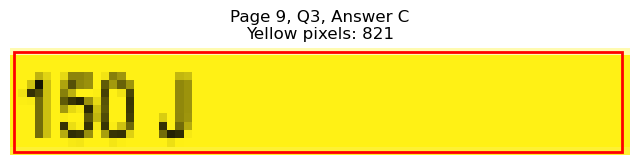

Page 9, Q3 - D: Detected box: x0=336.7, y0=229.7, x1=360.2, y1=241.8
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 109
Page 9, Q3, D: Yellow percentage: 0.0%


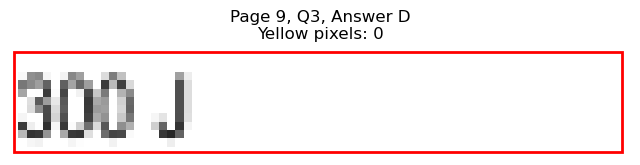

Page 9, Q3 - E: Detected box: x0=336.7, y0=241.7, x1=360.2, y1=253.8
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 109
Page 9, Q3, E: Yellow percentage: 0.0%


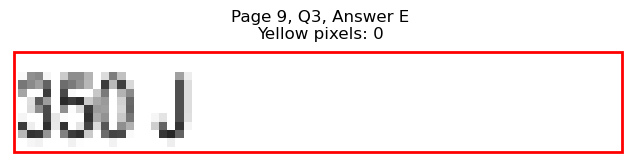


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=85.0, y0=289.9, x1=124.2, y1=302.0
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 191
Page 9, Q4, A: Yellow percentage: 0.0%


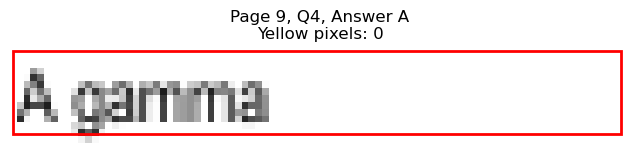

Page 9, Q4 - B: Detected box: x0=85.0, y0=301.9, x1=112.2, y1=314.0
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 141
Page 9, Q4, B: Yellow percentage: 0.0%


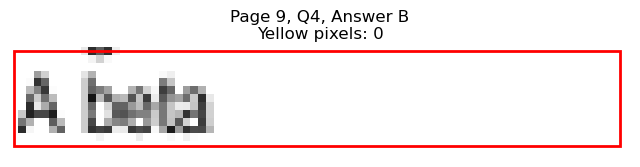

Page 9, Q4 - C: Detected box: x0=70.8, y0=313.9, x1=79.5, y1=326.0
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 68
Page 9, Q4, C: Yellow percentage: 0.0%


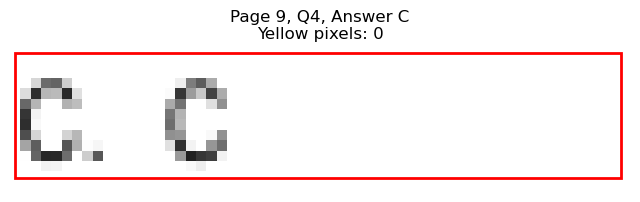

Page 9, Q4 - D: Detected box: x0=336.7, y0=289.9, x1=365.8, y1=302.0
Page 9, Q4, D: Yellow pixels: 862
Page 9, Q4, D: Total non-white pixels: 1040
Page 9, Q4, D: Yellow percentage: 82.9%


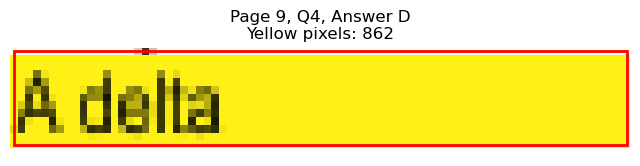

Page 9, Q4 - E: Detected box: x0=322.5, y0=301.9, x1=330.7, y1=314.0
Page 9, Q4, E: Yellow pixels: 59
Page 9, Q4, E: Total non-white pixels: 125
Page 9, Q4, E: Yellow percentage: 47.2%


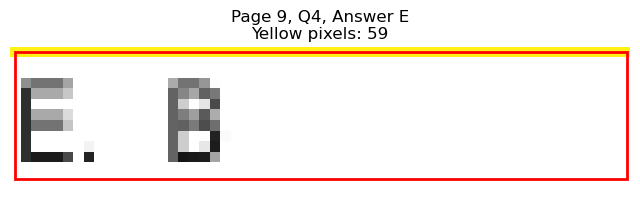


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=85.0, y0=350.2, x1=178.3, y1=362.3
Page 9, Q5, A: Yellow pixels: 1334
Page 9, Q5, A: Total non-white pixels: 1885
Page 9, Q5, A: Yellow percentage: 70.8%


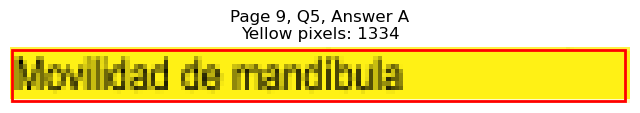

Page 9, Q5 - B: Detected box: x0=85.0, y0=362.2, x1=106.1, y1=374.3
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 186
Page 9, Q5, B: Yellow percentage: 0.0%


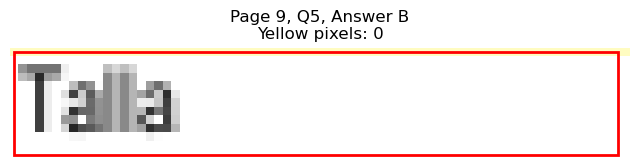

Page 9, Q5 - C: Detected box: x0=85.0, y0=374.2, x1=182.2, y1=386.3
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 501
Page 9, Q5, C: Yellow percentage: 0.0%


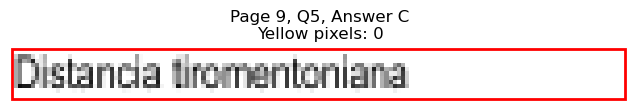

Page 9, Q5 - D: Detected box: x0=336.7, y0=350.2, x1=380.7, y1=362.3
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 240
Page 9, Q5, D: Yellow percentage: 0.0%


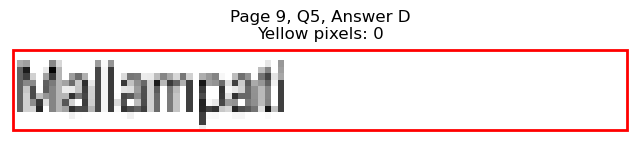

Page 9, Q5 - E: Detected box: x0=336.7, y0=362.2, x1=407.0, y1=374.3
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 377
Page 9, Q5, E: Yellow percentage: 0.0%


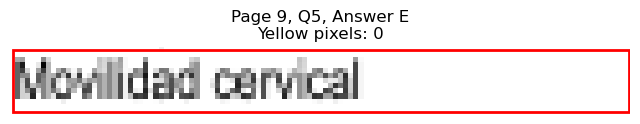


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=85.0, y0=422.4, x1=267.4, y1=434.5
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 902
Page 9, Q6, A: Yellow percentage: 0.0%


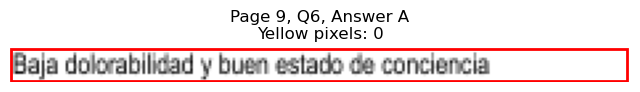

Page 9, Q6 - B: Detected box: x0=85.0, y0=434.4, x1=191.5, y1=446.5
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 530
Page 9, Q6, B: Yellow percentage: 0.0%


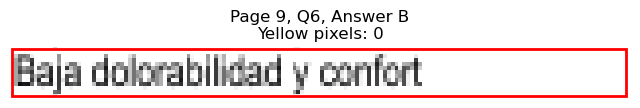

Page 9, Q6 - C: Detected box: x0=85.0, y0=446.6, x1=197.0, y1=458.7
Page 9, Q6, C: Yellow pixels: 163
Page 9, Q6, C: Total non-white pixels: 760
Page 9, Q6, C: Yellow percentage: 21.4%


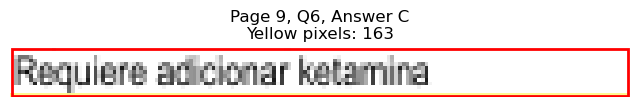

Page 9, Q6 - D: Detected box: x0=85.0, y0=458.6, x1=324.8, y1=470.7
Page 9, Q6, D: Yellow pixels: 2831
Page 9, Q6, D: Total non-white pixels: 3783
Page 9, Q6, D: Yellow percentage: 74.8%


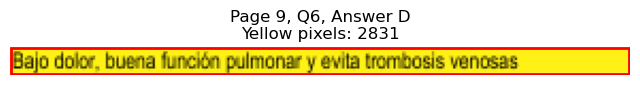

Page 9, Q6 - E: Detected box: x0=85.0, y0=470.7, x1=262.6, y1=482.8
Page 9, Q6, E: Yellow pixels: 229
Page 9, Q6, E: Total non-white pixels: 1152
Page 9, Q6, E: Yellow percentage: 19.9%


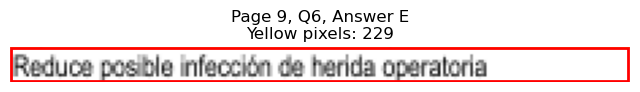


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=85.0, y0=518.8, x1=127.1, y1=530.9
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 224
Page 9, Q7, A: Yellow percentage: 0.0%


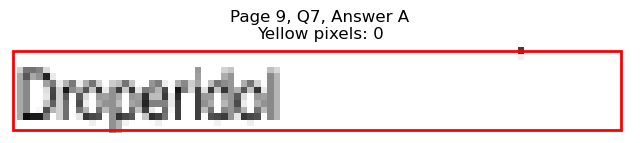

Page 9, Q7 - B: Detected box: x0=85.0, y0=530.9, x1=119.4, y1=543.0
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 178
Page 9, Q7, B: Yellow percentage: 0.0%


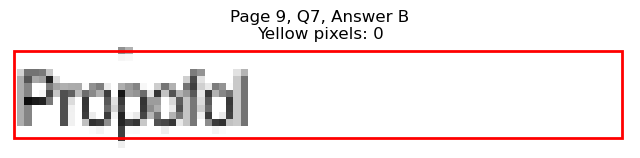

Page 9, Q7 - C: Detected box: x0=85.0, y0=542.9, x1=129.0, y1=555.0
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 243
Page 9, Q7, C: Yellow percentage: 0.0%


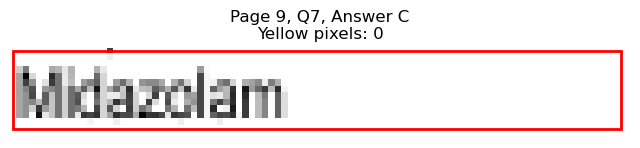

Page 9, Q7 - D: Detected box: x0=336.7, y0=518.8, x1=374.5, y1=530.9
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 191
Page 9, Q7, D: Yellow percentage: 0.0%


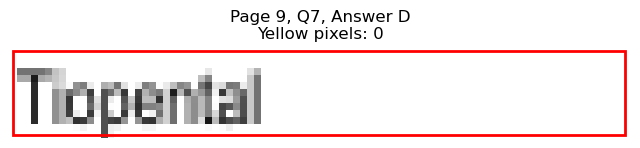

Page 9, Q7 - E: Detected box: x0=336.7, y0=530.9, x1=408.4, y1=543.0
Page 9, Q7, E: Yellow pixels: 1156
Page 9, Q7, E: Total non-white pixels: 1599
Page 9, Q7, E: Yellow percentage: 72.3%


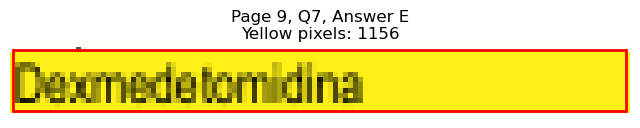


Page 9, Q7 - Selected Answer: E (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=85.0, y0=579.1, x1=169.7, y1=591.2
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 403
Page 9, Q8, A: Yellow percentage: 0.0%


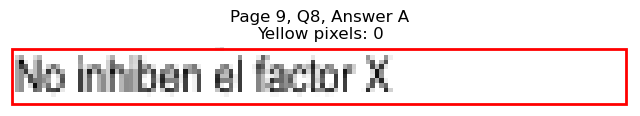

Page 9, Q8 - B: Detected box: x0=85.0, y0=591.2, x1=323.4, y1=603.3
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 1127
Page 9, Q8, B: Yellow percentage: 0.0%


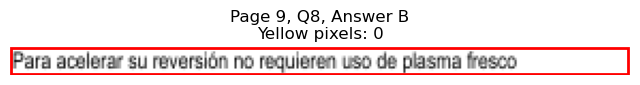

Page 9, Q8 - C: Detected box: x0=85.0, y0=603.2, x1=258.8, y1=615.3
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 821
Page 9, Q8, C: Yellow percentage: 0.0%


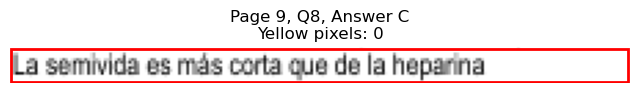

Page 9, Q8 - D: Detected box: x0=85.0, y0=615.2, x1=332.0, y1=627.3
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 1283
Page 9, Q8, D: Yellow percentage: 0.0%


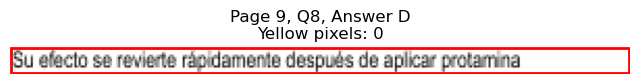

Page 9, Q8 - E: Detected box: x0=85.0, y0=627.3, x1=162.0, y1=639.4
Page 9, Q8, E: Yellow pixels: 1241
Page 9, Q8, E: Total non-white pixels: 1677
Page 9, Q8, E: Yellow percentage: 74.0%


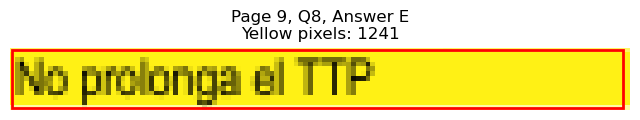


Page 9, Q8 - Selected Answer: E (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=112.7, y1=675.5
Page 9, Q9, A: Yellow pixels: 925
Page 9, Q9, A: Total non-white pixels: 1027
Page 9, Q9, A: Yellow percentage: 90.1%


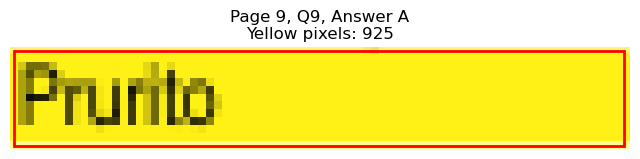

Page 9, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=172.6, y1=687.5
Page 9, Q9, B: Yellow pixels: 139
Page 9, Q9, B: Total non-white pixels: 621
Page 9, Q9, B: Yellow percentage: 22.4%


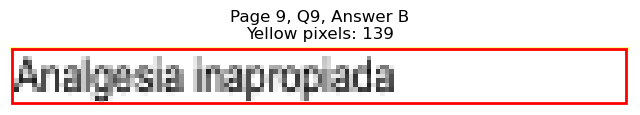

Page 9, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=111.7, y1=699.7
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 146
Page 9, Q9, C: Yellow percentage: 0.0%


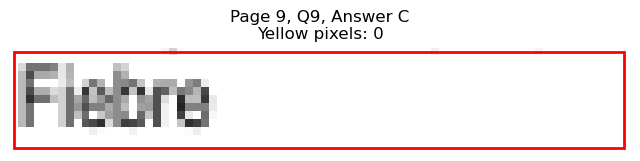

Page 9, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=459.7, y1=675.5
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 658
Page 9, Q9, D: Yellow percentage: 0.0%


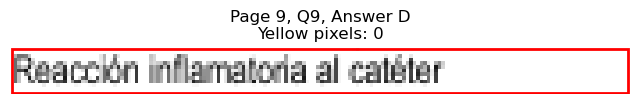

Page 9, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=373.5, y1=687.5
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 191
Page 9, Q9, E: Yellow percentage: 0.0%


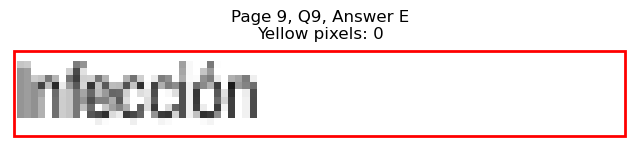


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=85.0, y0=723.7, x1=121.8, y1=735.8
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 190
Page 9, Q10, A: Yellow percentage: 0.0%


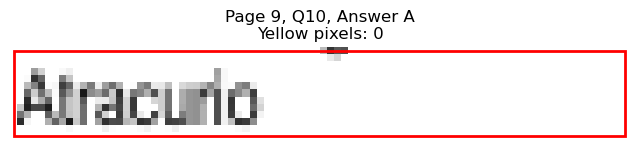

Page 9, Q10 - B: Detected box: x0=85.0, y0=735.8, x1=133.3, y1=747.9
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 247
Page 9, Q10, B: Yellow percentage: 0.0%


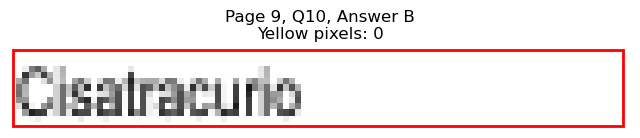

Page 9, Q10 - C: Detected box: x0=85.0, y0=747.8, x1=126.6, y1=759.9
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 203
Page 9, Q10, C: Yellow percentage: 0.0%


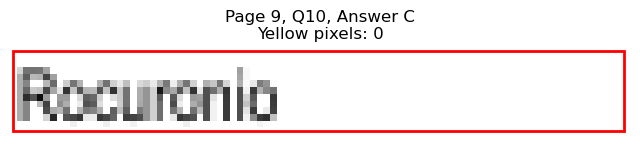

Page 9, Q10 - D: Detected box: x0=336.7, y0=723.7, x1=391.3, y1=735.8
Page 9, Q10, D: Yellow pixels: 1067
Page 9, Q10, D: Total non-white pixels: 1378
Page 9, Q10, D: Yellow percentage: 77.4%


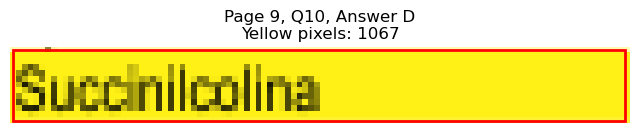

Page 9, Q10 - E: Detected box: x0=336.7, y0=735.8, x1=382.6, y1=747.9
Page 9, Q10, E: Yellow pixels: 97
Page 9, Q10, E: Total non-white pixels: 318
Page 9, Q10, E: Yellow percentage: 30.5%


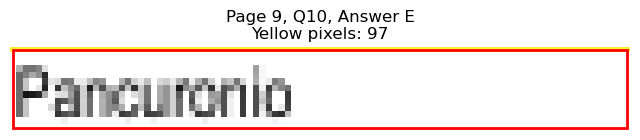


Page 9, Q10 - Selected Answer: D (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=119.4, y1=121.3
Page 10, Q1, A: Yellow pixels: 888
Page 10, Q1, A: Total non-white pixels: 1118
Page 10, Q1, A: Yellow percentage: 79.4%


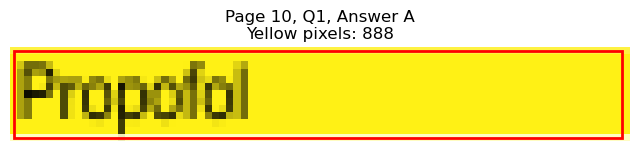

Page 10, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=122.8, y1=133.3
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 277
Page 10, Q1, B: Yellow percentage: 0.0%


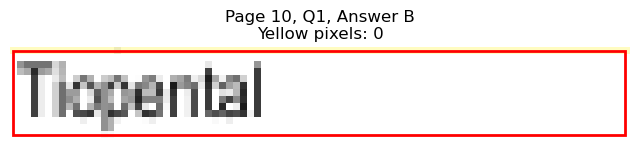

Page 10, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=123.7, y1=145.3
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 198
Page 10, Q1, C: Yellow percentage: 0.0%


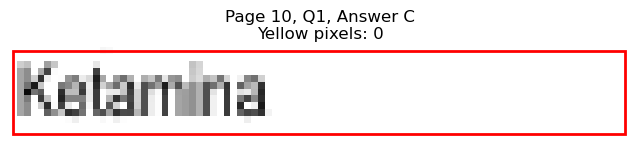

Page 10, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=380.7, y1=121.3
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 224
Page 10, Q1, D: Yellow percentage: 0.0%


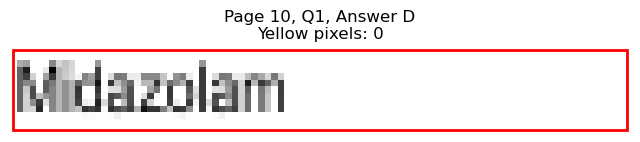

Page 10, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=377.8, y1=133.3
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 206
Page 10, Q1, E: Yellow percentage: 0.0%


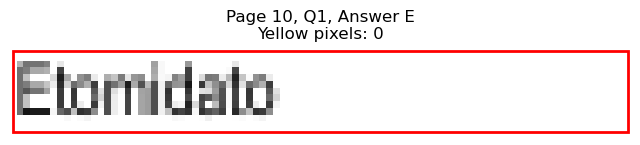


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=203.2, y1=181.5
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 586
Page 10, Q2, A: Yellow percentage: 0.0%


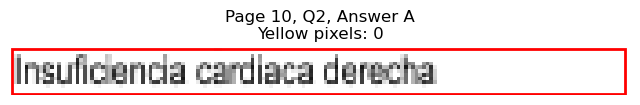

Page 10, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=156.7, y1=193.5
Page 10, Q2, B: Yellow pixels: 123
Page 10, Q2, B: Total non-white pixels: 465
Page 10, Q2, B: Yellow percentage: 26.5%


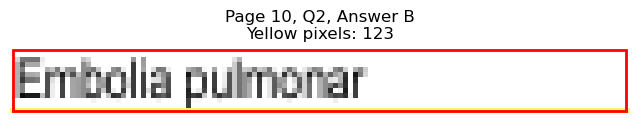

Page 10, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=134.8, y1=205.5
Page 10, Q2, C: Yellow pixels: 1102
Page 10, Q2, C: Total non-white pixels: 1313
Page 10, Q2, C: Yellow percentage: 83.9%


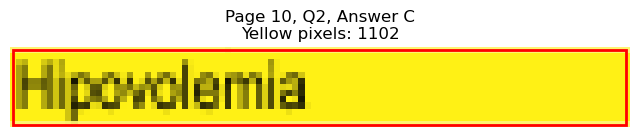

Page 10, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=425.7, y1=181.5
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 445
Page 10, Q2, D: Yellow percentage: 0.0%


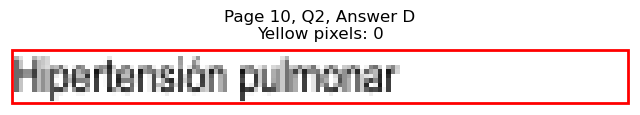

Page 10, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=438.7, y1=193.5
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 530
Page 10, Q2, E: Yellow percentage: 0.0%


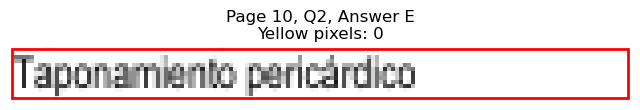


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=326.7, y1=253.8
Page 10, Q3, A: Yellow pixels: 2
Page 10, Q3, A: Total non-white pixels: 1506
Page 10, Q3, A: Yellow percentage: 0.1%


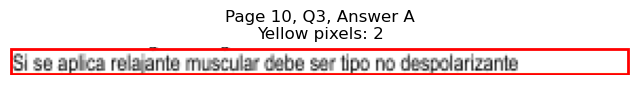

Page 10, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=242.9, y1=265.8
Page 10, Q3, B: Yellow pixels: 1878
Page 10, Q3, B: Total non-white pixels: 2717
Page 10, Q3, B: Yellow percentage: 69.1%


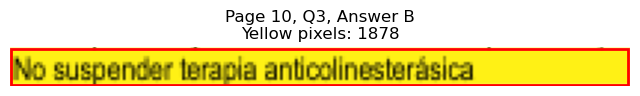

Page 10, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=187.5, y1=277.9
Page 10, Q3, C: Yellow pixels: 151
Page 10, Q3, C: Total non-white pixels: 639
Page 10, Q3, C: Yellow percentage: 23.6%


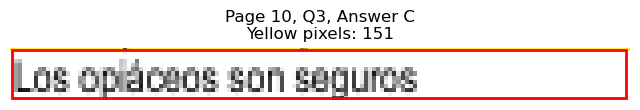

Page 10, Q3 - D: Detected box: x0=85.0, y0=277.8, x1=208.5, y1=289.9
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 617
Page 10, Q3, D: Yellow percentage: 0.0%


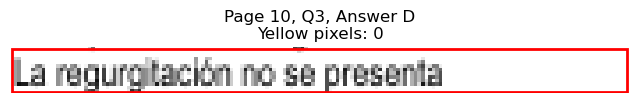

Page 10, Q3 - E: Detected box: x0=85.0, y0=289.9, x1=230.6, y1=302.0
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 753
Page 10, Q3, E: Yellow percentage: 0.0%


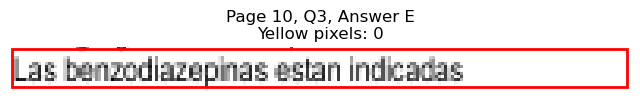


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=110.3, y1=350.2
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 126
Page 10, Q4, A: Yellow percentage: 0.0%


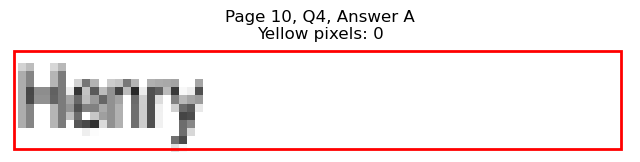

Page 10, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=112.2, y1=362.3
Page 10, Q4, B: Yellow pixels: 820
Page 10, Q4, B: Total non-white pixels: 1027
Page 10, Q4, B: Yellow percentage: 79.8%


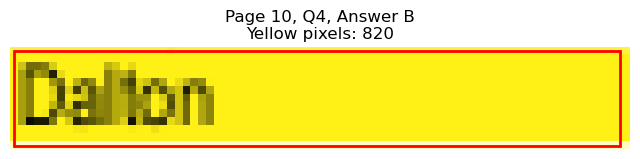

Page 10, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=109.0, y1=374.3
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 200
Page 10, Q4, C: Yellow percentage: 0.0%


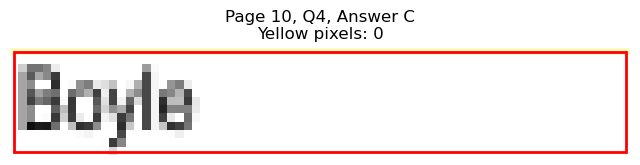

Page 10, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=385.0, y1=350.2
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 227
Page 10, Q4, D: Yellow percentage: 0.0%


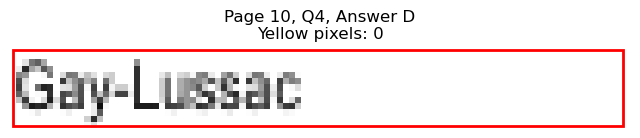

Page 10, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=380.8, y1=362.3
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 224
Page 10, Q4, E: Yellow percentage: 0.0%


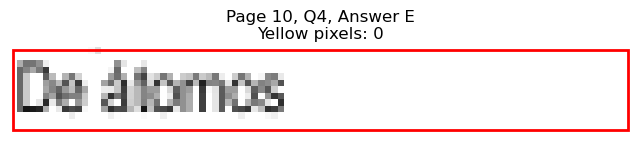


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=119.4, y1=410.4
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 177
Page 10, Q5, A: Yellow percentage: 0.0%


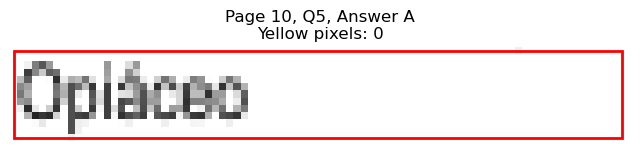

Page 10, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=143.9, y1=422.5
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 309
Page 10, Q5, B: Yellow percentage: 0.0%


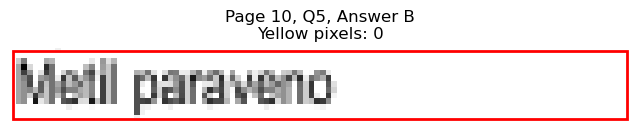

Page 10, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=150.6, y1=434.5
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 353
Page 10, Q5, C: Yellow percentage: 0.0%


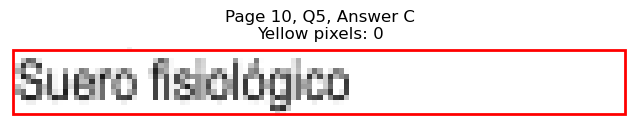

Page 10, Q5 - D: Detected box: x0=336.7, y0=398.3, x1=380.2, y1=410.4
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 220
Page 10, Q5, D: Yellow percentage: 0.0%


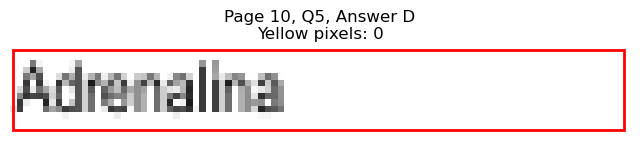

Page 10, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=385.0, y1=422.5
Page 10, Q5, E: Yellow pixels: 1094
Page 10, Q5, E: Total non-white pixels: 1300
Page 10, Q5, E: Yellow percentage: 84.2%


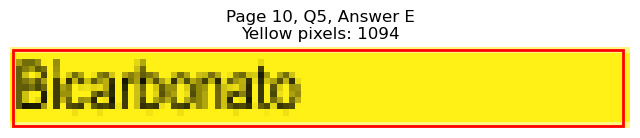


Page 10, Q5 - Selected Answer: E (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=85.0, y0=470.7, x1=130.9, y1=482.8
Page 10, Q6, A: Yellow pixels: 984
Page 10, Q6, A: Total non-white pixels: 1261
Page 10, Q6, A: Yellow percentage: 78.0%


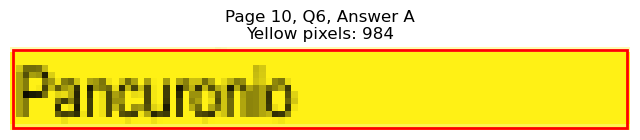

Page 10, Q6 - B: Detected box: x0=85.0, y0=482.7, x1=126.1, y1=494.8
Page 10, Q6, B: Yellow pixels: 93
Page 10, Q6, B: Total non-white pixels: 289
Page 10, Q6, B: Yellow percentage: 32.2%


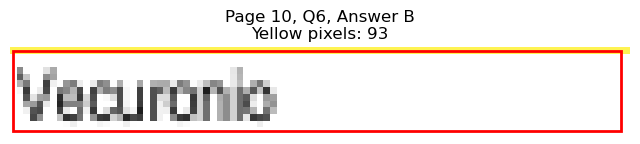

Page 10, Q6 - C: Detected box: x0=85.0, y0=494.7, x1=139.6, y1=506.8
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 291
Page 10, Q6, C: Yellow percentage: 0.0%


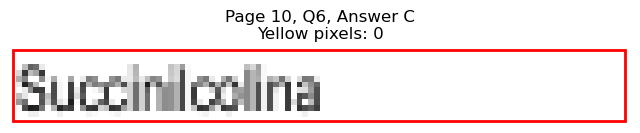

Page 10, Q6 - D: Detected box: x0=336.7, y0=470.7, x1=385.0, y1=482.8
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 260
Page 10, Q6, D: Yellow percentage: 0.0%


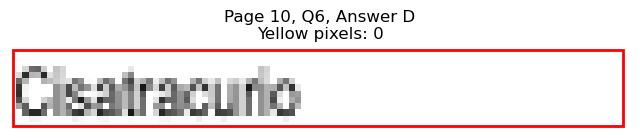

Page 10, Q6 - E: Detected box: x0=336.7, y0=482.7, x1=375.9, y1=494.8
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 206
Page 10, Q6, E: Yellow percentage: 0.0%


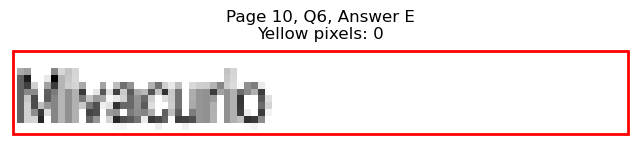


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=85.0, y0=542.9, x1=99.4, y1=555.0
Page 10, Q7, A: Yellow pixels: 740
Page 10, Q7, A: Total non-white pixels: 858
Page 10, Q7, A: Yellow percentage: 86.2%


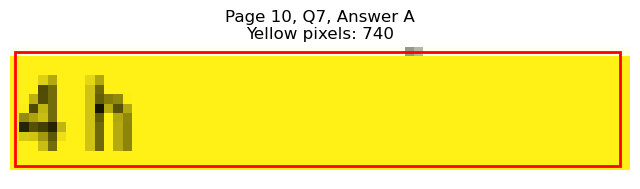

Page 10, Q7 - B: Detected box: x0=85.0, y0=554.9, x1=99.4, y1=567.0
Page 10, Q7, B: Yellow pixels: 66
Page 10, Q7, B: Total non-white pixels: 120
Page 10, Q7, B: Yellow percentage: 55.0%


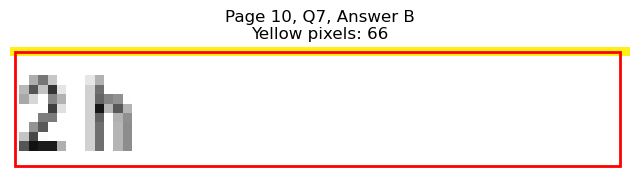

Page 10, Q7 - C: Detected box: x0=85.0, y0=567.1, x1=99.4, y1=579.2
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 62
Page 10, Q7, C: Yellow percentage: 0.0%


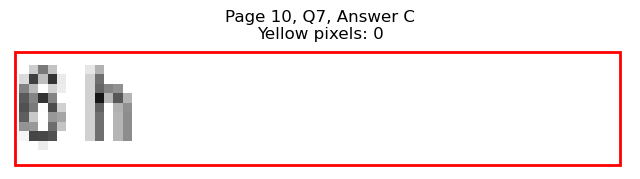

Page 10, Q7 - D: Detected box: x0=336.7, y0=542.9, x1=351.1, y1=555.0
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 36
Page 10, Q7, D: Yellow percentage: 0.0%


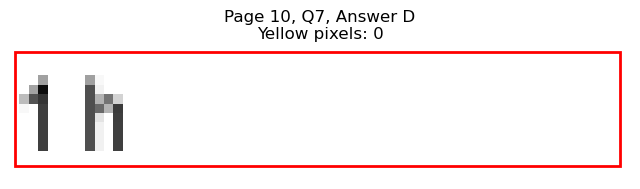

Page 10, Q7 - E: Detected box: x0=336.7, y0=554.9, x1=351.1, y1=567.0
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 54
Page 10, Q7, E: Yellow percentage: 0.0%


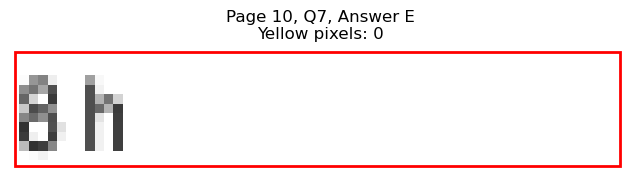


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=85.0, y0=603.2, x1=157.7, y1=615.3
Page 10, Q8, A: Yellow pixels: 1170
Page 10, Q8, A: Total non-white pixels: 1612
Page 10, Q8, A: Yellow percentage: 72.6%


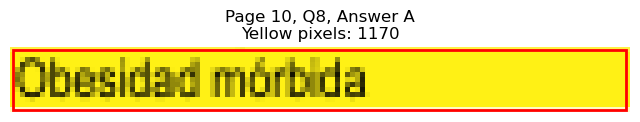

Page 10, Q8 - B: Detected box: x0=85.0, y0=615.2, x1=127.6, y1=627.3
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 308
Page 10, Q8, B: Yellow percentage: 0.0%


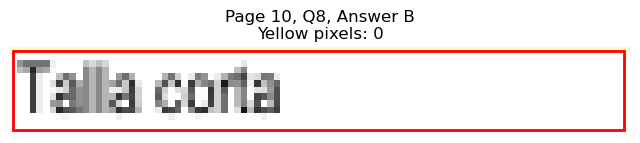

Page 10, Q8 - C: Detected box: x0=85.0, y0=627.3, x1=133.3, y1=639.4
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 250
Page 10, Q8, C: Yellow percentage: 0.0%


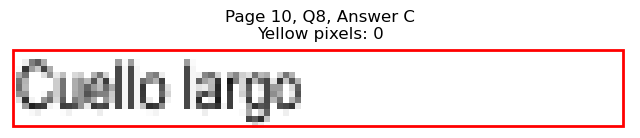

Page 10, Q8 - D: Detected box: x0=336.7, y0=603.2, x1=409.4, y1=615.3
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 415
Page 10, Q8, D: Yellow percentage: 0.0%


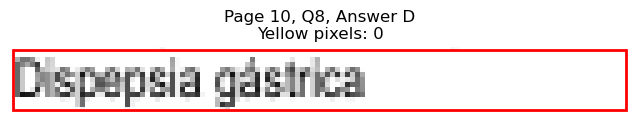

Page 10, Q8 - E: Detected box: x0=336.7, y0=615.2, x1=395.6, y1=627.3
Page 10, Q8, E: Yellow pixels: 0
Page 10, Q8, E: Total non-white pixels: 284
Page 10, Q8, E: Yellow percentage: 0.0%


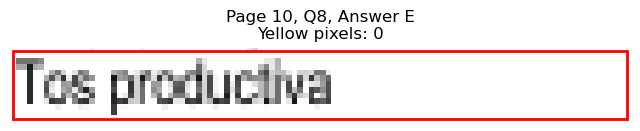


Page 10, Q8 - Selected Answer: A (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=186.0, y1=675.5
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 525
Page 10, Q9, A: Yellow percentage: 0.0%


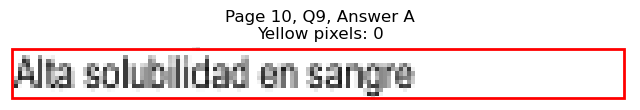

Page 10, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=232.5, y1=687.5
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 773
Page 10, Q9, B: Yellow percentage: 0.0%


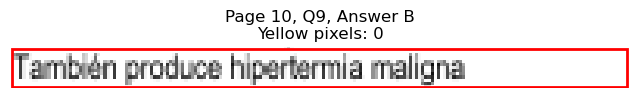

Page 10, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=161.1, y1=699.7
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 368
Page 10, Q9, C: Yellow percentage: 0.0%


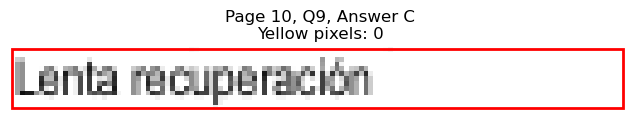

Page 10, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=477.0, y1=675.5
Page 10, Q9, D: Yellow pixels: 1902
Page 10, Q9, D: Total non-white pixels: 2470
Page 10, Q9, D: Yellow percentage: 77.0%


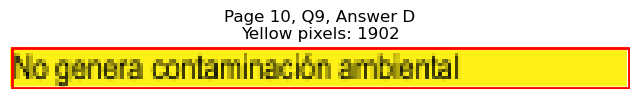

Page 10, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=379.3, y1=687.5
Page 10, Q9, E: Yellow pixels: 94
Page 10, Q9, E: Total non-white pixels: 315
Page 10, Q9, E: Yellow percentage: 29.8%


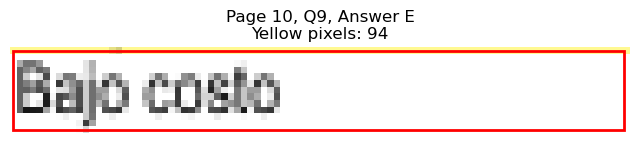


Page 10, Q9 - Selected Answer: D (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=85.0, y0=723.7, x1=114.6, y1=735.8
Page 10, Q10, A: Yellow pixels: 858
Page 10, Q10, A: Total non-white pixels: 1053
Page 10, Q10, A: Yellow percentage: 81.5%


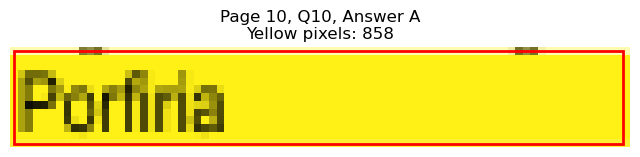

Page 10, Q10 - B: Detected box: x0=85.0, y0=735.8, x1=182.7, y1=747.9
Page 10, Q10, B: Yellow pixels: 149
Page 10, Q10, B: Total non-white pixels: 644
Page 10, Q10, B: Yellow percentage: 23.1%


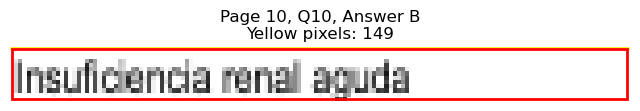

Page 10, Q10 - C: Detected box: x0=85.0, y0=747.8, x1=129.0, y1=759.9
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 244
Page 10, Q10, C: Yellow percentage: 0.0%


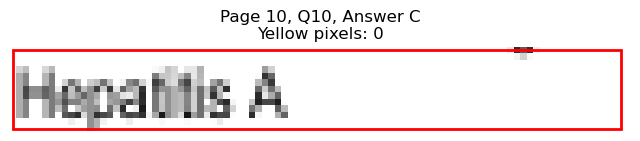

Page 10, Q10 - D: Detected box: x0=336.7, y0=723.7, x1=428.1, y1=735.8
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 441
Page 10, Q10, D: Yellow percentage: 0.0%


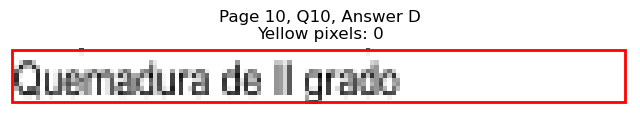

Page 10, Q10 - E: Detected box: x0=336.7, y0=735.8, x1=399.4, y1=747.9
Page 10, Q10, E: Yellow pixels: 0
Page 10, Q10, E: Total non-white pixels: 356
Page 10, Q10, E: Yellow percentage: 0.0%


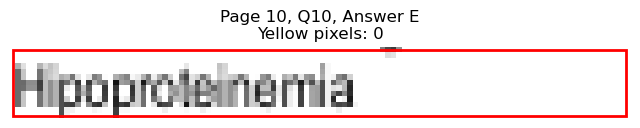


Page 10, Q10 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál de las siguientes es una ventaja del uso...
1   En la valoración para intubación traqueal. ¿A ...
2   ¿Cuál de las siguientes es una complicación de...
3   ¿Cuál de los siguientes es un efecto adverso d...
4   ¿Cuál es el número de máscara laríngea que le ...
..                                                ...
95  ¿Cuál es el relajante muscular adecuado en la ...
96  Según la Asociación Americana de Anestesiologí...
97  ¿Cuál de las siguientes es una condición asoci...
98  ¿Cuál de las siguientes es una característica ...
99  ¿Cuál de las siguientes entidades es una contr...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                            Lenta absorción   
1   Imposibilidad para ver el paladar blando   
2                                     Fiebre   
3                                    Prurito   
4                                        1.5   
..                                       ...   
95                                Pancuronio   
96                                       4 h   
97                          Obesidad mórbida   
98                Alta solubilidad en sangre   
99                                  Porfiria   

                                  option_B  \
0                          Lento despertar   
1   Visibilidad del paladar blando y úvula   
2                                  Cefalea   
3                                Urticaria   
4                                      2.5   
..                                     ...   
95                               Vecuronio   
96                                     2 h   
97                             Talla corta   
98     También produce hipertermia maligna   
99               Insuficiencia renal aguda   

                                             option_C  \
0   Lenta reversibilidad de la profundidad anestésica   
1             Solo hay visibilidad del paladar blando   
2                                    Reflujo gástrico   
3                              Depresión respiratoria   
4                                                   1   
..                                                ...   
95                                     Succinilcolina   
96                                                6 h   
97                                       Cuello largo   
98                                 Lenta recuperación   
99                                        Hepatitis A   

                                           option_D  \
0                                   Baja excitación   
1   Visibilidad del paladar blando, úvula y pilares   
2                                    Laringoespasmo   
3                                Retención urinaria   
4                                                 4   
..                                              ...   
95                                     Cisatracurio   
96                                              1 h   
97                               Dispepsia gástrica   
98                No genera contaminación ambiental   
99                            Quemadura de II grado   

                          option_E  
0       Buena hipnosis y analgesia  
1   Visibilidad de cuerdas vocales  
2                     Convulsiones  
3                    Hipogonadismo  
4                                3  
..                             ...  
95                       Mivacurio  
96                             8 h  
97                  Tos productiva  
98                      Bajo costo  
99                 Hipoproteinemia  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               E
1               C
2               D
3               E
4               B
..            ...
95              A
96              A
97              A
98              D
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   ¿Cuál de las siguientes es una ventaja del uso...   
1   En la valoración para intubación traqueal. ¿A ...   
2   ¿Cuál de las siguientes es una complicación de...   
3   ¿Cuál de los siguientes es un efecto adverso d...   
4   ¿Cuál es el número de máscara laríngea que le ...   
..                                                ...   
95  ¿Cuál es el relajante muscular adecuado en la ...   
96  Según la Asociación Americana de Anestesiologí...   
97  ¿Cuál de las siguientes es una condición asoci...   
98  ¿Cuál de las siguientes es una característica ...   
99  ¿Cuál de las siguientes entidades es una contr...   

                                    option_A  \
0                            Lenta absorción   
1   Imposibilidad para ver el paladar blando   
2                                     Fiebre   
3                                    Prurito   
4                                        1.5   
..                                       ...   
95                                Pancuronio   
96                                       4 h   
97                          Obesidad mórbida   
98                Alta solubilidad en sangre   
99                                  Porfiria   

                                  option_B  \
0                          Lento despertar   
1   Visibilidad del paladar blando y úvula   
2                                  Cefalea   
3                                Urticaria   
4                                      2.5   
..                                     ...   
95                               Vecuronio   
96                                     2 h   
97                             Talla corta   
98     También produce hipertermia maligna   
99               Insuficiencia renal aguda   

                                             option_C  \
0   Lenta reversibilidad de la profundidad anestésica   
1             Solo hay visibilidad del paladar blando   
2                                    Reflujo gástrico   
3                              Depresión respiratoria   
4                                                   1   
..                                                ...   
95                                     Succinilcolina   
96                                                6 h   
97                                       Cuello largo   
98                                 Lenta recuperación   
99                                        Hepatitis A   

                                           option_D  \
0                                   Baja excitación   
1   Visibilidad del paladar blando, úvula y pilares   
2                                    Laringoespasmo   
3                                Retención urinaria   
4                                                 4   
..                                              ...   
95                                     Cisatracurio   
96                                              1 h   
97                               Dispepsia gástrica   
98                No genera contaminación ambiental   
99                            Quemadura de II grado   

                          option_E correct_answer  
0       Buena hipnosis y analgesia              E  
1   Visibilidad de cuerdas vocales              C  
2                     Convulsiones              D  
3                    Hipogonadismo              E  
4                                3              B  
..                             ...            ...  
95                       Mivacurio              A  
96                             8 h              A  
97                  Tos productiva              A  
98                      Bajo costo              D  
99                 Hipoproteinemia              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/ANESTESIOLOGIA.csv
